In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import joblib
from IPython.core.display import display, HTML
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from tabulate import tabulate

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/preprocessed_extracted_features_iemocap.csv"
ALL_EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/all_preprocessed_extracted_features_iemocap.csv"
SCALED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/scaled_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'
AUDIO_CLASSIFIER_MODEL = '../../audio_classifier_model.pkl'

config = Configuration.load_json(CONFIG_FILE)
colors = ["blue", "orange", "green", "red"]

OneHotEncodingConfig = {'0': [1, 0], '1': [0, 1]}
plt.rcParams['figure.dpi'] = 300
tabulate.LATEX_ESCAPE_RULES = {}

In [2]:
def get_metrics(y_labels, y_pred, folds_size, ticks, show_cm=True):
    accs = []
    f1s = []
    pres = []
    recs = []
    mccs = []
    i = 0
    for f_i in range(5):
        acc = round(metrics.accuracy_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
        f1 = round(metrics.f1_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]], average='macro') * 100, 2)
        pre = round(metrics.precision_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]], average='macro') * 100, 2)
        rec = round(metrics.recall_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]], average='macro') * 100, 2)
        mcc = round(metrics.matthews_corrcoef(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]), 2)
        print(f"Accuracy for fold {f_i}: {acc}%")
        i += folds_size[f_i]
        accs.append(acc)
        f1s.append(f1)
        pres.append(pre)
        recs.append(rec)
        mccs.append(mcc)
    
    mean_acc = f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"
    mean_f1 = f"{round(metrics.f1_score(y_labels, y_pred, average='macro') * 100, 2)}+-{round(np.std(f1s), 2)}"
    mean_pre = f"{round(metrics.precision_score(y_labels, y_pred, average='macro') * 100, 2)}+-{round(np.std(pres), 2)}"
    mean_rec = f"{round(metrics.recall_score(y_labels, y_pred, average='macro') * 100, 2)}+-{round(np.std(recs), 2)}"
    mean_mcc = f"{round(metrics.matthews_corrcoef(y_labels, y_pred), 2)}+-{round(np.std(mccs), 2)}"

    table = [
        ["Accuracy", mean_acc],
        ["F1 score macro", mean_f1],
        ["Precision", mean_pre],
        ["Recall", mean_rec],
        ["Matthews corrcoef", mean_mcc],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    if show_cm:
        cm = metrics.confusion_matrix(y_labels, y_pred, normalize='all')
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt=".2f",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

    return [x[1] for x in table]

def categorical_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))
        
        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test.values.ravel())

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "))
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results

results = []

In [71]:
def categorical_cross_validation2(get_new_model, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = [centroids[int(x)] for x in y.iloc[train].values.ravel()]
        y_test = y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model.fit(X_train, y_dim_train)

        y_pred = model.predict(X_test)
        
        # Closest Centroid is considered the predicted Emotion
        # Using manhatan distance
        y_pred = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in y_pred]

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [17]:
def categorical_cross_validation3(get_new_model, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        # Closest Centroid is considered the Emotion for training
        # Using manhatan distance
        y_train = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in df.iloc[train, 5:8].values]
        y_test = y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [18]:
def categorical_cross_validation4(get_new_model, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = df.iloc[train, 5:8].values
        y_test = y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model.fit(X_train, y_dim_train)

        y_pred = model.predict(X_test)
        
        # Closest Centroid is considered the predicted Emotion
        # Using manhatan distance
        y_pred = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in y_pred]

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [19]:
def categorical_cross_validation5(get_new_model, get_new_model2, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    y_dim = df.iloc[:,6:9]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model_categorical = get_new_model()
        model_regression = get_new_model2()

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = y_dim.iloc[train]
        y_train, y_test = y.iloc[train].values.ravel(), y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model_regression.fit(X_train, y_dim_train.values)

        X_train.insert(0, value=y_dim_train['Valence'], column='Valence')
        X_train.insert(1, value=y_dim_train['Activation'], column='Activation')
        X_train.insert(2, value=y_dim_train['Dominance'], column='Dominance')
        
        model_categorical.fit(X_train, y_train)

        y_pred_regression = pd.DataFrame(model_regression.predict(X_test), columns=['Valence', 'Activation', 'Dominance'])
        
        X_test.insert(0, value=y_pred_regression['Valence'].values, column='Valence')
        X_test.insert(1, value=y_pred_regression['Activation'].values, column='Activation')
        X_test.insert(2, value=y_pred_regression['Dominance'].values, column='Dominance')

        y_pred_categorical = model_categorical.predict(X_test)
        
        # # Closest Centroid is considered the predicted Emotion
        # # Using manhatan distance
        # y_pred = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in y_pred]

        all_y_pred.extend(y_pred_categorical)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [20]:
def categorical_cross_validation6(get_new_model, get_new_model2, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    y_dim = df.iloc[:,6:9]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model_categorical = get_new_model()
        model_regression = get_new_model2()

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = y_dim.iloc[train]
        y_train, y_test = y.iloc[train].values.ravel(), y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model_regression.fit(X_train, y_dim_train.values)
        
        y_dim_train = y_dim_train.apply(
            lambda x:
                pd.Series(np.argmin([distance.cityblock((x['Valence'], x['Activation'], x['Dominance']), c) for c in centroids]),
                          index=['Angry_Centroid_Distance']),
                axis=1)

        X_train.insert(0, value=y_dim_train['Angry_Centroid_Distance'], column='Angry_Centroid_Distance')
        # X_train.insert(1, value=y_dim_train['Happy_Centroid_Distance'], column='Happy_Centroid_Distance')
        # X_train.insert(2, value=y_dim_train['Sad_Centroid_Distance'], column='Sad_Centroid_Distance')
        # X_train.insert(3, value=y_dim_train['Neutral_Centroid_Distance'], column='Neutral_Centroid_Distance')
        
        model_categorical.fit(X_train, y_train)

        y_pred_regression = pd.DataFrame(model_regression.predict(X_test), columns=['Valence', 'Activation', 'Dominance'])
        # Using manhatan distance
        y_pred_regression = y_pred_regression.apply(
            lambda x:
                pd.Series(np.argmin([distance.cityblock((x['Valence'], x['Activation'], x['Dominance']), c) for c in centroids]),
                          index=['Angry_Centroid_Distance']),
                axis=1)
        
        X_test.insert(0, value=y_pred_regression['Angry_Centroid_Distance'].values, column='Angry_Centroid_Distance')
        # X_test.insert(1, value=y_pred_regression['Happy_Centroid_Distance'].values, column='Happy_Centroid_Distance')
        # X_test.insert(2, value=y_pred_regression['Sad_Centroid_Distance'].values, column='Sad_Centroid_Distance')
        # X_test.insert(3, value=y_pred_regression['Neutral_Centroid_Distance'].values, column='Neutral_Centroid_Distance')

        y_pred_categorical = model_categorical.predict(X_test)
        

        all_y_pred.extend(y_pred_categorical)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [21]:
def categorical_cross_validation7(get_new_model, get_new_model_regressor, centroids, used_labels, results, threshold, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        model_regressor = get_new_model_regressor()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_dim_train, y_test = y.iloc[train].values.ravel(), df.iloc[train, 5:8].values, y.iloc[test].values.ravel()
        folds_size.append(len(y_test))

        model.fit(X_train, y_train)
        model_regressor.fit(X_train, y_dim_train)

        y_pred = model.predict(X_test)
        y_pred_reg = model_regressor.predict(X_test)

        discarded_pred_indices = []
        [discarded_pred_indices.append(i) for i, pred in enumerate(y_pred) 
            if distance.cityblock(y_pred_reg[i], centroids[pred]) > threshold]

        print(f"Discarded Predictions on Fold {fold_no}: {len(discarded_pred_indices)}")
        y_pred = [l for i, l in enumerate(y_pred) if i not in discarded_pred_indices]
        y_test = [l for i, l in enumerate(y_test) if i not in discarded_pred_indices]

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [22]:
def categorical_cross_validation8(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train].values.ravel(), y.iloc[test].values.ravel()
        folds_size.append(len(y_test))
        
        y_train_vad = []
        for label in y_train:
            if label == 0:
                y_train_vad.append([2, 0])
            elif label == 1:
                y_train_vad.append([2, 2])
            elif label == 2:
                y_train_vad.append([0, 0])
            else:
                y_train_vad.append([1, 1])

        model.fit(X_train, y_train_vad)
        
        y_pred_vad = model.predict(X_test)
        
        y_pred, deleted_pred_indices = [], set()
        for i, label in enumerate(y_pred_vad):
            if (label == [2, 0]).all():
                y_pred.append(0)
            elif (label == [2, 2]).all():
                y_pred.append(1)
            elif (label == [0, 0]).all():
                y_pred.append(2)
            elif (label == [1, 1]).all():
                y_pred.append(3)
            else:
                deleted_pred_indices.add(i)

        print(f"Deleted labels: {len(deleted_pred_indices)}")
        y_test = [label for i, label in enumerate(y_test) if i not in deleted_pred_indices]
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

def get_new_model():
    return AdaBoostClassifier(random_state=1, estimator=RandomForest(n_estimators=512, n_jobs=-1, random_state=1))

def get_new_model_regressor():
    return RandomForestRegressor(n_estimators=512, n_jobs=-1, random_state=1)

centroids = []
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    centroids.append(df_temp.iloc[:,6:9].mean(axis=0).values)

Testing SMOTE

In [4]:
def categorical_cross_validation_smote(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    sm = SMOTE(random_state=1)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))

        X_train, y_train = sm.fit_resample(X_train, y_train)

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "))
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results

Accuracy for fold 0: 58.9%
Accuracy for fold 1: 60.13%
Accuracy for fold 2: 59.86%
Accuracy for fold 3: 58.95%
Accuracy for fold 4: 57.23%

Metric             Value
-----------------  -----------
Accuracy           59.01+-1.02
F1 score macro     59.5+-0.97
Precision          59.16+-0.95
Recall             60.88+-1.03
Matthews corrcoef  0.45+-0.01


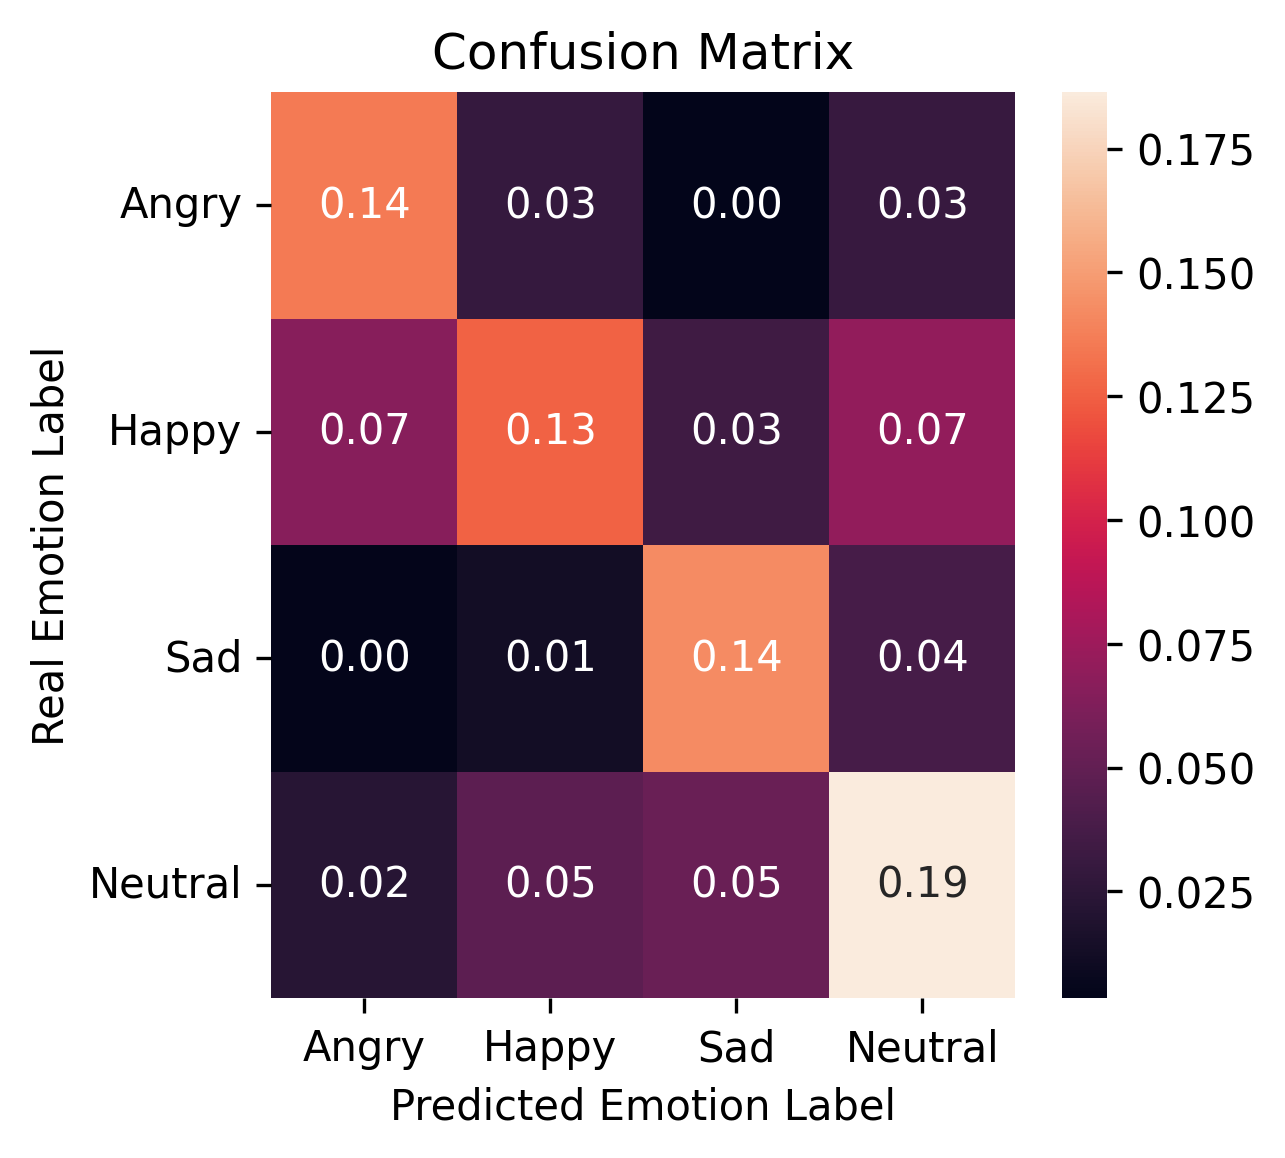

In [5]:
results = categorical_cross_validation_smote(get_new_model, "Angry, Happy, Sad, Neutral", results)

Testing other strategies

Accuracy for fold 0: 60.16%
Accuracy for fold 1: 61.75%
Accuracy for fold 2: 59.76%
Accuracy for fold 3: 59.67%
Accuracy for fold 4: 58.86%

Metric             Value
-----------------  -----------
Accuracy           60.04+-0.95
F1 score macro     60.76+-0.95
Precision          61.29+-0.94
Recall             60.59+-1.02
Matthews corrcoef  0.46+-0.01


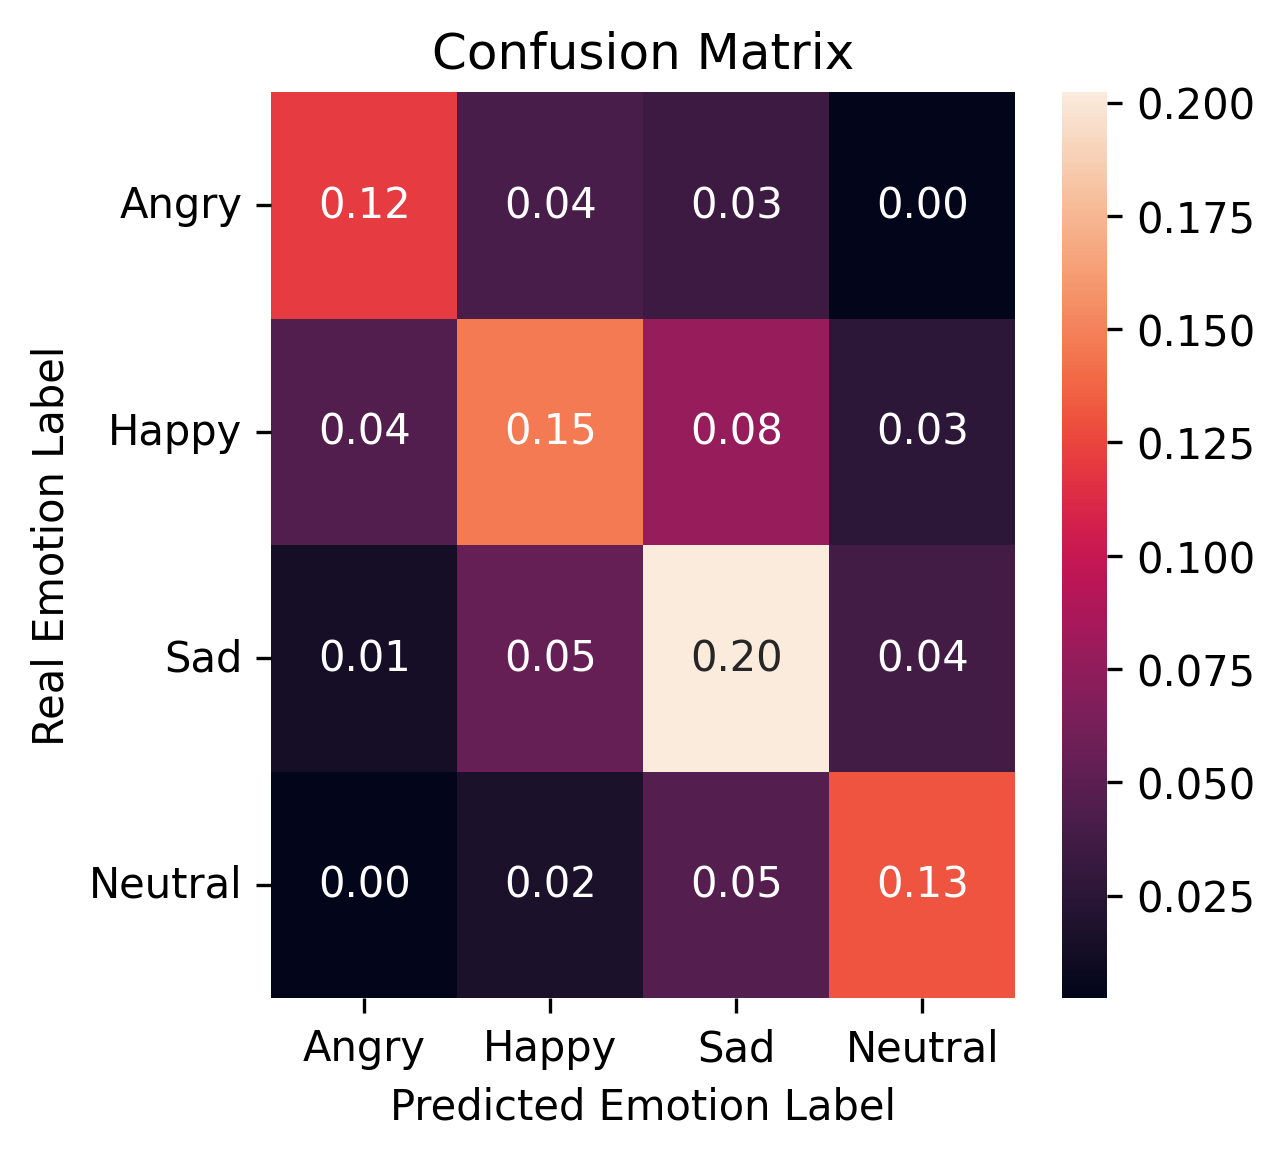

KeyboardInterrupt: 

In [37]:
# using the juries VAD classification doesn't really help with the categorical classification
# so the annotations might not be very good
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation2(get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation3(get_new_model, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation4(get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation5(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation6(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation7(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results, 0.2)
results = categorical_cross_validation8(get_new_model, "Angry, Happy, Sad, Neutral", results)


In [38]:
results = categorical_cross_validation7(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results, 1.8)

Discarded Predictions on Fold 1: 558
Discarded Predictions on Fold 2: 578
Discarded Predictions on Fold 3: 548
Discarded Predictions on Fold 4: 527
Discarded Predictions on Fold 5: 531
Accuracy for fold 0: 59.98%
Accuracy for fold 1: 61.48%
Accuracy for fold 2: 60.76%
Accuracy for fold 3: nan%
Accuracy for fold 4: nan%

Metric             Value
-----------------  ----------
Accuracy           60.74+-nan
F1 score macro     40.13+-nan
Precision          44.14+-nan
Recall             42.74+-nan
Matthews corrcoef  0.39+-0.19


C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

In [39]:
results = categorical_cross_validation8(get_new_model, "Angry, Happy, Sad, Neutral", results)

ValueError: y should be a 1d array, got an array of shape (4424, 2) instead.

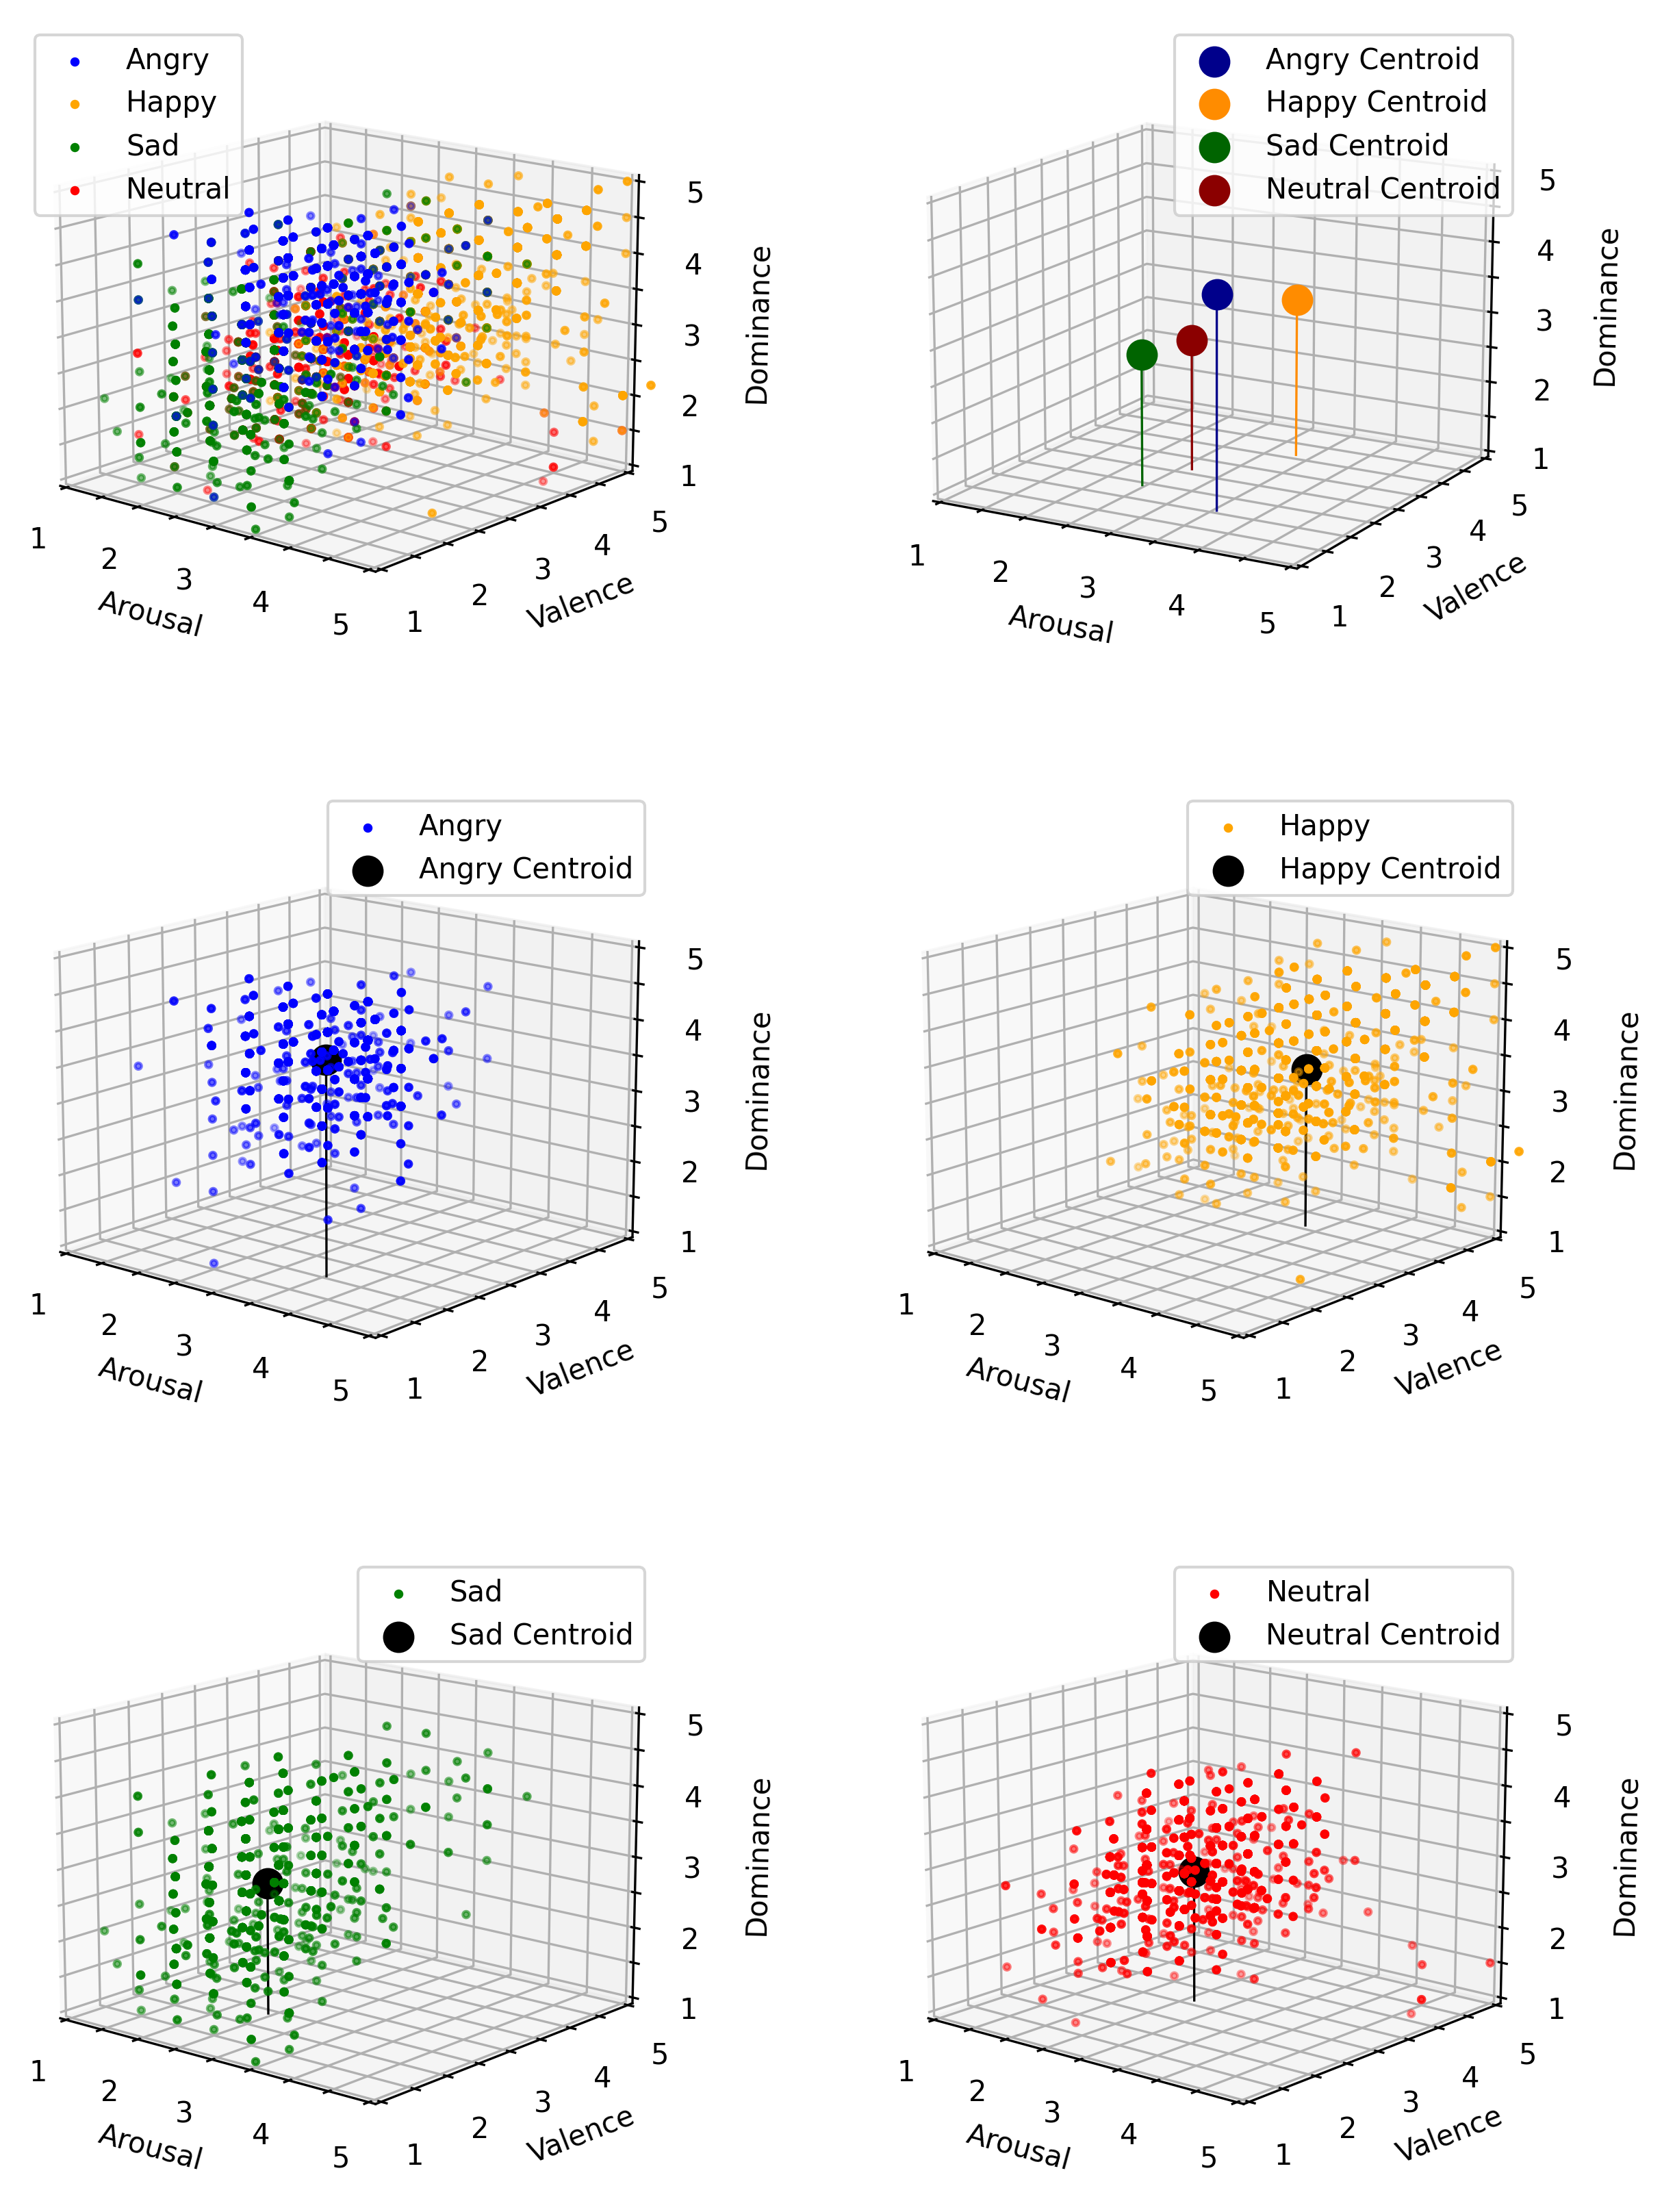

In [6]:
fig = plt.figure(figsize=(10, 14))
spec = fig.add_gridspec(3, 2)
ax = fig.add_subplot(spec[0, 0], projection='3d')
ax.set_xlabel("Arousal")
ax.set_ylabel("Valence")
ax.set_zlabel("Dominance")
ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_xlim(1, 5)
ax.set_ylim(1, 5)
ax.set_zlim(1, 5)
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    x = df_temp["Activation"].values
    y = df_temp["Valence"].values
    z = df_temp["Dominance"].values
    ax.scatter(x,y,z, marker='.', label=emotion.title(), color=colors[i])
    ax.view_init(15, -50)
    plt.legend()


ax = fig.add_subplot(spec[0, 1], projection='3d')
ax.set_xlabel("Arousal")
ax.set_ylabel("Valence")
ax.set_zlabel("Dominance")
ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_xlim(1, 5)
ax.set_ylim(1, 5)
ax.set_zlim(1, 5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1/2))

for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    x = centroids[i][1]
    y = centroids[i][0]
    z = centroids[i][2]
    ax.scatter(x, y, z, label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax.plot([x]*2,[y]*2, [1, z], color=f"dark{colors[i]}", linewidth=0.8)
    ax.view_init(15, -60)
    plt.legend()

for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    ax = fig.add_subplot(spec[1 if i<2 else 2, i%2], projection='3d')
    ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
    ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
    ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
    ax.set_xlim(1, 5)
    ax.set_ylim(1, 5)
    ax.set_zlim(1, 5)
    ax.set_xlabel("Arousal")
    ax.set_ylabel("Valence")
    ax.set_zlabel("Dominance")
    df_temp = df[df['Emotion'] == emotion]
    x = df_temp["Activation"].values
    y = df_temp["Valence"].values
    z = df_temp["Dominance"].values
    ax.scatter(x, y, z, marker='.', label=emotion.title(), color=colors[i])
    ax.scatter(centroids[i][1], centroids[i][0], centroids[i][2], label=f"{emotion.title()} Centroid", color="black", s=100)
    ax.plot([centroids[i][1]]*2,[centroids[i][0]]*2, [1, centroids[i][2]], color=f"black", linewidth=0.8)
    ax.view_init(15, -50)
    plt.legend()
plt.legend()
plt.show()

<Figure size 1800x1200 with 0 Axes>

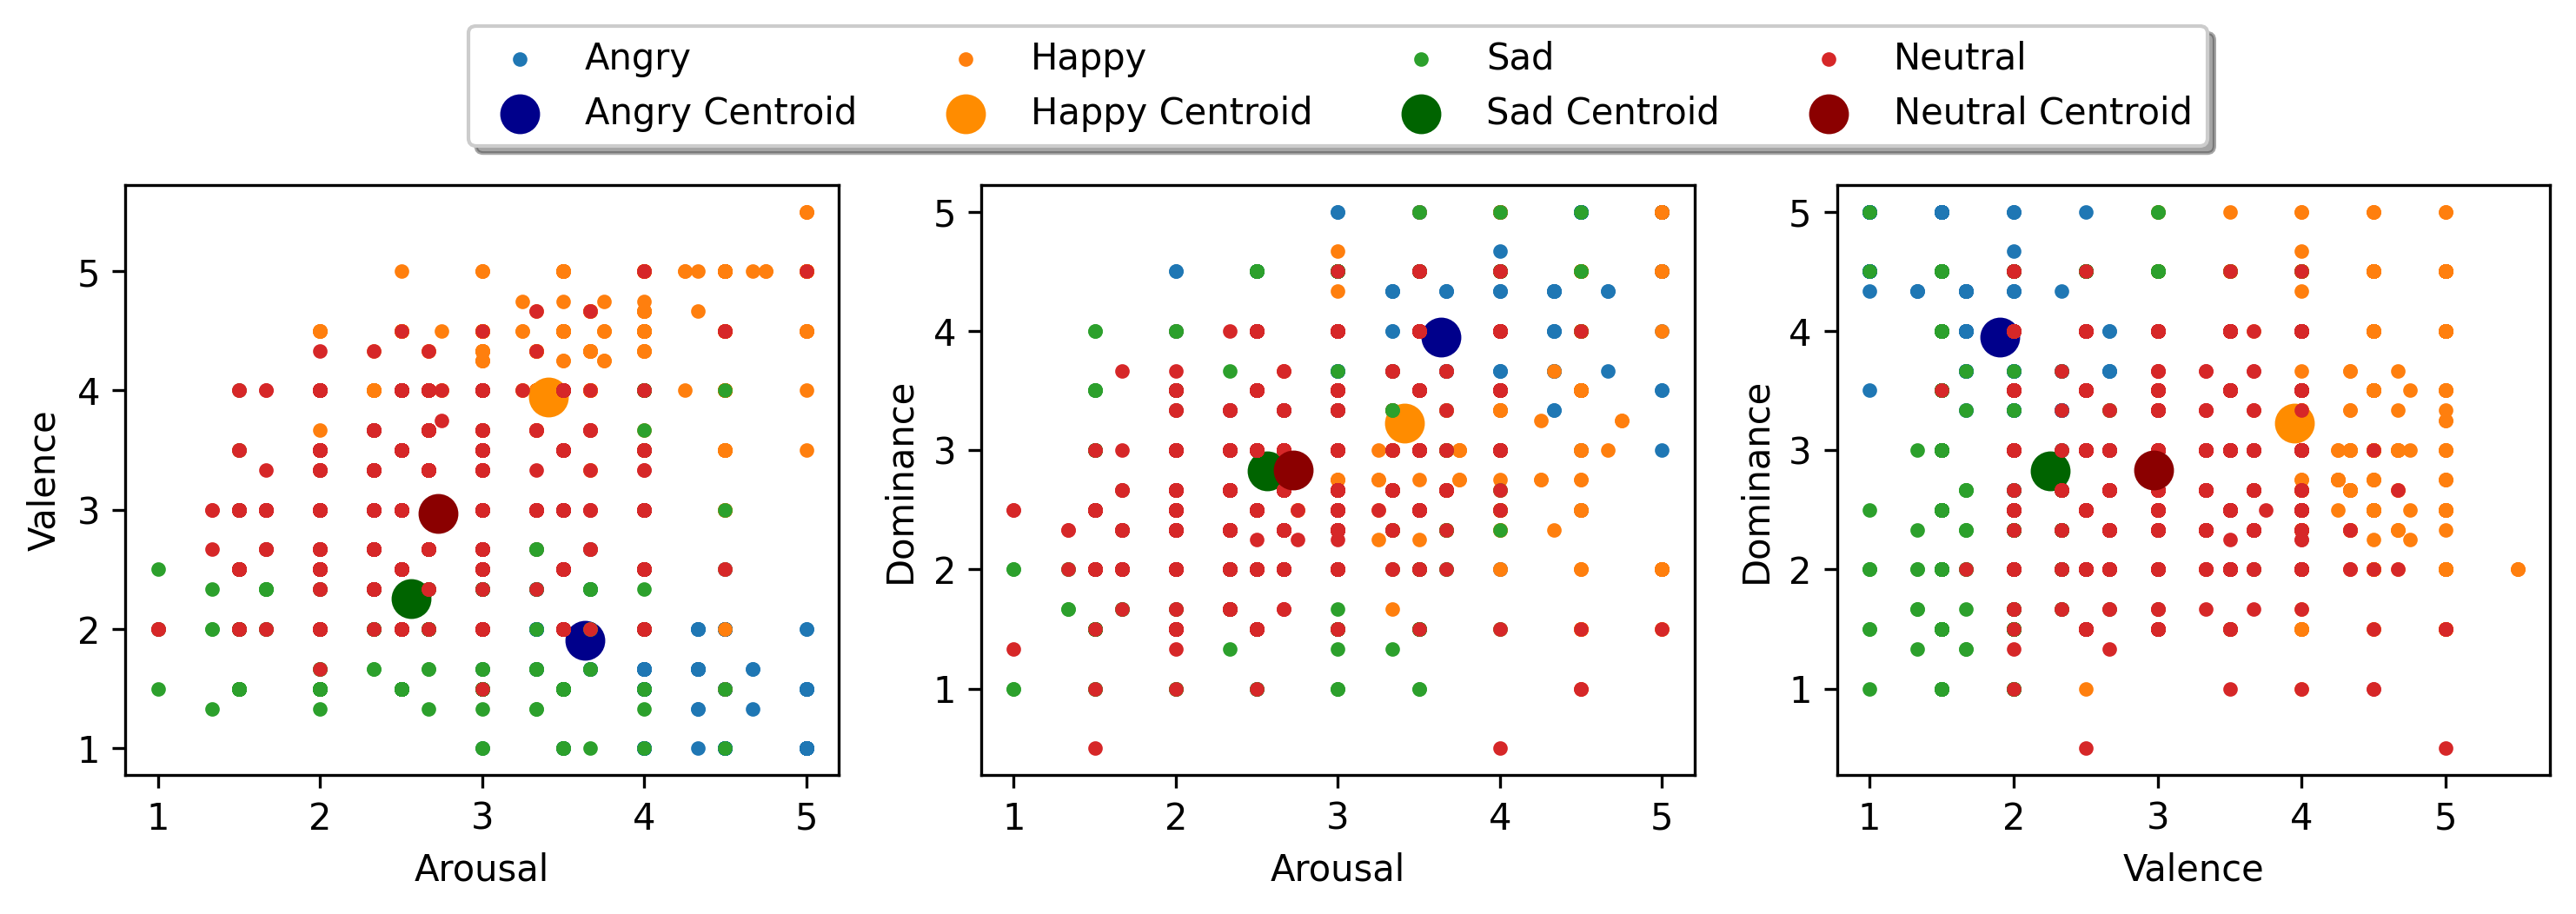

In [7]:
fig = plt.figure()
fig = plt.figure(figsize=(12, 3))
spec = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlabel("Arousal")
ax1.set_ylabel("Valence")
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlabel("Arousal")
ax2.set_ylabel("Dominance")
ax3 = fig.add_subplot(spec[0, 2])
ax3.set_xlabel("Valence")
ax3.set_ylabel("Dominance")

for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    x = df_temp["Activation"].values
    y = df_temp["Valence"].values
    z = df_temp["Dominance"].values
    ax1.scatter(x,y, marker='.', label=emotion.title())
    ax2.scatter(x,z, marker='.', label=emotion.title())
    ax3.scatter(y,z, marker='.', label=emotion.title())
    ax1.scatter(centroids[i][1],centroids[i][0], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(centroids[i][1],centroids[i][2], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax3.scatter(centroids[i][0],centroids[i][2], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=4, fancybox=True, shadow=True)
plt.show()

In [8]:
# Removinng Emotion Category Conflicts
# Happy: Low arousal or low valence
# Sad: High valence (or high arousal)
# (Neutral: Extremes)
# Angry: Low arousal or high valence

In [9]:
display(HTML('<a href="https://www.researchgate.net/figure/The-VAD-Valence-Arousal-Dominance-model-spanned-across-the-six-basic-emotions_fig1_338118399"><img src="https://www.researchgate.net/publication/338118399/figure/fig1/AS:839259078553600@1577106365010/The-VAD-Valence-Arousal-Dominance-model-spanned-across-the-six-basic-emotions.jpg" alt="The VAD (Valence-Arousal-Dominance) model spanned across the six basic emotions."/></a>'))

Non-strict Conflicts

In [10]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(1 <= df['Activation']) & (df['Activation'] <= 5) & (1 <= df['Valence']) & (df['Valence'] <= 5) & (1 <= df['Dominance']) & (df['Dominance'] <= 5)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == "excited", 'Emotion'] = "happy"

df = df[(
        (df['Activation'] >= 3)
        &
        (df['Valence'] >= 3)
        &
        (df['Dominance'] >= 2)
        ) | (df['Emotion'] != 'happy')]

df = df[(
        (df['Activation'] >= 2)
        &
        (df['Valence'] <= 4)
        &
        (df['Dominance'] >= 1.5) & (df['Dominance'] <= 4.5)
        ) | (df['Emotion'] != 'neutral')]

df = df[(
        (df['Activation'] < 3.5)
        &
        (df['Valence'] < 3.5)
        # &
        # (df['Dominance'] >= 1) & (df['Dominance'] <= 5)
        ) | (df['Emotion'] != 'sad')]

df = df[(
        (df['Activation'] > 2.5)
        &
        (df['Valence'] <= 3.5)
        &
        (df['Dominance'] >= 2)
        ) | (df['Emotion'] != 'angry')]

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 4816


Emotion
                     count
Emotion Emotion_Id        
angry   0              980
happy   1             1304
neutral 3             1637
sad     2              895

Accuracy for fold 0: 64.94%
Accuracy for fold 1: 63.66%
Accuracy for fold 2: 64.38%
Accuracy for fold 3: 63.55%
Accuracy for fold 4: 62.41%

Metric             Value
-----------------  -----------
Accuracy           63.79+-0.85
F1 score macro     64.02+-0.87
Precision          64.82+-0.86
Recall             63.79+-0.89
Matthews corrcoef  0.51+-0.01


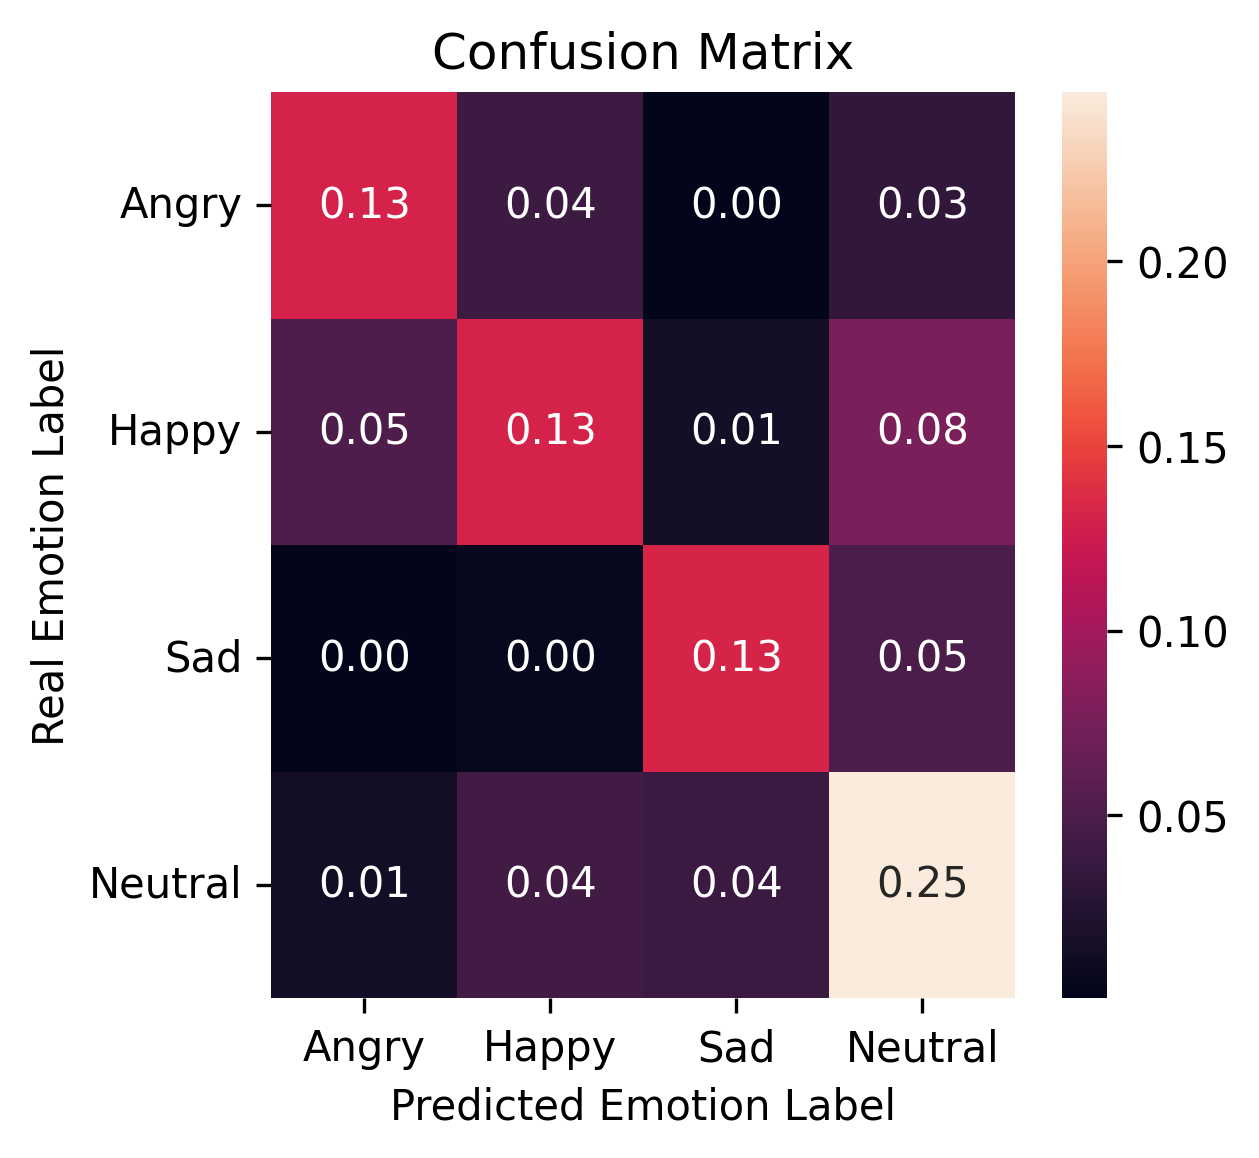

In [11]:
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

Accuracy for fold 0: 62.97%
Accuracy for fold 1: 64.17%
Accuracy for fold 2: 62.2%
Accuracy for fold 3: 62.82%
Accuracy for fold 4: 61.16%

Metric             Value
-----------------  -----------
Accuracy           62.67+-0.99
F1 score macro     63.02+-1.01
Precision          62.52+-1.09
Recall             64.25+-0.86
Matthews corrcoef  0.5+-0.01


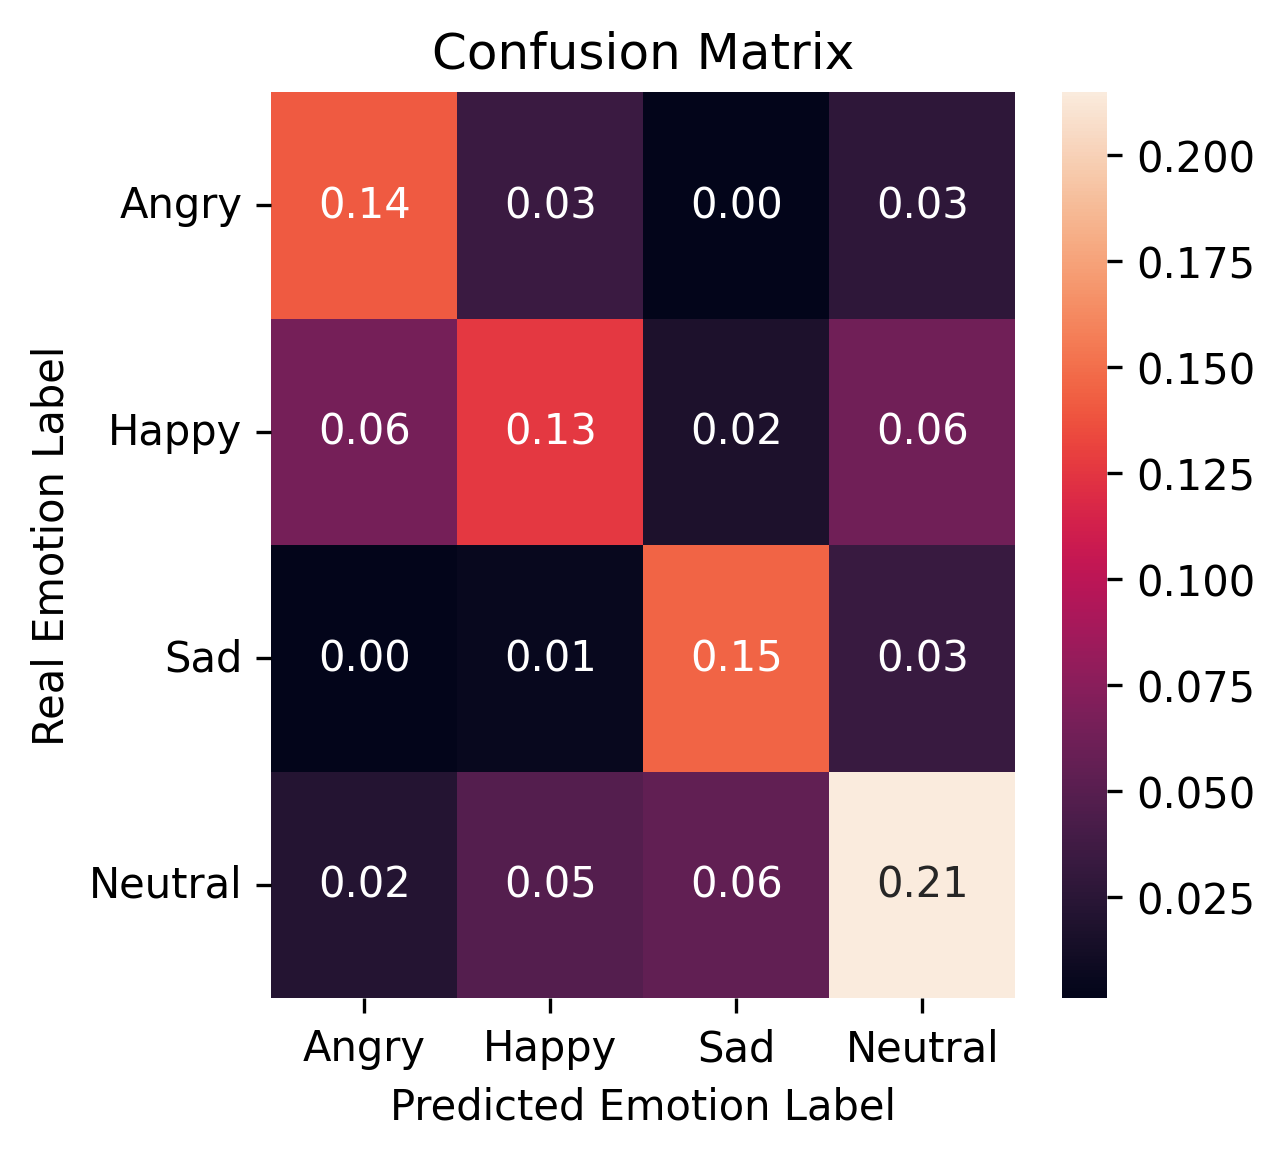

In [12]:
results = categorical_cross_validation_smote(get_new_model, "Angry, Happy, Sad, Neutral", results)

Strict Conflicts

In [13]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == "excited", 'Emotion'] = "happy"

df = df[(
        (df['Activation'] > 3)
        &
        (df['Valence'] > 3)
        &
        (df['Dominance'] >= 2)
        ) | (df['Emotion'] != 'happy')]

df = df[(
        (df['Activation'] > 2)
        &
        (df['Valence'] < 4)
        &
        (df['Dominance'] >= 2) & (df['Dominance'] <= 4)
        ) | (df['Emotion'] != 'neutral')]

df = df[(
        (df['Activation'] < 4)
        &
        (df['Valence'] < 4)
        # &
        # (df['Dominance'] >= 1) & (df['Dominance'] <= 5)
        ) | (df['Emotion'] != 'sad')]

df = df[(
        (df['Activation'] > 3)
        &
        (df['Valence'] < 3)
        &
        (df['Dominance'] >= 2)
        ) | (df['Emotion'] != 'angry')]

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 3914


Emotion
                     count
Emotion Emotion_Id        
angry   0              773
happy   1              859
neutral 3             1252
sad     2             1030

Accuracy for fold 0: 69.73%
Accuracy for fold 1: 67.94%
Accuracy for fold 2: 68.71%
Accuracy for fold 3: 64.11%
Accuracy for fold 4: 68.41%

Metric             Value
-----------------  -----------
Accuracy           67.78+-1.93
F1 score macro     66.45+-2.07
Precision          67.92+-1.98
Recall             66.51+-1.92
Matthews corrcoef  0.57+-0.02


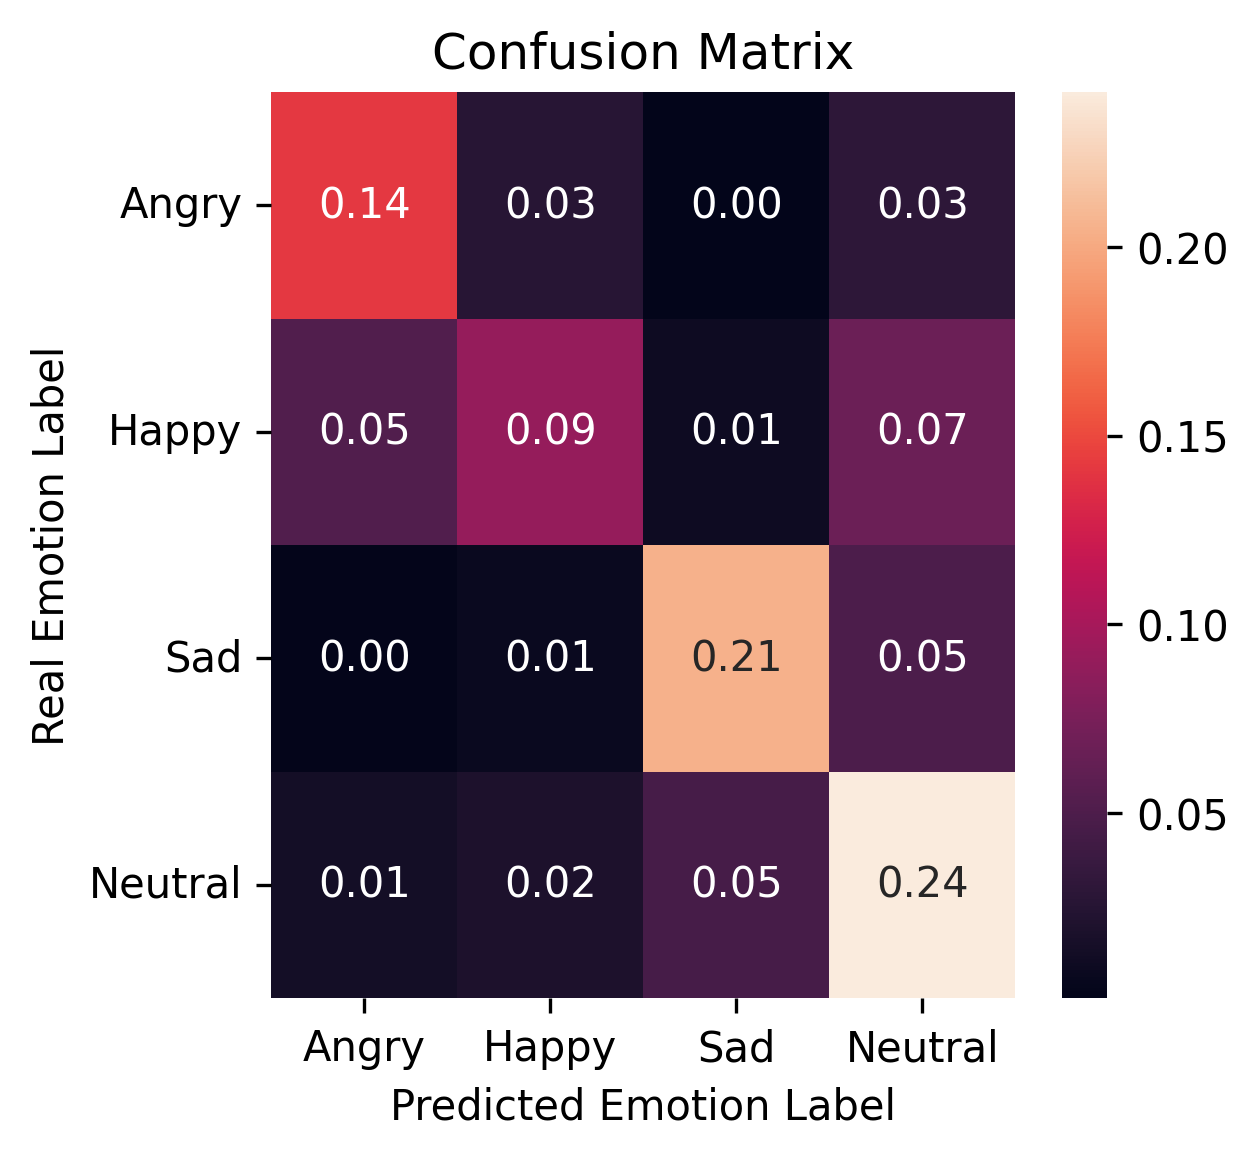

In [14]:
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

Accuracy for fold 0: 68.97%
Accuracy for fold 1: 66.28%
Accuracy for fold 2: 67.18%
Accuracy for fold 3: 63.86%
Accuracy for fold 4: 68.93%

Metric             Value
-----------------  -----------
Accuracy           67.04+-1.9
F1 score macro     66.18+-1.94
Precision          66.33+-1.78
Recall             66.51+-1.96
Matthews corrcoef  0.56+-0.03


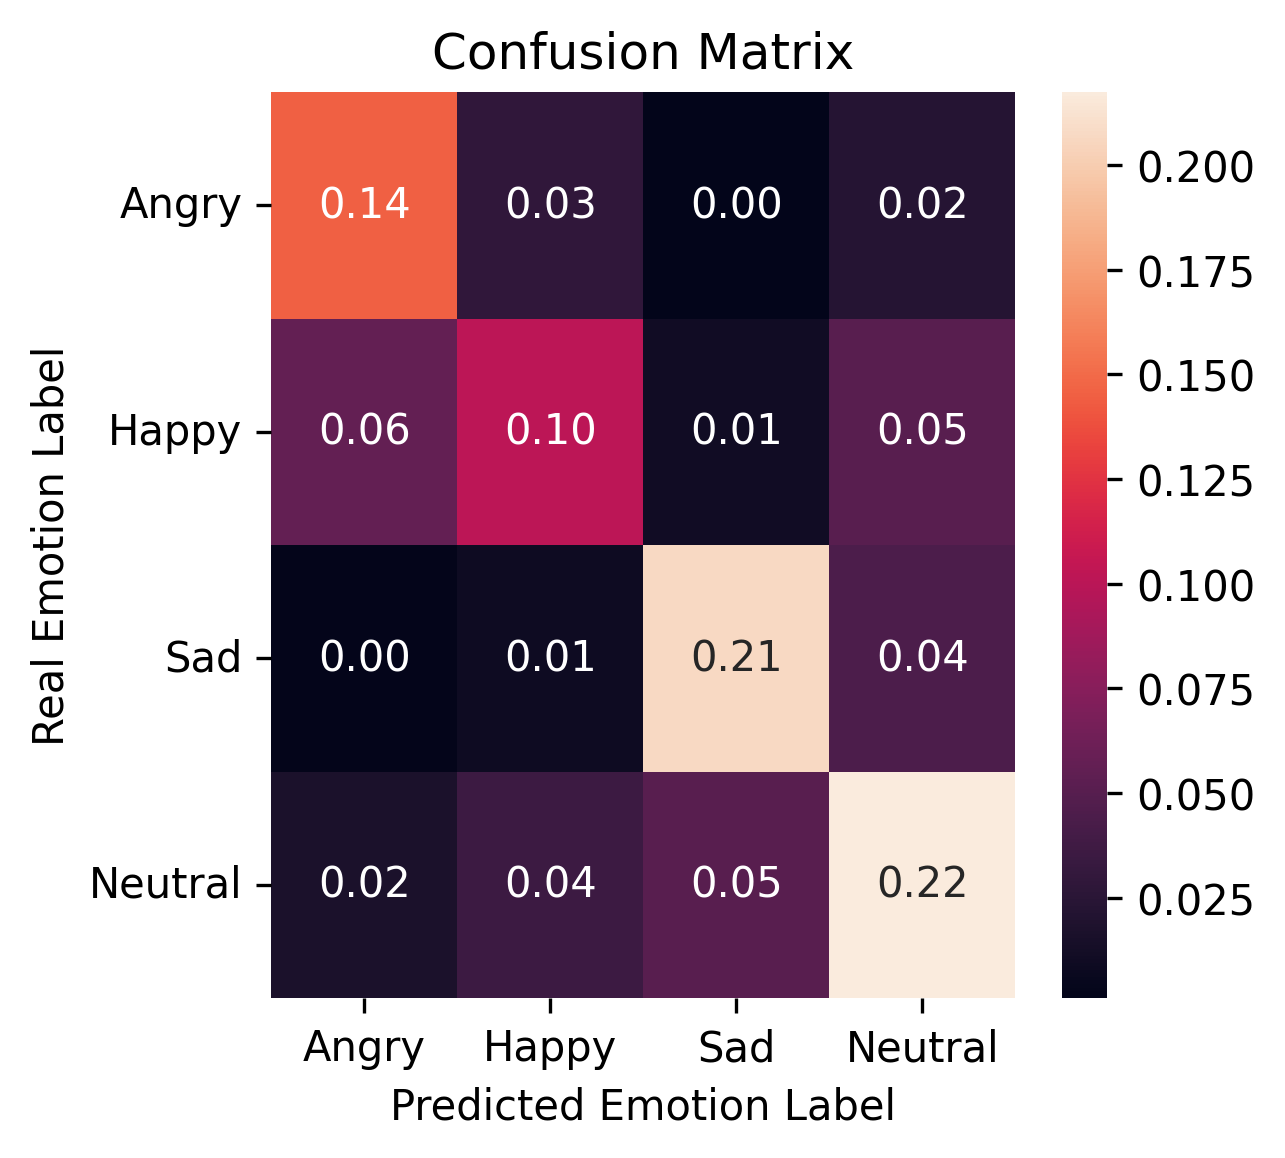

In [15]:
results = categorical_cross_validation_smote(get_new_model, "Angry, Happy, Sad, Neutral", results)

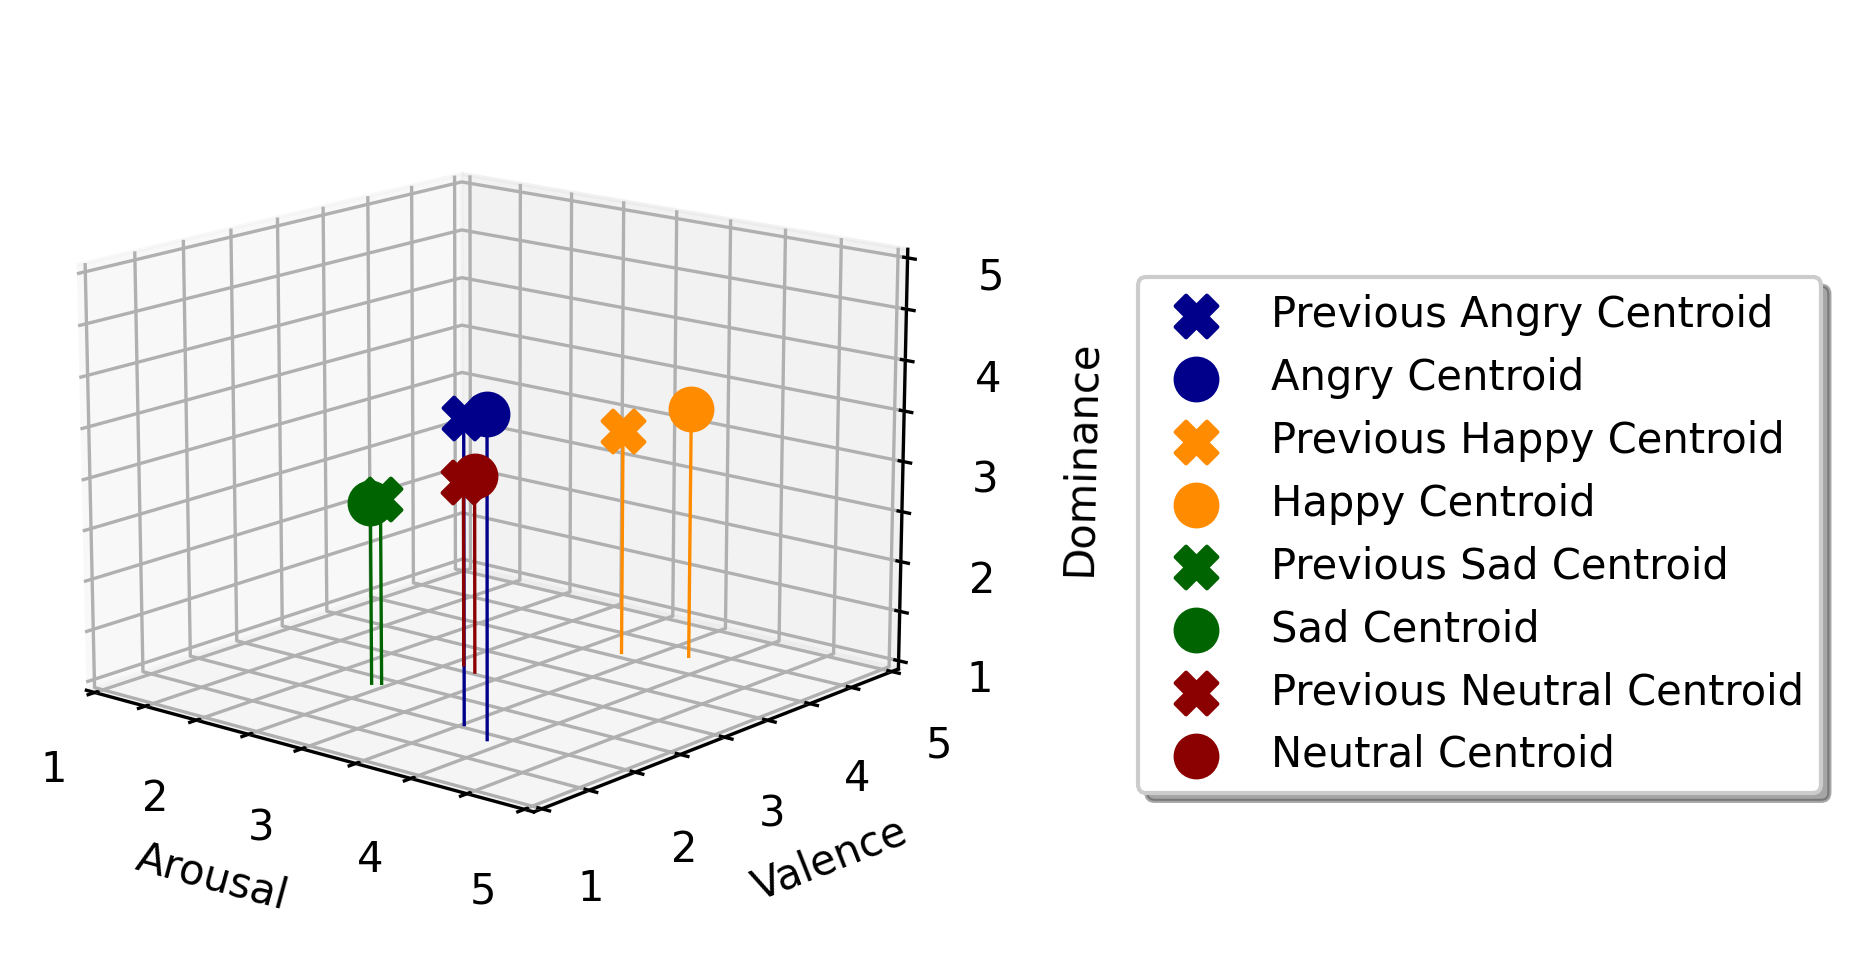

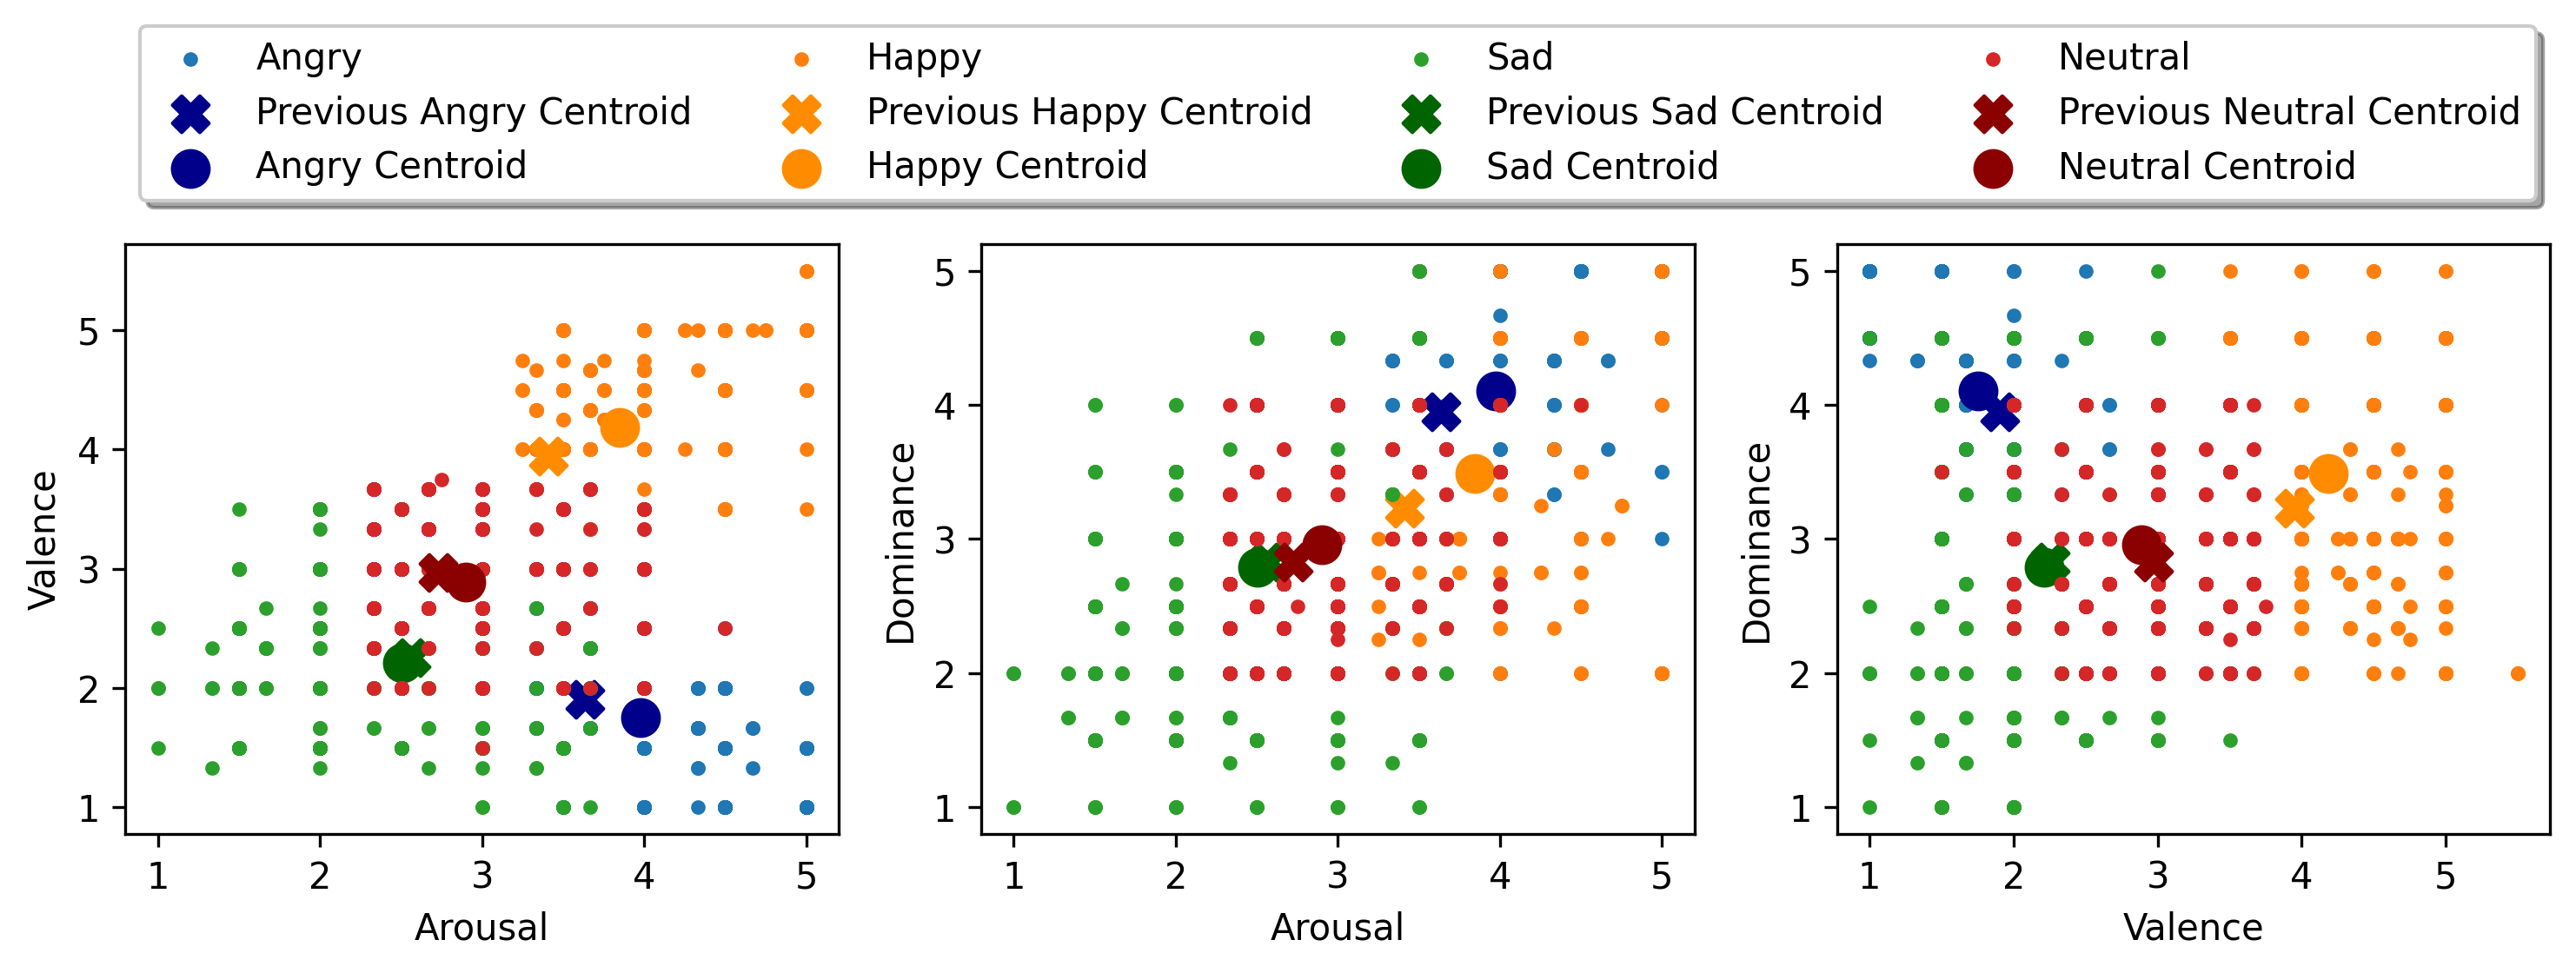

In [16]:
n_centroids = []
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    n_centroids.append(df_temp.iloc[:,6:9].mean(axis=0).values)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("Arousal")
ax.set_ylabel("Valence")
ax.set_zlabel("Dominance")
ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_xlim(1, 5)
ax.set_ylim(1, 5)
ax.set_zlim(1, 5)
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    ax.scatter(centroids[i][1],centroids[i][0],centroids[i][2], marker='X', label=f"Previous {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax.plot([centroids[i][1]]*2,[centroids[i][0]]*2, [1, centroids[i][2]], color=f"dark{colors[i]}", linewidth=0.8)
    ax.scatter(n_centroids[i][1],n_centroids[i][0],n_centroids[i][2], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax.plot([n_centroids[i][1]]*2,[n_centroids[i][0]]*2, [1, n_centroids[i][2]], color=f"dark{colors[i]}", linewidth=0.8)

ax.view_init(15, -50)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 0.75),
        ncol=1, fancybox=True, shadow=True)
plt.show()

fig = plt.figure(figsize=(12, 3))
spec = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlabel("Arousal")
ax1.set_ylabel("Valence")
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlabel("Arousal")
ax2.set_ylabel("Dominance")
ax3 = fig.add_subplot(spec[0, 2])
ax3.set_xlabel("Valence")
ax3.set_ylabel("Dominance")

for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    x = df_temp["Activation"].values
    y = df_temp["Valence"].values
    z = df_temp["Dominance"].values
    ax1.scatter(x,y, marker='.', label=emotion.title())
    ax2.scatter(x,z, marker='.', label=emotion.title())
    ax3.scatter(y,z, marker='.', label=emotion.title())
    ax1.scatter(centroids[i][1],centroids[i][0], marker='X', label=f"Previous {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(centroids[i][1],centroids[i][2], marker='X', label=f"Previous {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax3.scatter(centroids[i][0],centroids[i][2], marker='X', label=f"Previous {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax1.scatter(n_centroids[i][1],n_centroids[i][0], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(n_centroids[i][1],n_centroids[i][2], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax3.scatter(n_centroids[i][0],n_centroids[i][2], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=4, fancybox=True, shadow=True)
plt.show()

In [17]:
%config InteractiveShell.ast_node_interactivity = 'all'

Angry, Happy, Sad, Neutral

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084

Accuracy for fold 0: 60.43%
Accuracy for fold 1: 61.39%
Accuracy for fold 2: 59.31%
Accuracy for fold 3: 60.13%
Accuracy for fold 4: 58.41%

Metric             Value
-----------------  -----------
Accuracy           59.93+-1.01
F1 score macro     60.63+-0.98
Precision          61.11+-0.88
Recall             60.51+-1.08
Matthews corrcoef  0.46+-0.01


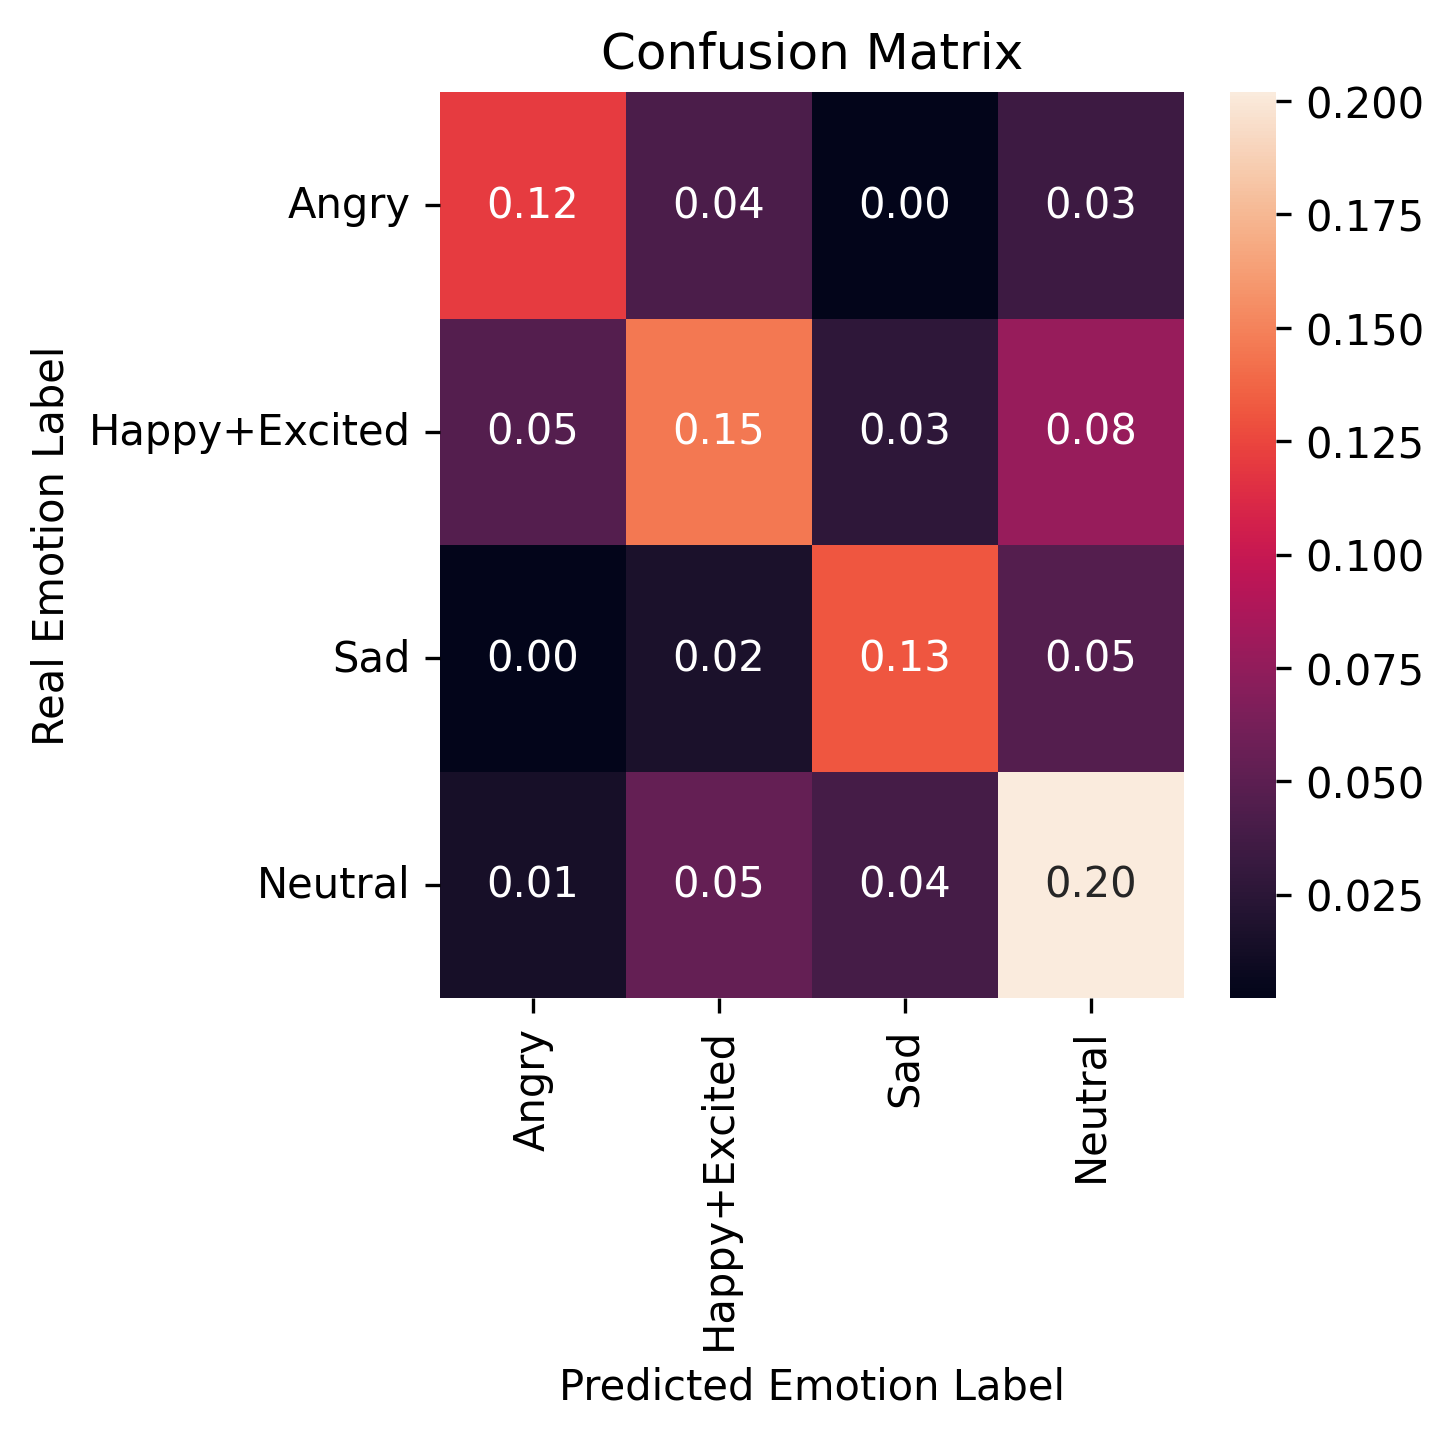

In [18]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

Angry+Sad, Neutral+Happy

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 1             1708
sad     0             1084

Accuracy for fold 0: 71.82%
Accuracy for fold 1: 74.23%
Accuracy for fold 2: 72.06%
Accuracy for fold 3: 73.69%
Accuracy for fold 4: 72.51%

Metric             Value
-----------------  -----------
Accuracy           72.86+-0.94
F1 score macro     69.84+-1.13
Precision          72.47+-1.18
Recall             69.27+-1.08
Matthews corrcoef  0.42+-0.02


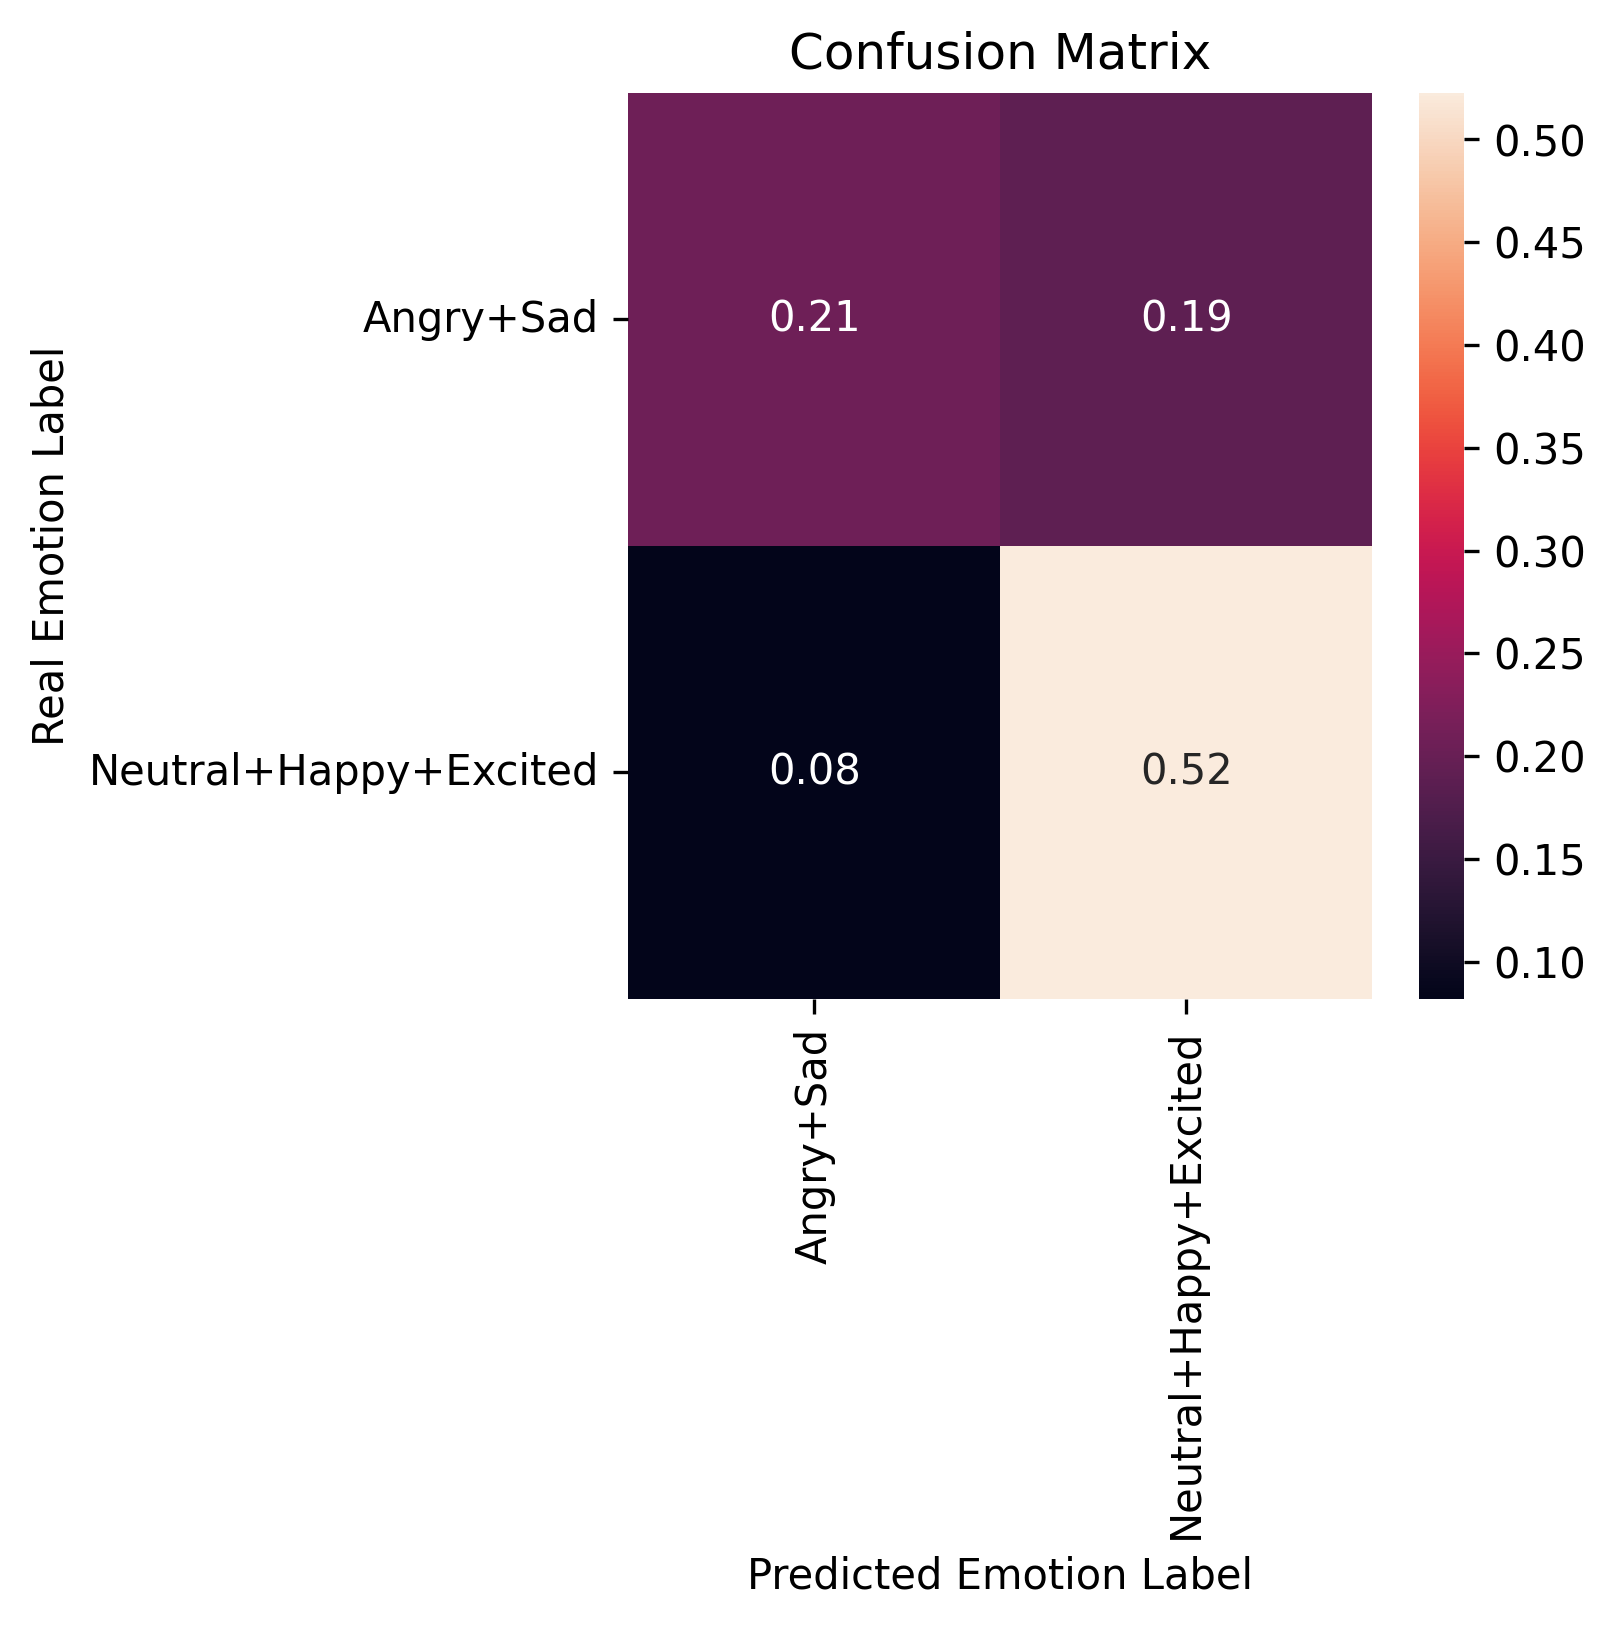

In [19]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy", results)

Angry, Happy, Sad

Number of Audio Files: 3823


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
sad     2             1084

Accuracy for fold 0: 69.54%
Accuracy for fold 1: 71.9%
Accuracy for fold 2: 69.28%
Accuracy for fold 3: 69.63%
Accuracy for fold 4: 71.47%

Metric             Value
-----------------  -----------
Accuracy           70.36+-1.09
F1 score macro     70.73+-1.06
Precision          71.36+-1.33
Recall             70.35+-0.89
Matthews corrcoef  0.54+-0.02


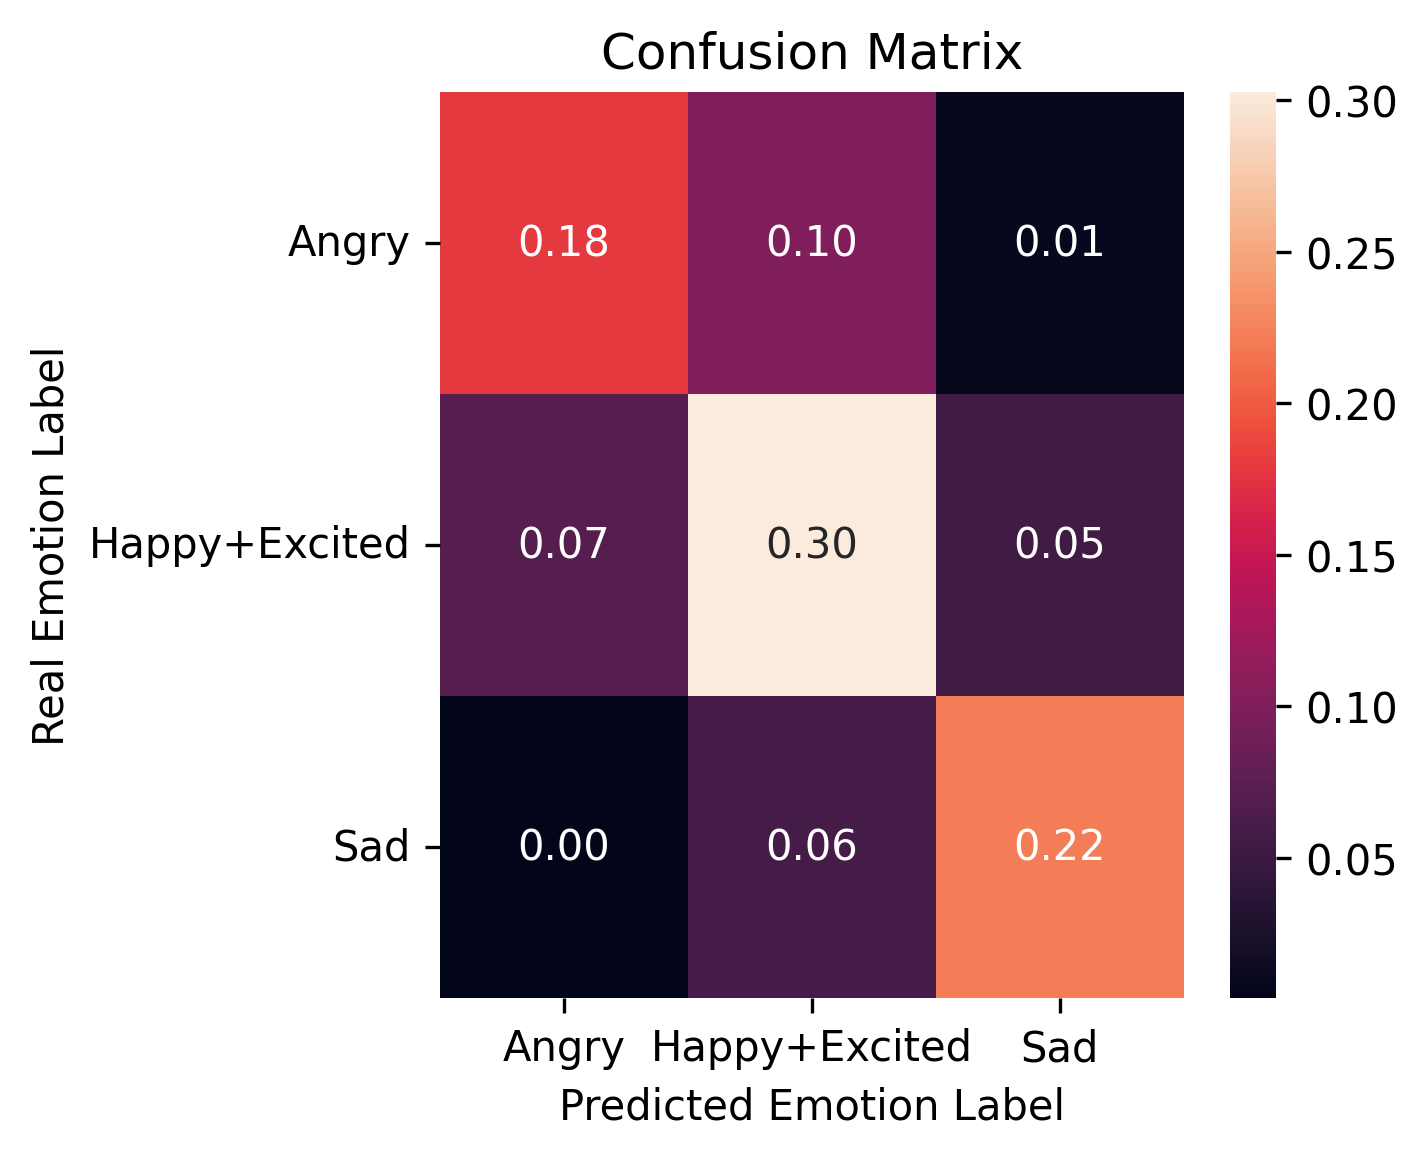

In [20]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry',  'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad", results)

Angry, Happy, Neutral

Number of Audio Files: 4447


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 2             1708

Accuracy for fold 0: 62.92%
Accuracy for fold 1: 64.38%
Accuracy for fold 2: 64.34%
Accuracy for fold 3: 65.92%
Accuracy for fold 4: 64.45%

Metric             Value
-----------------  -----------
Accuracy           64.4+-0.95
F1 score macro     63.8+-1.21
Precision          64.48+-1.37
Recall             63.84+-1.05
Matthews corrcoef  0.46+-0.01


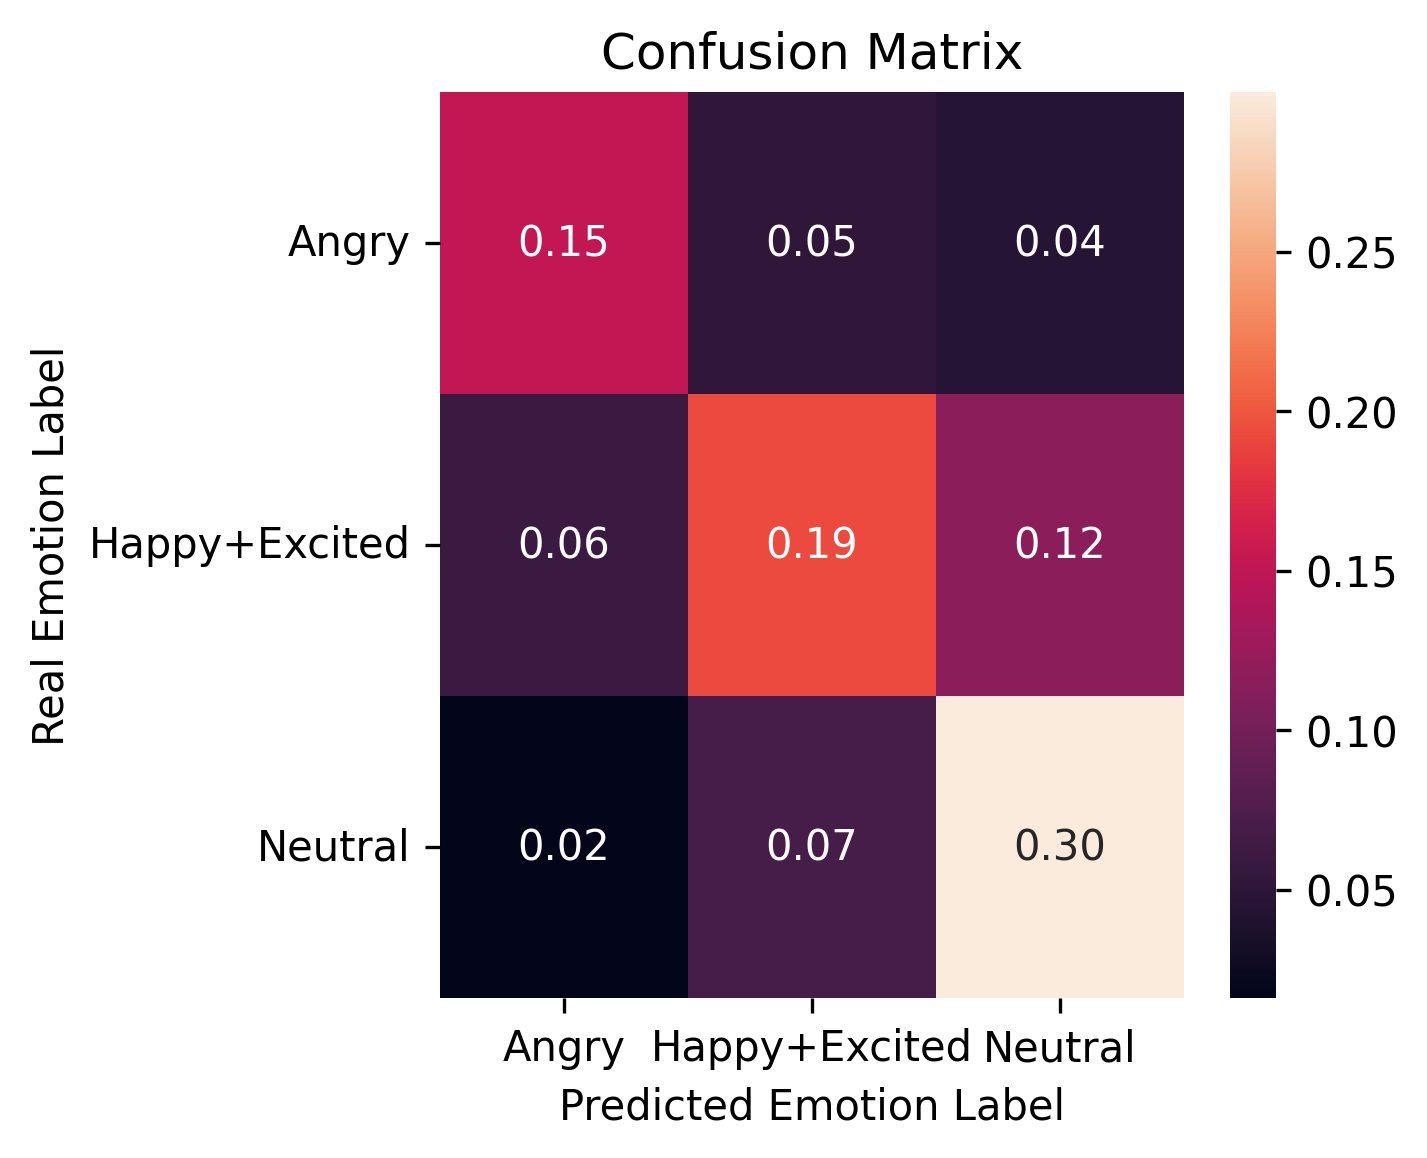

In [21]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Happy, Neutral", results)

Sad, Happy, Neutral

Number of Audio Files: 4428


Emotion
                     count
Emotion Emotion_Id        
happy   1             1636
neutral 2             1708
sad     0             1084

Accuracy for fold 0: 64.0%
Accuracy for fold 1: 65.58%
Accuracy for fold 2: 67.27%
Accuracy for fold 3: 64.52%
Accuracy for fold 4: 65.65%

Metric             Value
-----------------  -----------
Accuracy           65.4+-1.12
F1 score macro     65.59+-1.12
Precision          65.75+-1.13
Recall             65.54+-1.11
Matthews corrcoef  0.47+-0.02


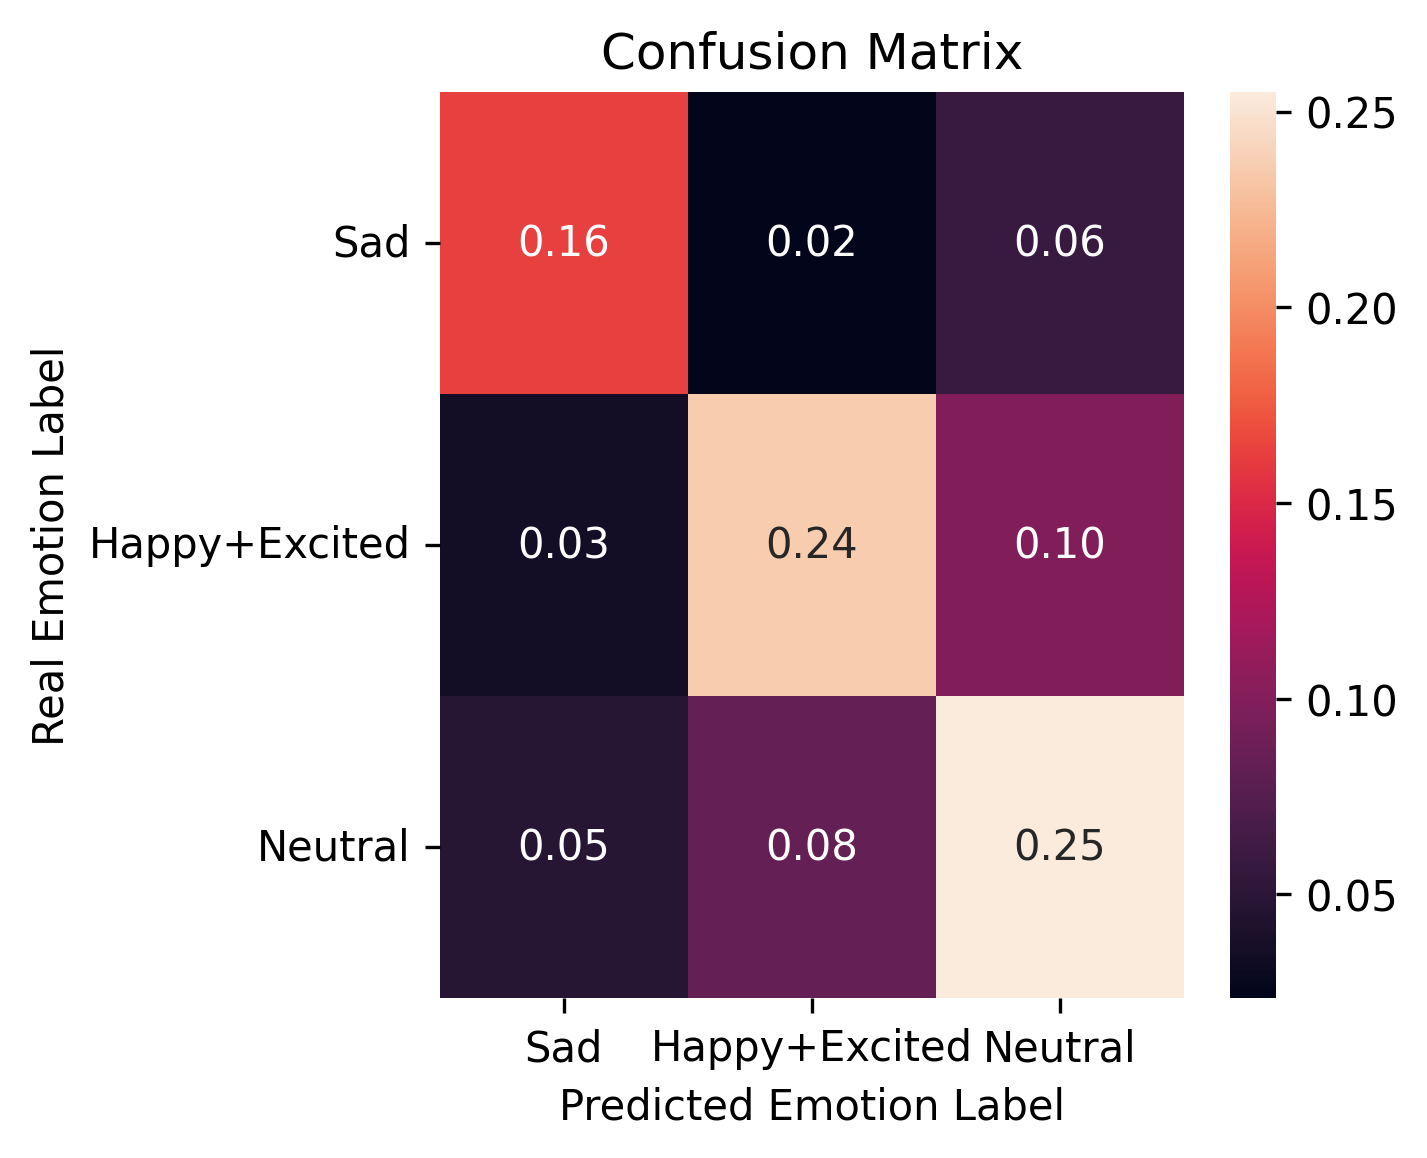

In [22]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad, Happy, Neutral", results)

Angry, Sad, Neutral

Number of Audio Files: 3895


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
neutral 1             1708
sad     2             1084

Accuracy for fold 0: 73.94%
Accuracy for fold 1: 75.48%
Accuracy for fold 2: 74.07%
Accuracy for fold 3: 74.58%
Accuracy for fold 4: 72.02%

Metric             Value
-----------------  -----------
Accuracy           74.02+-1.14
F1 score macro     74.16+-1.19
Precision          75.61+-1.43
Recall             73.2+-1.21
Matthews corrcoef  0.6+-0.02


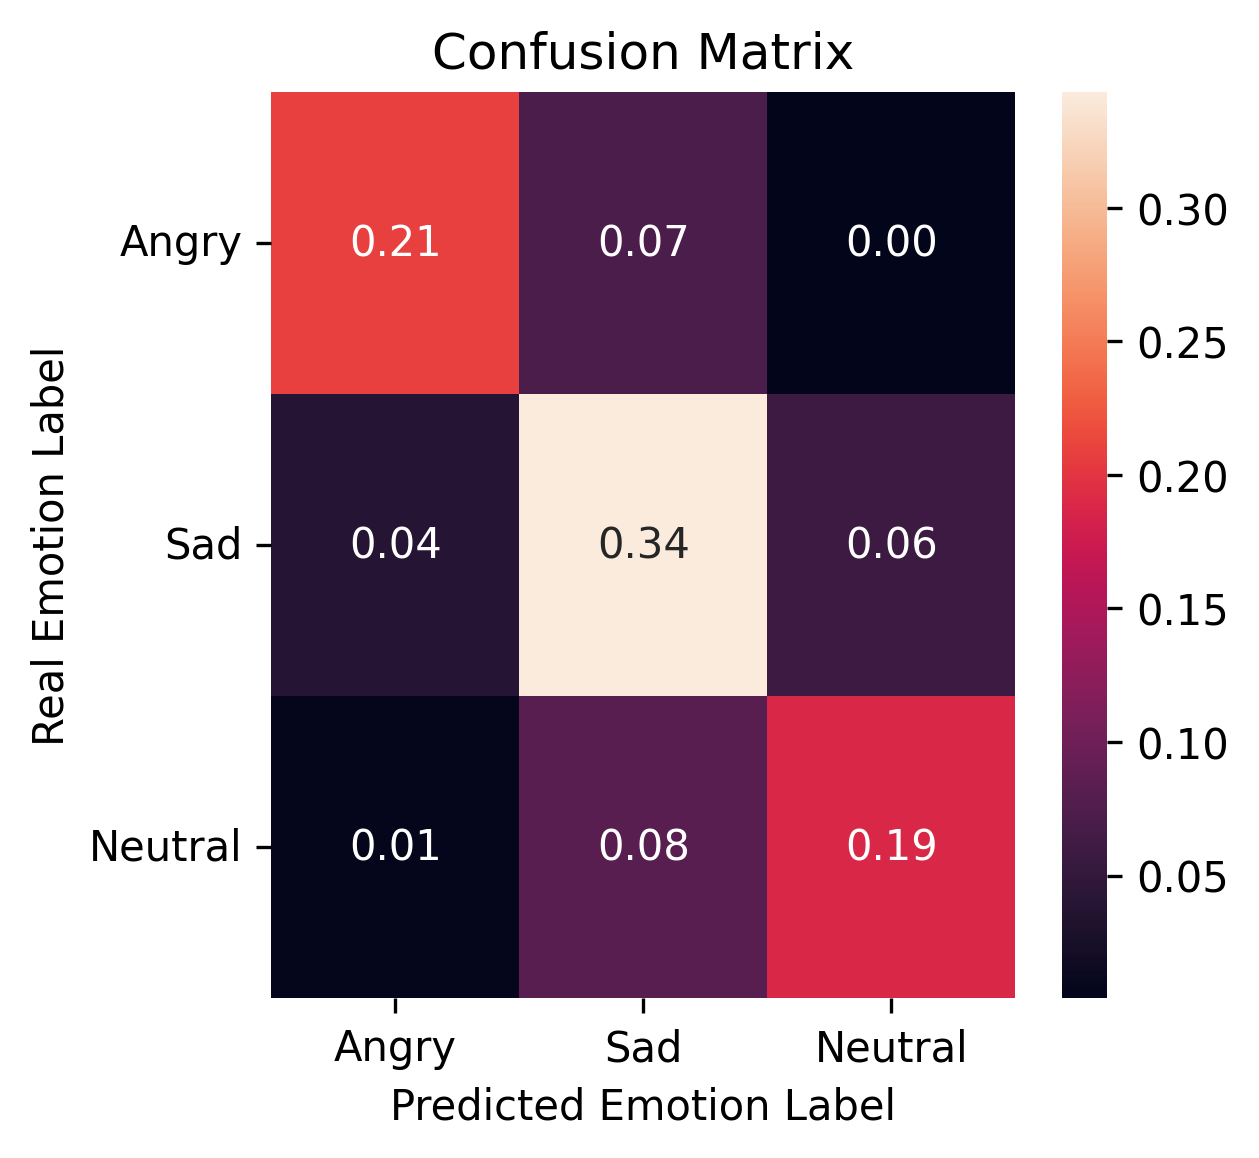

In [23]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral", results)

Angry+Sad, Happy

Number of Audio Files: 3823


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
sad     0             1084

Accuracy for fold 0: 72.68%
Accuracy for fold 1: 74.51%
Accuracy for fold 2: 72.68%
Accuracy for fold 3: 70.16%
Accuracy for fold 4: 71.99%

Metric             Value
-----------------  -----------
Accuracy           72.4+-1.4
F1 score macro     71.39+-1.62
Precision          71.91+-1.39
Recall             71.18+-1.63
Matthews corrcoef  0.43+-0.03


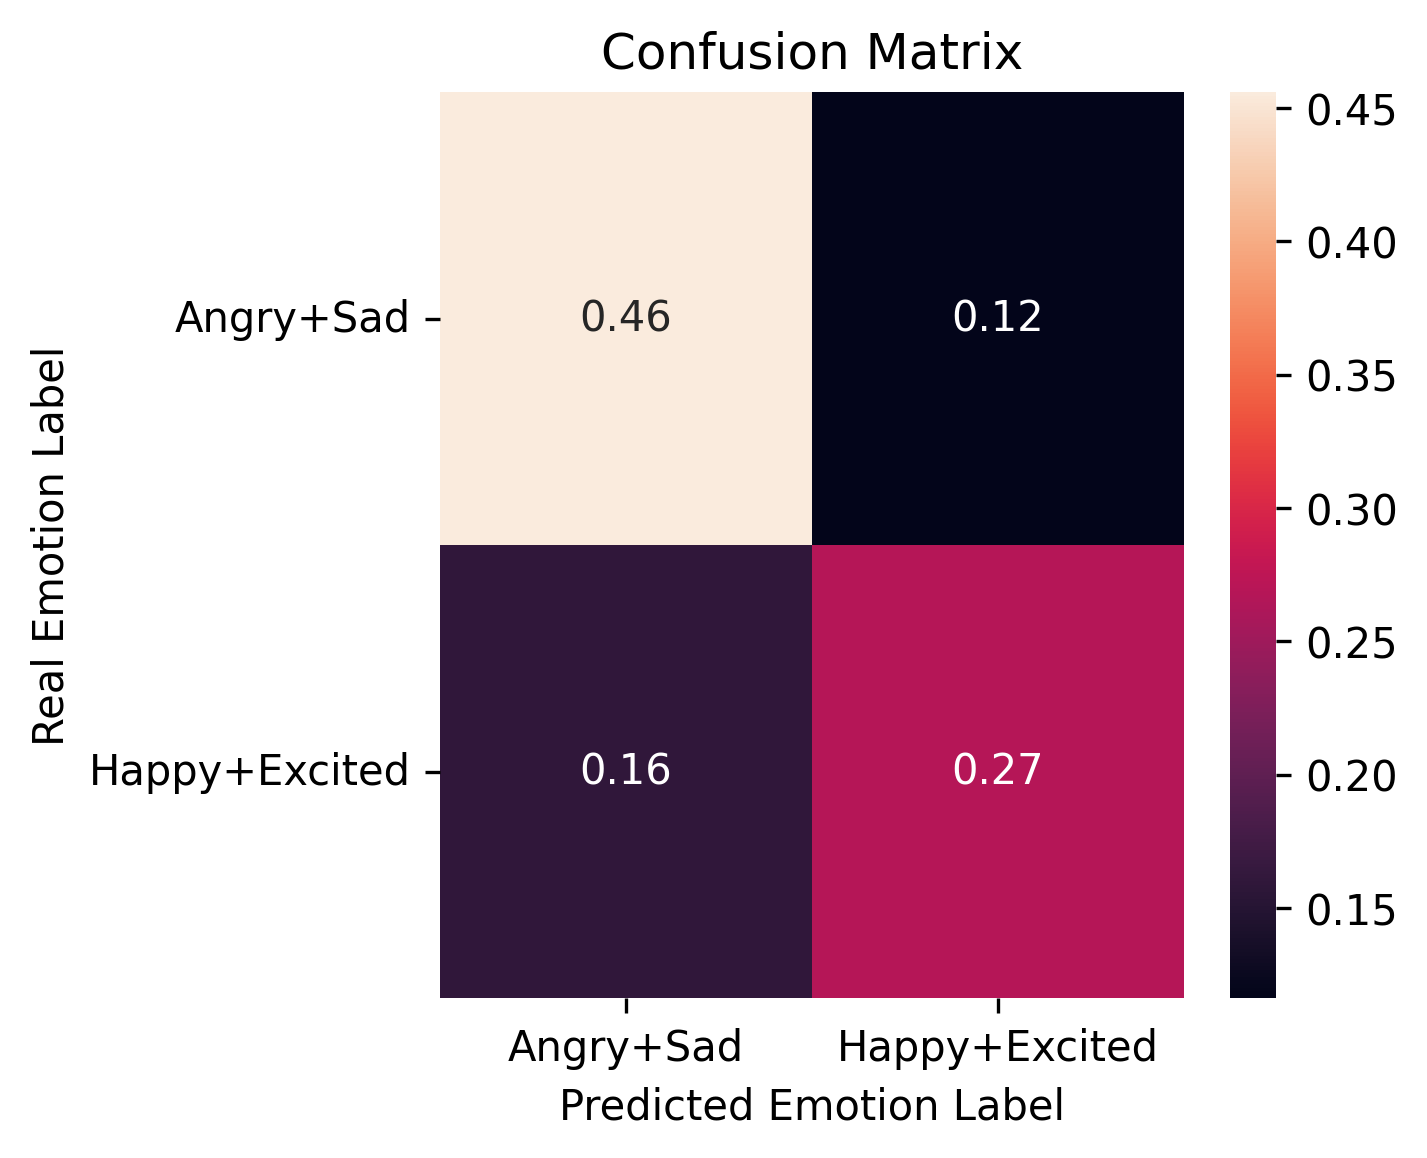

In [24]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy", results)

Angry, Sad

Number of Audio Files: 2187


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
sad     1             1084

Accuracy for fold 0: 91.1%
Accuracy for fold 1: 90.41%
Accuracy for fold 2: 93.59%
Accuracy for fold 3: 92.45%
Accuracy for fold 4: 89.47%

Metric             Value
-----------------  -----------
Accuracy           91.4+-1.46
F1 score macro     91.4+-1.47
Precision          91.46+-1.35
Recall             91.39+-1.47
Matthews corrcoef  0.83+-0.03


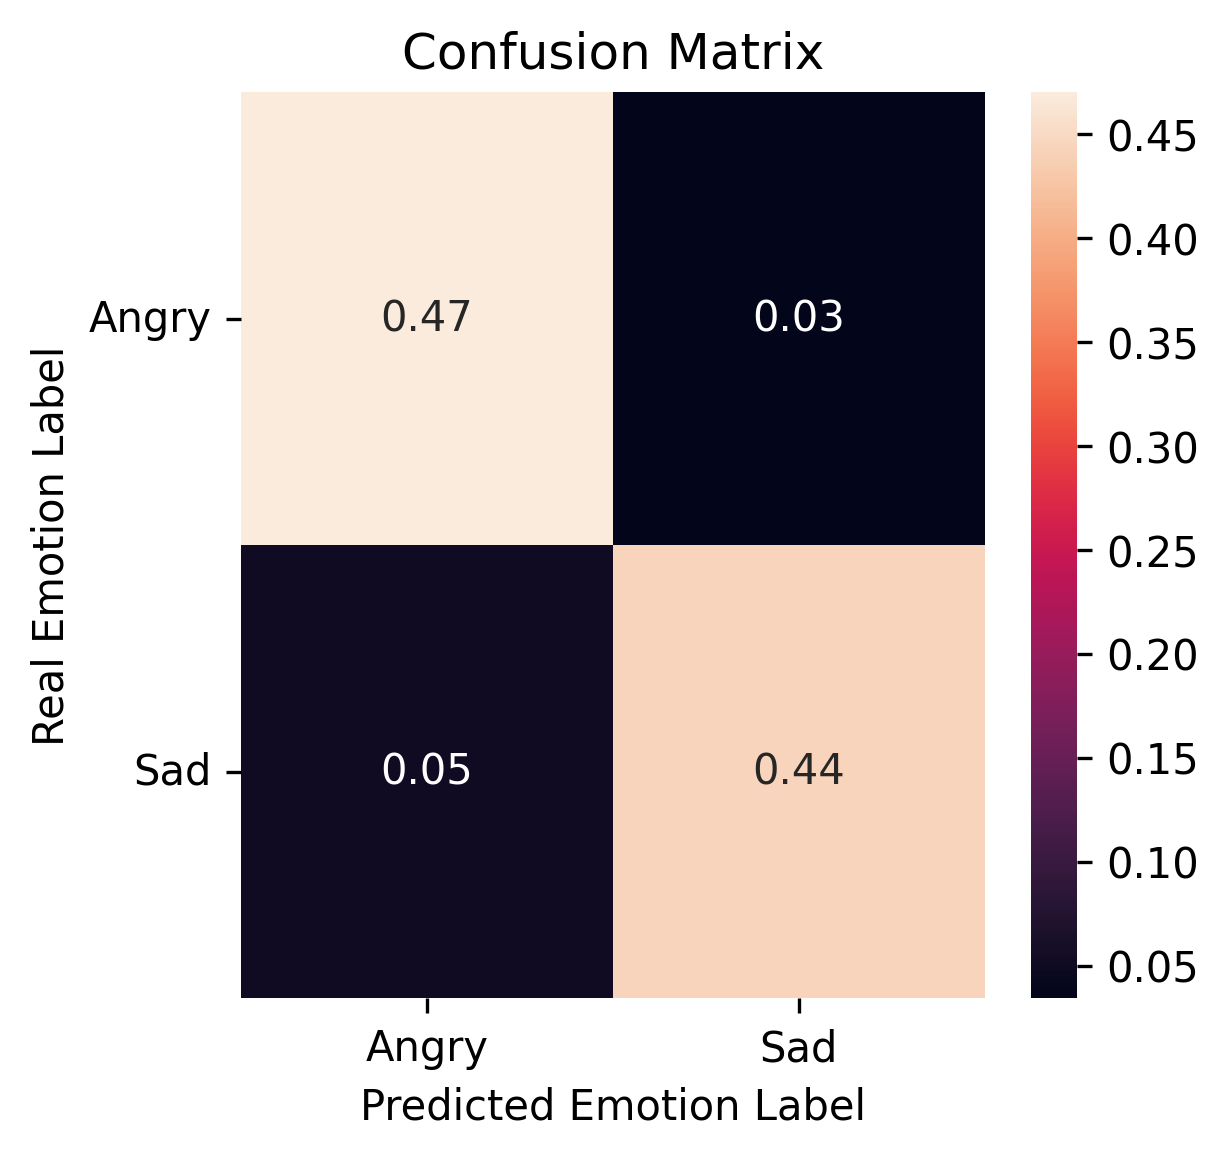

In [25]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad", results)

Angry, Neutral

Number of Audio Files: 2811


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
neutral 1             1708

Accuracy for fold 0: 84.19%
Accuracy for fold 1: 82.56%
Accuracy for fold 2: 84.16%
Accuracy for fold 3: 85.23%
Accuracy for fold 4: 84.52%

Metric             Value
-----------------  -----------
Accuracy           84.13+-0.88
F1 score macro     82.98+-0.93
Precision          84.03+-1.03
Recall             82.34+-0.97
Matthews corrcoef  0.66+-0.02


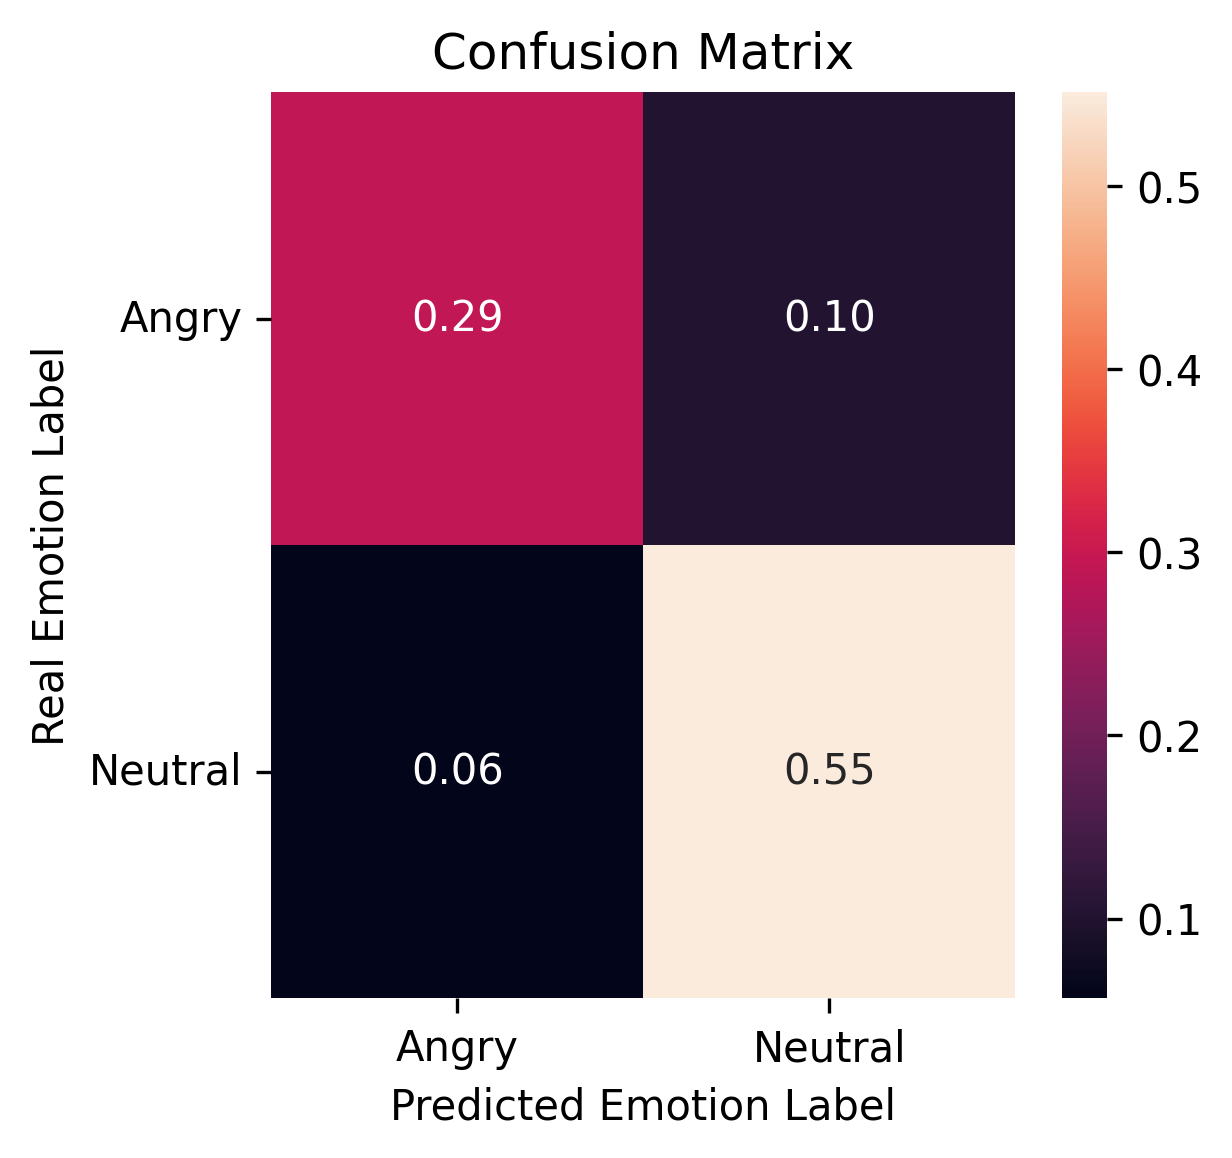

In [26]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Neutral", results)

Angry, Happy

Number of Audio Files: 2739


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636

Accuracy for fold 0: 71.9%
Accuracy for fold 1: 75.55%
Accuracy for fold 2: 72.81%
Accuracy for fold 3: 75.73%
Accuracy for fold 4: 77.33%

Metric             Value
-----------------  -----------
Accuracy           74.66+-2.01
F1 score macro     73.1+-2.03
Precision          73.84+-2.23
Recall             72.72+-1.95
Matthews corrcoef  0.47+-0.04


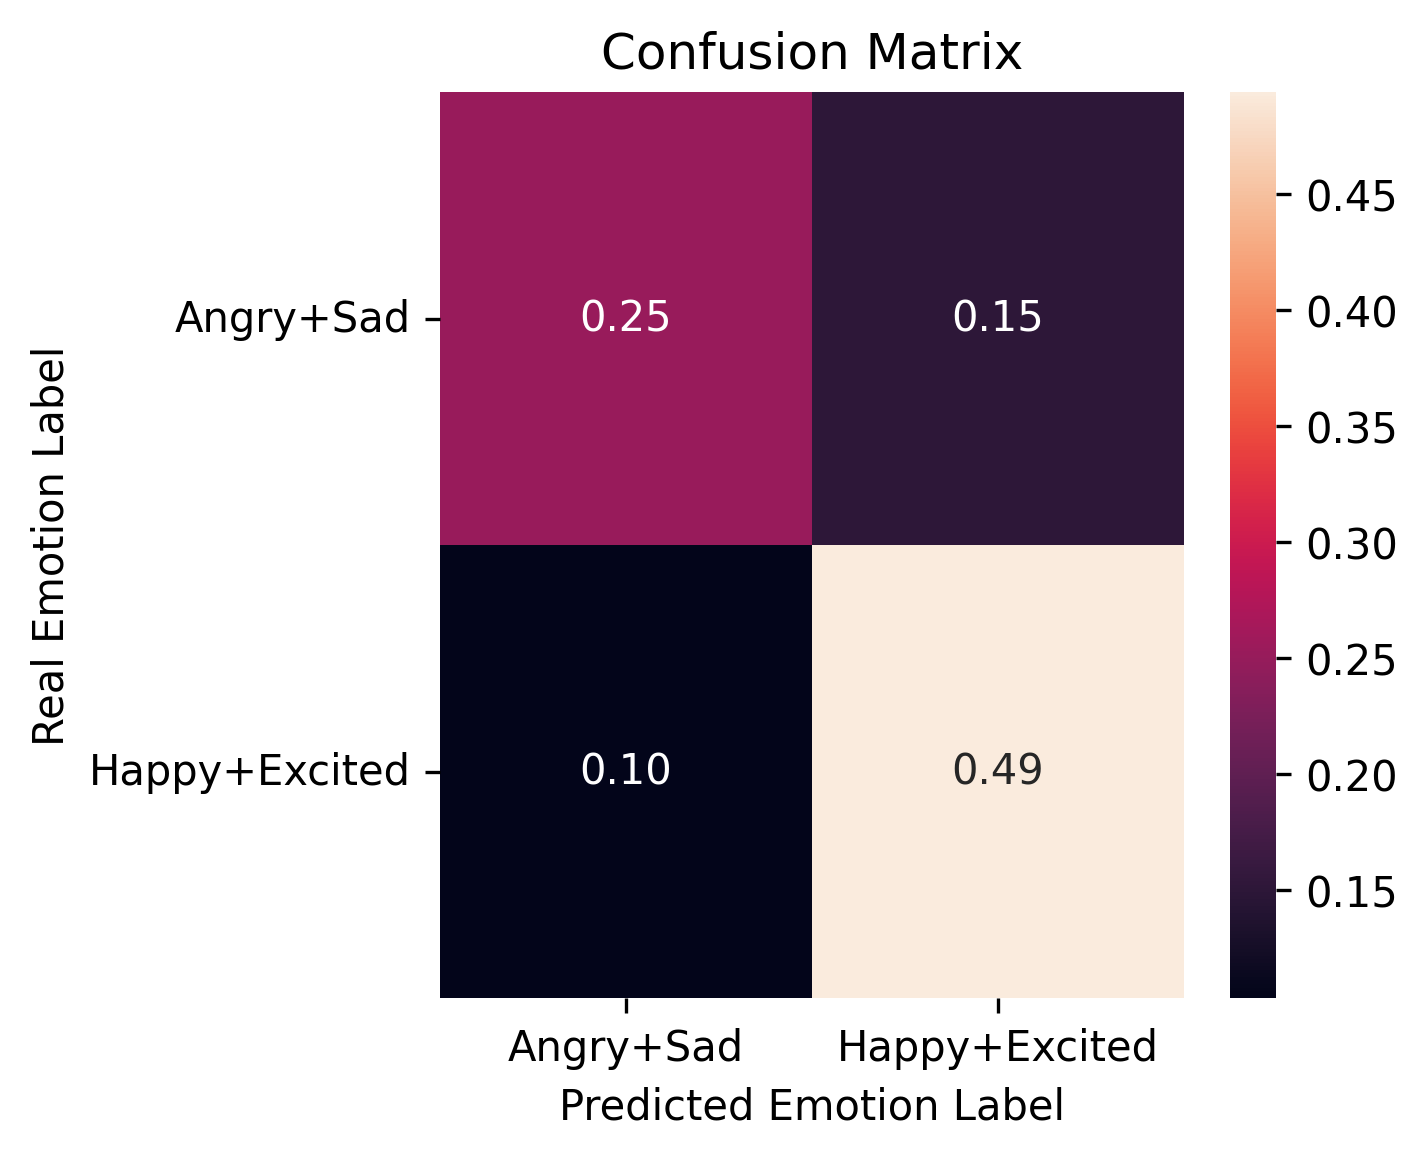

In [27]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy", results)

Sad, Neutral

Number of Audio Files: 2792


Emotion
                     count
Emotion Emotion_Id        
neutral 1             1708
sad     0             1084

Accuracy for fold 0: 78.89%
Accuracy for fold 1: 78.35%
Accuracy for fold 2: 77.78%
Accuracy for fold 3: 82.08%
Accuracy for fold 4: 80.47%

Metric             Value
-----------------  -----------
Accuracy           79.51+-1.57
F1 score macro     77.98+-1.71
Precision          78.77+-1.68
Recall             77.49+-1.72
Matthews corrcoef  0.56+-0.03


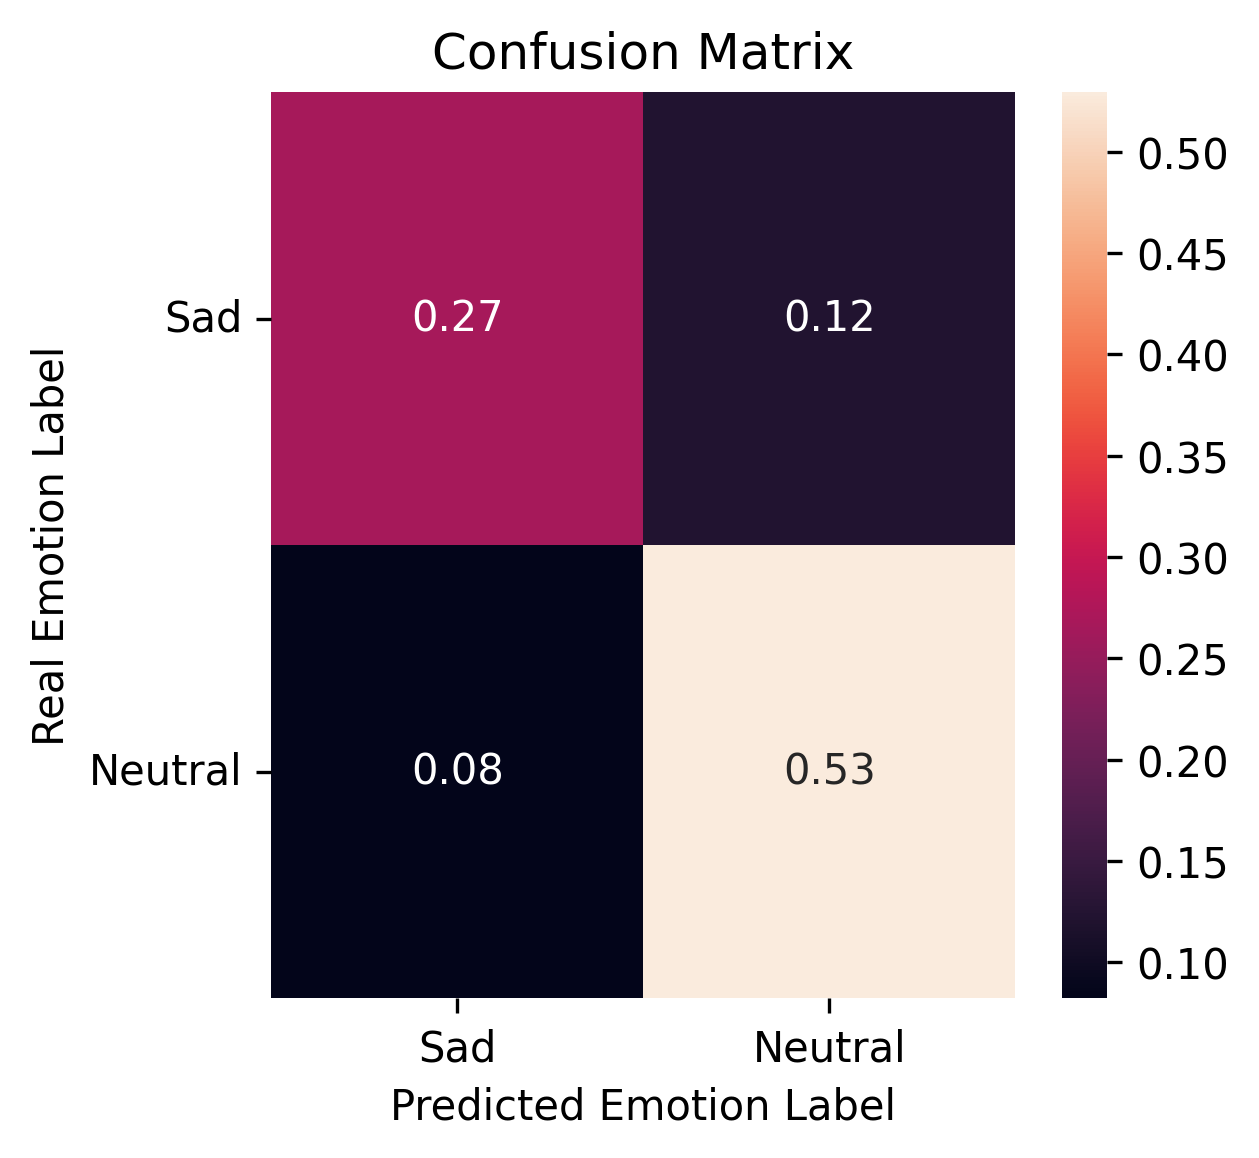

In [28]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})


results = categorical_cross_validation(get_new_model, "Sad, Neutral", results)

Sad, Happy

Number of Audio Files: 2720


Emotion
                     count
Emotion Emotion_Id        
happy   1             1636
sad     0             1084

Accuracy for fold 0: 83.09%
Accuracy for fold 1: 82.72%
Accuracy for fold 2: 83.09%
Accuracy for fold 3: 82.72%
Accuracy for fold 4: 86.4%

Metric             Value
-----------------  -----------
Accuracy           83.6+-1.41
F1 score macro     82.87+-1.44
Precision          82.93+-1.53
Recall             82.82+-1.38
Matthews corrcoef  0.66+-0.03


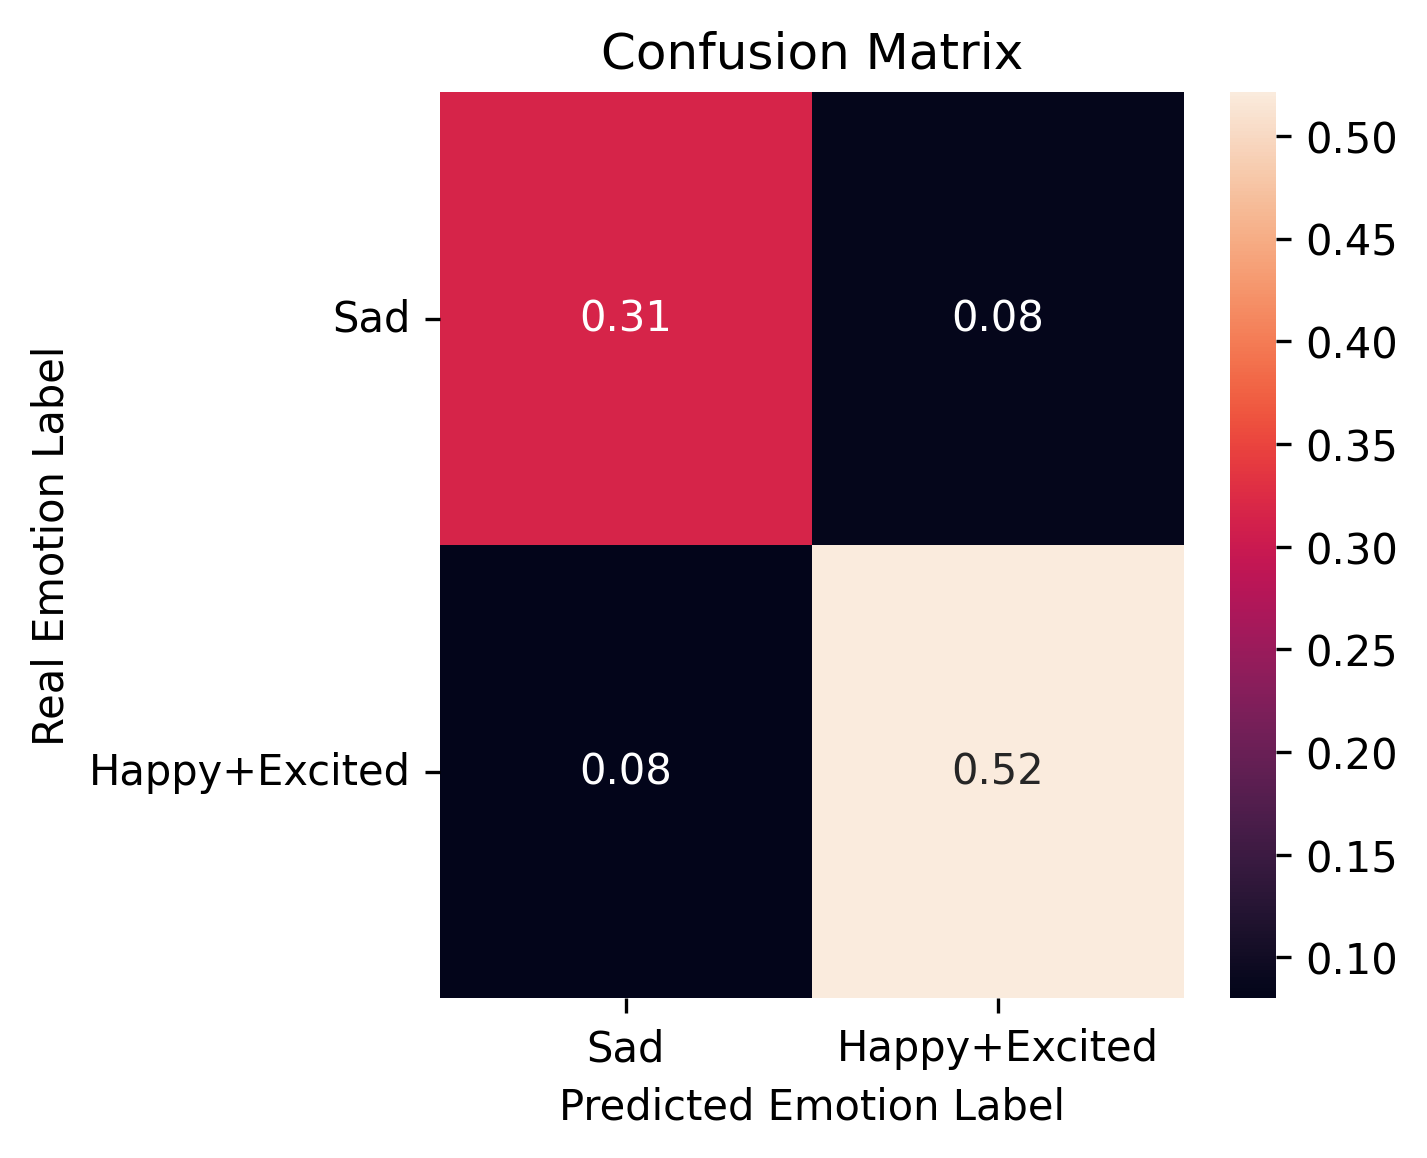

In [29]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad, Happy", results)

Neutral, Happy

Number of Audio Files: 3344


Emotion
                     count
Emotion Emotion_Id        
happy   1             1636
neutral 0             1708

Accuracy for fold 0: 68.16%
Accuracy for fold 1: 73.39%
Accuracy for fold 2: 72.2%
Accuracy for fold 3: 74.59%
Accuracy for fold 4: 74.55%

Metric             Value
-----------------  -----------
Accuracy           72.58+-2.38
F1 score macro     72.43+-2.43
Precision          72.81+-2.34
Recall             72.45+-2.39
Matthews corrcoef  0.45+-0.04


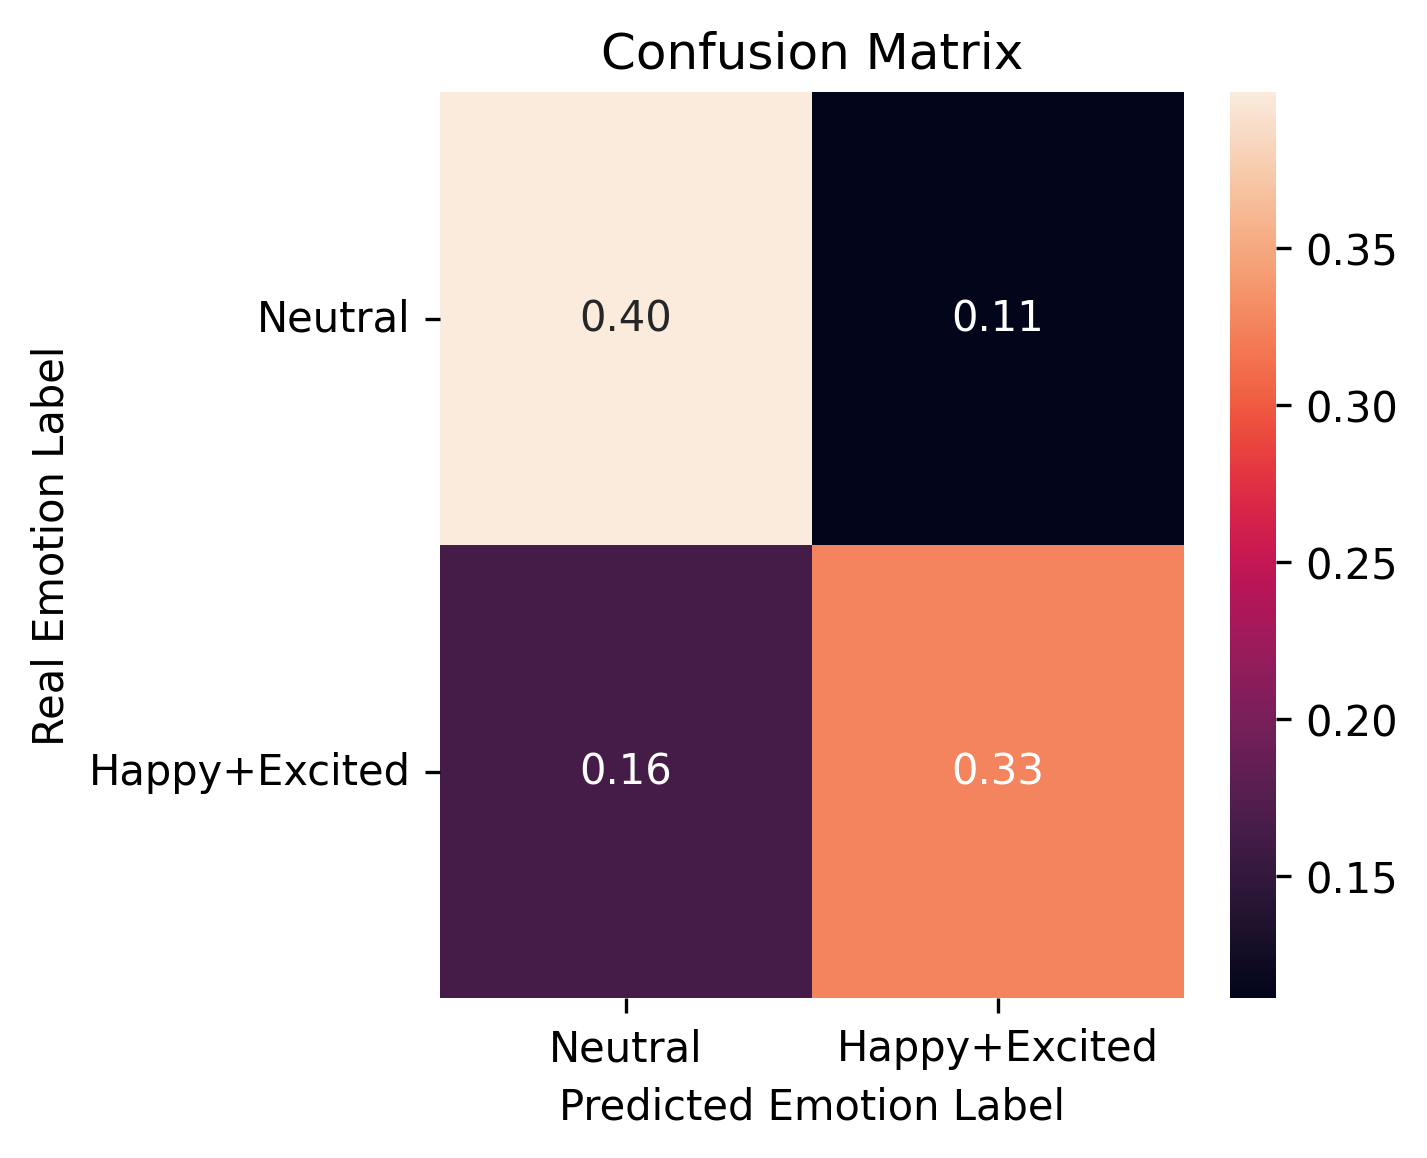

In [30]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Neutral, Happy", results)

In [31]:
display(HTML('<a href="https://www.researchgate.net/figure/Russel-circumplex-model-of-emotion-16-The-vertical-axis-represents-the-activation_fig1_328836839"><img src="https://www.researchgate.net/profile/Rab-Nawaz-12/publication/328836839/figure/fig1/AS:702472028971012@1544493791715/Russel-circumplex-model-of-emotion-16-The-vertical-axis-represents-the-activation.ppm" alt="Russel circumplex model of emotion [16]. The vertical axis represents the activation level (Arousal) and Horizontal axis represents the pleasure level (Valence) II."/></a>'))

Arousal plane - Happy+Angry, Neutral, Sad

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   0             1636
neutral 1             1708
sad     2             1084

Accuracy for fold 0: 68.47%
Accuracy for fold 1: 68.44%
Accuracy for fold 2: 66.73%
Accuracy for fold 3: 69.35%
Accuracy for fold 4: 69.71%

Metric             Value
-----------------  -----------
Accuracy           68.54+-1.03
F1 score macro     66.0+-1.18
Precision          66.31+-1.28
Recall             65.89+-1.18
Matthews corrcoef  0.49+-0.02


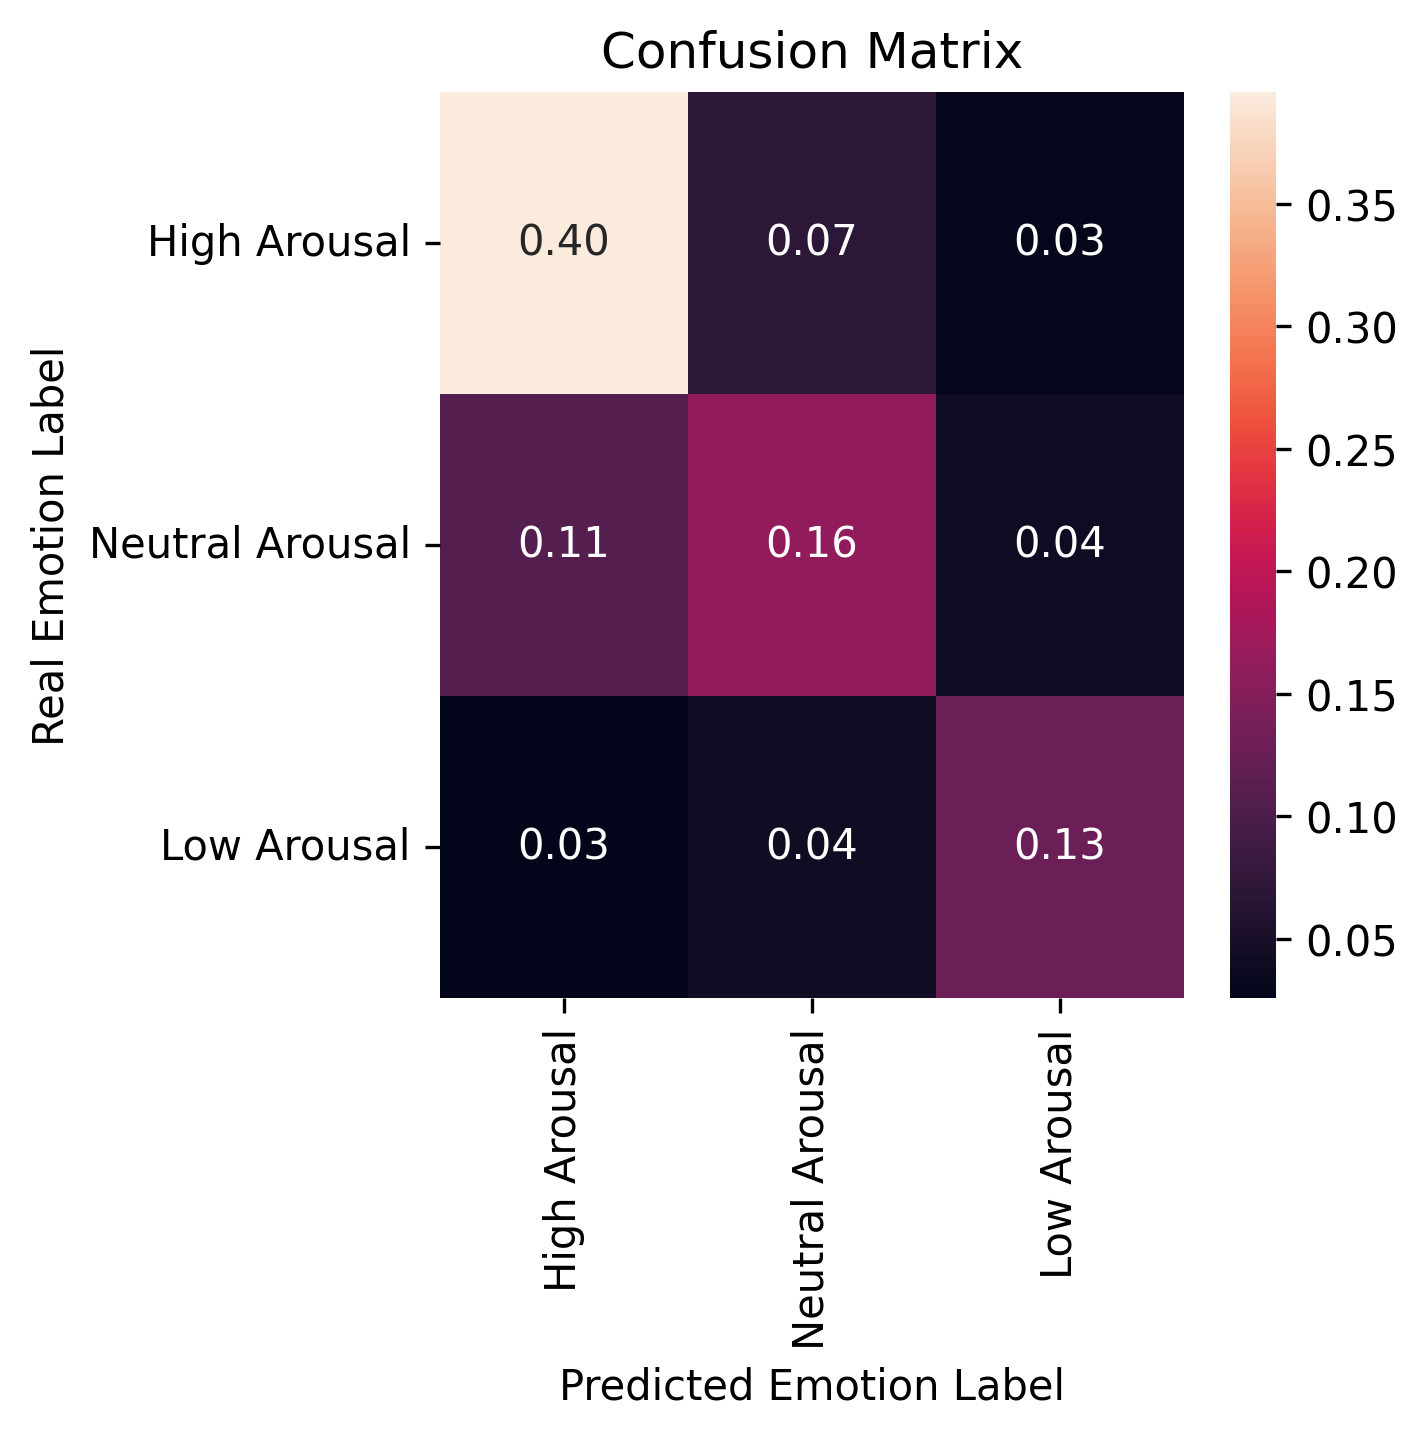

In [32]:
# Research article to corroborate this result: 10.21437/ICSLP.2002-557
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "High Arousal, Neutral Arousal, Low Arousal", results)

Valence Plane - Happy, Neutral, Sad+Angry

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   2             1103
happy   0             1636
neutral 1             1708
sad     2             1084

Accuracy for fold 0: 59.17%
Accuracy for fold 1: 61.03%
Accuracy for fold 2: 59.22%
Accuracy for fold 3: 60.13%
Accuracy for fold 4: 61.21%

Metric             Value
-----------------  -----------
Accuracy           60.15+-0.86
F1 score macro     58.94+-0.76
Precision          59.53+-0.76
Recall             58.99+-0.75
Matthews corrcoef  0.39+-0.01


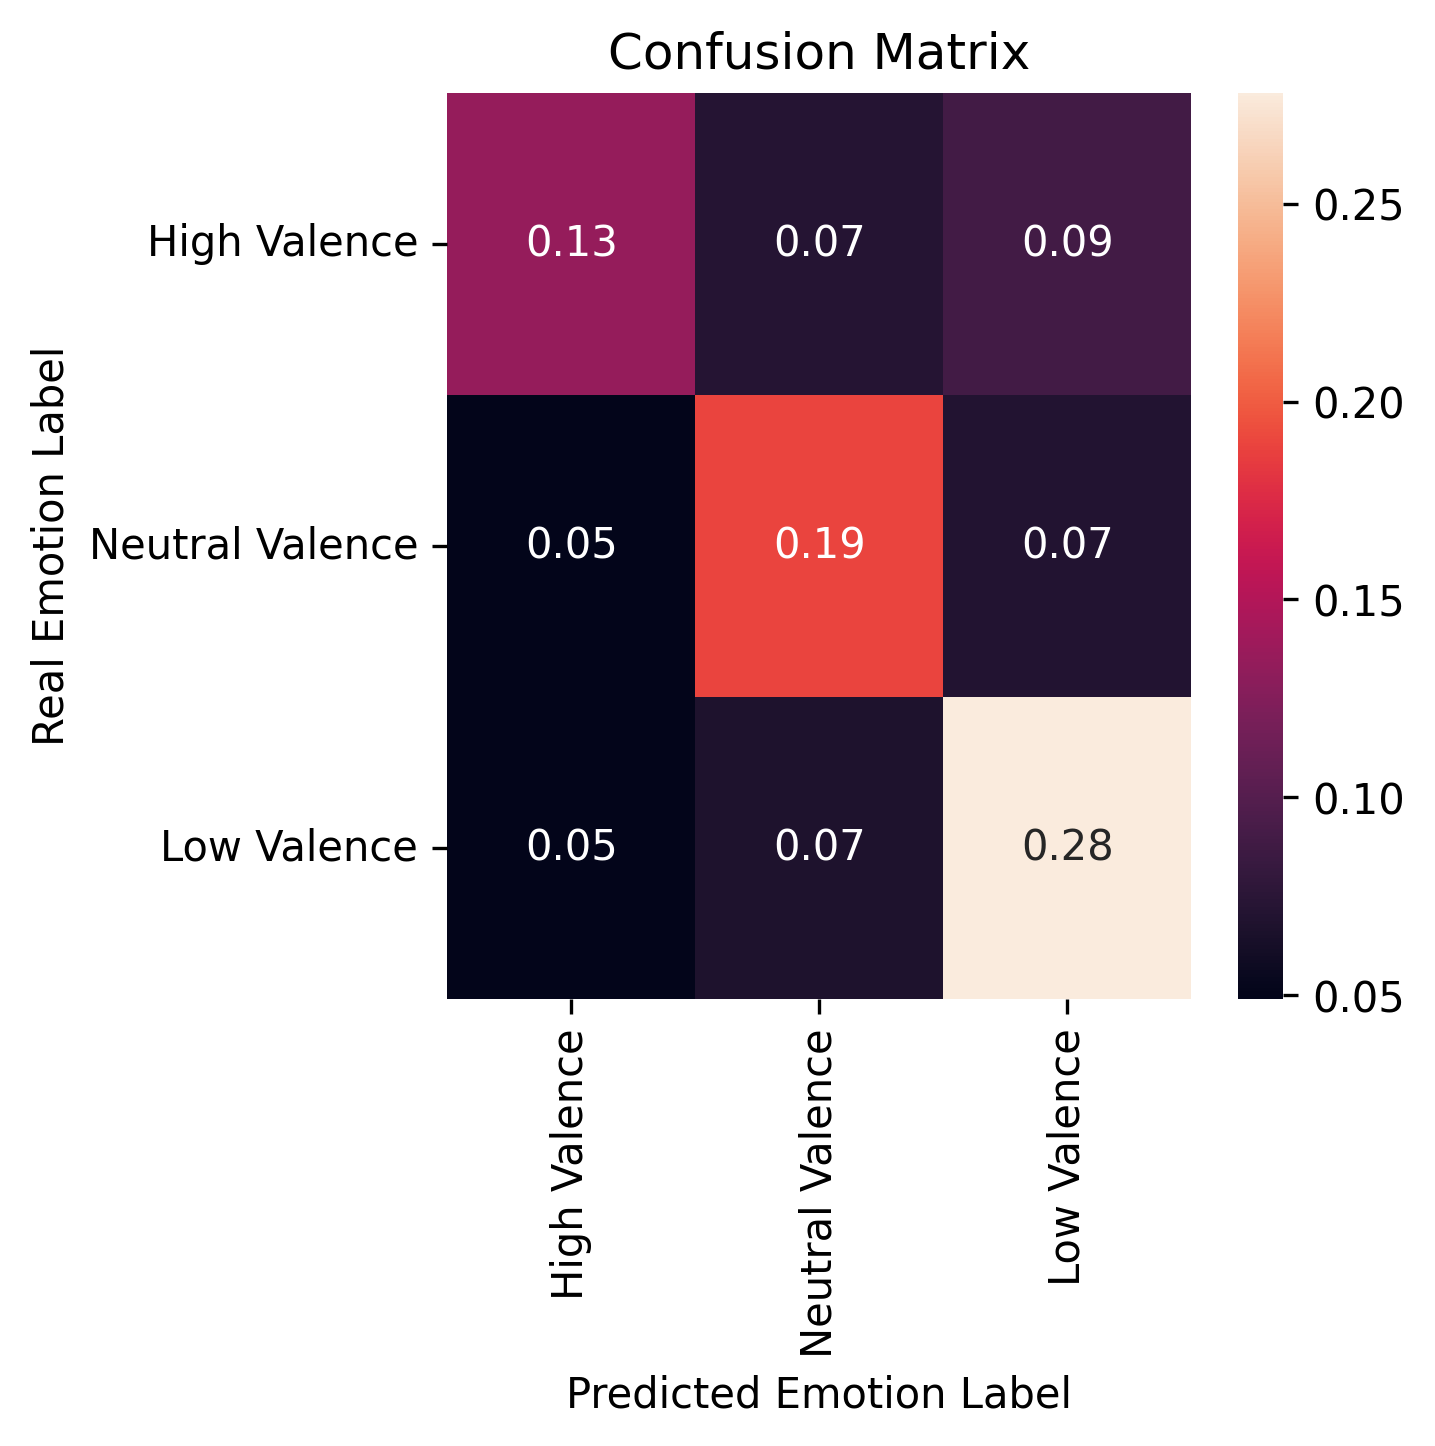

In [33]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "High Valence, Neutral Valence, Low Valence", results)

Results

In [34]:
tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='html'
        )

print(tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='latex_booktabs'
        ))


'<table>\n<thead>\n<tr><th>Classification Labels                     </th><th style="text-align: right;">  Total Data</th><th>Accuracy   </th><th>Macro F1   </th><th>Precision  </th><th>Recall     </th><th>MCC.      </th></tr>\n</thead>\n<tbody>\n<tr><td>Angry, Happy, Sad, Neutral                </td><td style="text-align: right;">        5531</td><td>59.01+-1.02</td><td>59.5+-0.97 </td><td>59.16+-0.95</td><td>60.88+-1.03</td><td>0.45+-0.01</td></tr>\n<tr><td>Angry, Happy, Sad, Neutral                </td><td style="text-align: right;">        4816</td><td>63.79+-0.85</td><td>64.02+-0.87</td><td>64.82+-0.86</td><td>63.79+-0.89</td><td>0.51+-0.01</td></tr>\n<tr><td>Angry, Happy, Sad, Neutral                </td><td style="text-align: right;">        4816</td><td>62.67+-0.99</td><td>63.02+-1.01</td><td>62.52+-1.09</td><td>64.25+-0.86</td><td>0.5+-0.01 </td></tr>\n<tr><td>Angry, Happy, Sad, Neutral                </td><td style="text-align: right;">        3914</td><td>67.78+-1.93</td><td>66.45+-2.07</td><td>67.92+-1.98</td><td>66.51+-1.92</td><td>0.57+-0.02</td></tr>\n<tr><td>Angry, Happy, Sad, Neutral                </td><td style="text-align: right;">        3914</td><td>67.04+-1.9 </td><td>66.18+-1.94</td><td>66.33+-1.78</td><td>66.51+-1.96</td><td>0.56+-0.03</td></tr>\n<tr><td>Angry, Happy+Excited, Sad, Neutral        </td><td style="text-align: right;">        5531</td><td>59.93+-1.01</td><td>60.63+-0.98</td><td>61.11+-0.88</td><td>60.51+-1.08</td><td>0.46+-0.01</td></tr>\n<tr><td>Angry+Sad, Neutral+Happy+Excited          </td><td style="text-align: right;">        5531</td><td>72.86+-0.94</td><td>69.84+-1.13</td><td>72.47+-1.18</td><td>69.27+-1.08</td><td>0.42+-0.02</td></tr>\n<tr><td>Angry, Happy+Excited, Sad                 </td><td style="text-align: right;">        3823</td><td>70.36+-1.09</td><td>70.73+-1.06</td><td>71.36+-1.33</td><td>70.35+-0.89</td><td>0.54+-0.02</td></tr>\n<tr><td>Angry, Happy+Excited, Neutral             </td><td style="text-align: right;">        4447</td><td>64.4+-0.95 </td><td>63.8+-1.21 </td><td>64.48+-1.37</td><td>63.84+-1.05</td><td>0.46+-0.01</td></tr>\n<tr><td>Sad, Happy+Excited, Neutral               </td><td style="text-align: right;">        4428</td><td>65.4+-1.12 </td><td>65.59+-1.12</td><td>65.75+-1.13</td><td>65.54+-1.11</td><td>0.47+-0.02</td></tr>\n<tr><td>Angry, Sad, Neutral                       </td><td style="text-align: right;">        3895</td><td>74.02+-1.14</td><td>74.16+-1.19</td><td>75.61+-1.43</td><td>73.2+-1.21 </td><td>0.6+-0.02 </td></tr>\n<tr><td>Angry+Sad, Happy+Excited                  </td><td style="text-align: right;">        3823</td><td>72.4+-1.4  </td><td>71.39+-1.62</td><td>71.91+-1.39</td><td>71.18+-1.63</td><td>0.43+-0.03</td></tr>\n<tr><td>Angry, Sad                                </td><td style="text-align: right;">        2187</td><td>91.4+-1.46 </td><td>91.4+-1.47 </td><td>91.46+-1.35</td><td>91.39+-1.47</td><td>0.83+-0.03</td></tr>\n<tr><td>Angry, Neutral                            </td><td style="text-align: right;">        2811</td><td>84.13+-0.88</td><td>82.98+-0.93</td><td>84.03+-1.03</td><td>82.34+-0.97</td><td>0.66+-0.02</td></tr>\n<tr><td>Angry+Sad, Happy+Excited                  </td><td style="text-align: right;">        2739</td><td>74.66+-2.01</td><td>73.1+-2.03 </td><td>73.84+-2.23</td><td>72.72+-1.95</td><td>0.47+-0.04</td></tr>\n<tr><td>Sad, Neutral                              </td><td style="text-align: right;">        2792</td><td>79.51+-1.57</td><td>77.98+-1.71</td><td>78.77+-1.68</td><td>77.49+-1.72</td><td>0.56+-0.03</td></tr>\n<tr><td>Sad, Happy+Excited                        </td><td style="text-align: right;">        2720</td><td>83.6+-1.41 </td><td>82.87+-1.44</td><td>82.93+-1.53</td><td>82.82+-1.38</td><td>0.66+-0.03</td></tr>\n<tr><td>Neutral, Happy+Excited                    </td><td style="text-align: right;">        3344</td><td>72.58+-2.38</td><td>72.43+-2.43</td><td>72.81+-2.34</td><td>72.45+-2.39</td><td>0.45+-0.04</t

\begin{tabular}{lrlllll}
\toprule
 Classification Labels                      &   Total Data & Accuracy    & Macro F1    & Precision   & Recall      & MCC.       \\
\midrule
 Angry, Happy, Sad, Neutral                 &         5531 & 59.01+-1.02 & 59.5+-0.97  & 59.16+-0.95 & 60.88+-1.03 & 0.45+-0.01 \\
 Angry, Happy, Sad, Neutral                 &         4816 & 63.79+-0.85 & 64.02+-0.87 & 64.82+-0.86 & 63.79+-0.89 & 0.51+-0.01 \\
 Angry, Happy, Sad, Neutral                 &         4816 & 62.67+-0.99 & 63.02+-1.01 & 62.52+-1.09 & 64.25+-0.86 & 0.5+-0.01  \\
 Angry, Happy, Sad, Neutral                 &         3914 & 67.78+-1.93 & 66.45+-2.07 & 67.92+-1.98 & 66.51+-1.92 & 0.57+-0.02 \\
 Angry, Happy, Sad, Neutral                 &         3914 & 67.04+-1.9  & 66.18+-1.94 & 66.33+-1.78 & 66.51+-1.96 & 0.56+-0.03 \\
 Angry, Happy+Excited, Sad, Neutral         &         5531 & 59.93+-1.01 & 60.63+-0.98 & 61.11+-0.88 & 60.51+-1.08 & 0.46+-0.01 \\
 Angry+Sad, Neutral+Happy+Excited       

# Neutral Data Analysis

## Duration

In [35]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                           \
        describe                                                            
           count      mean       std    min       25%       50%       75%   
Emotion                                                                     
angry     1103.0  3.783044  2.932327  0.320  1.816844  2.894000  4.864000   
happy     1636.0  4.166262  3.101846  0.352  2.009016  3.248000  5.504000   
neutral   1708.0  3.500057  2.534368  0.256  1.724500  2.748750  4.512000   
sad       1084.0  5.088354  3.799961  0.576  2.425453  3.891969  6.392453   

                    
                    
               max  
Emotion             
angry    25.920000  
happy    33.184000  
neutral  19.937938  
sad      31.456000

In [36]:
print(df.groupby(['Emotion']).agg({'Duration': ['describe']}).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{Duration} \\
{} & \multicolumn{8}{l}{describe} \\
{} &    count &      mean &       std &    min &       25\% &       50\% &       75\% &        max \\
Emotion &          &           &           &        &           &           &           &            \\
\midrule
angry   &   1103.0 &  3.783044 &  2.932327 &  0.320 &  1.816844 &  2.894000 &  4.864000 &  25.920000 \\
happy   &   1636.0 &  4.166262 &  3.101846 &  0.352 &  2.009016 &  3.248000 &  5.504000 &  33.184000 \\
neutral &   1708.0 &  3.500057 &  2.534368 &  0.256 &  1.724500 &  2.748750 &  4.512000 &  19.937938 \\
sad     &   1084.0 &  5.088354 &  3.799961 &  0.576 &  2.425453 &  3.891969 &  6.392453 &  31.456000 \\
\bottomrule
\end{tabular}



C:\Users\Chico\AppData\Local\Temp\ipykernel_14984\4021711002.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(['Emotion']).agg({'Duration': ['describe']}).to_latex())


In [37]:
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                              \
        describe                                                               
           count      mean       std       min       25%       50%       75%   
Emotion                                                                        
angry     1103.0  3.783044  2.932327  0.320000  1.816844  2.894000  4.864000   
happy     1636.0  4.166262  3.101846  0.352000  2.009016  3.248000  5.504000   
neutral   1288.0  4.228268  2.516601  1.707125  2.464000  3.379938  5.250141   
sad       1084.0  5.088354  3.799961  0.576000  2.425453  3.891969  6.392453   

                    
                    
               max  
Emotion             
angry    25.920000  
happy    33.184000  
neutral  19.937938  
sad      31.456000

Neutral Data with more than 1.7 seconds of audio

Number of Audio Files: 5111


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1288
sad     2             1084

Accuracy for fold 0: 60.02%
Accuracy for fold 1: 59.59%
Accuracy for fold 2: 59.78%
Accuracy for fold 3: 59.0%
Accuracy for fold 4: 59.2%

Metric             Value
-----------------  -----------
Accuracy           59.52+-0.37
F1 score macro     60.07+-0.3
Precision          60.28+-0.36
Recall             60.12+-0.28
Matthews corrcoef  0.45+-0.0


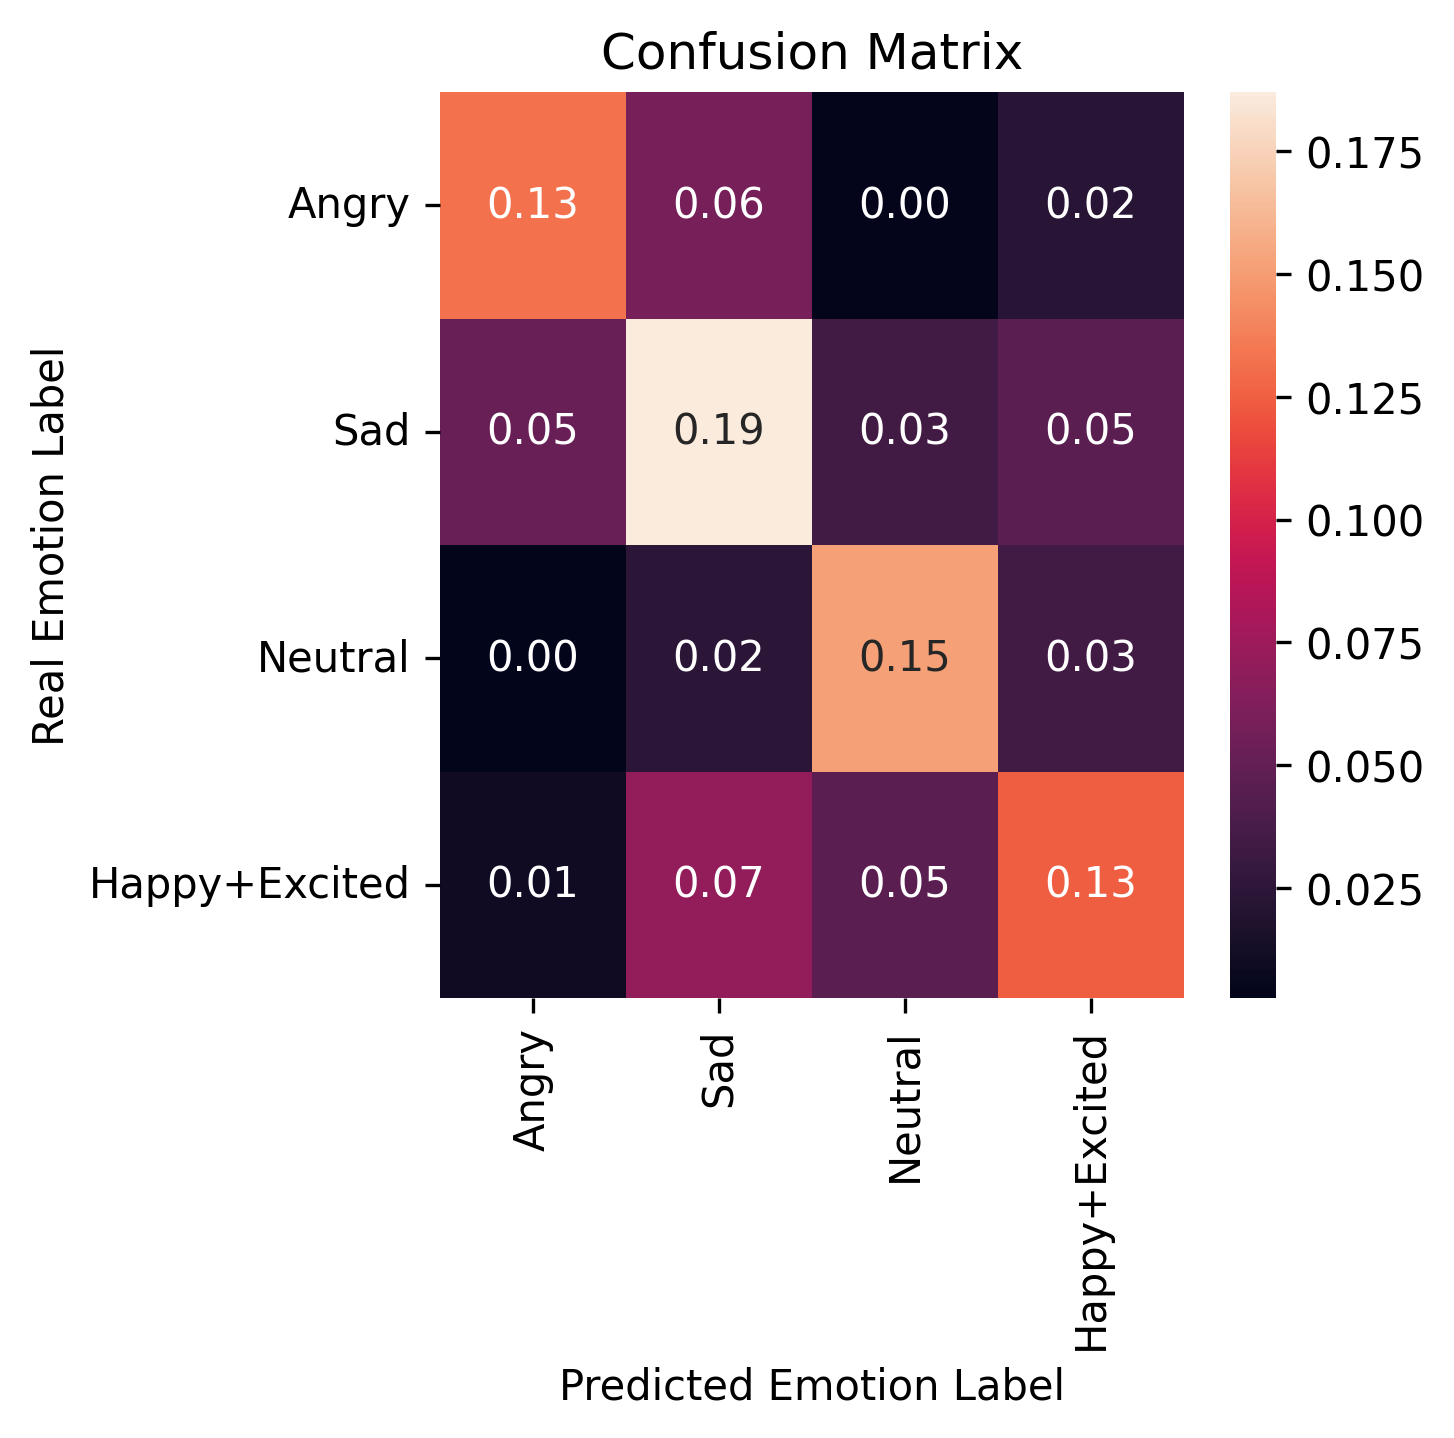

In [38]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

Neutral Data with more than 1 seconds of audio

Number of Audio Files: 5458


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1635
sad     2             1084

Accuracy for fold 0: 59.25%
Accuracy for fold 1: 61.54%
Accuracy for fold 2: 59.07%
Accuracy for fold 3: 60.77%
Accuracy for fold 4: 59.3%

Metric             Value
-----------------  -----------
Accuracy           59.99+-0.99
F1 score macro     60.84+-0.88
Precision          61.22+-1.11
Recall             60.73+-0.9
Matthews corrcoef  0.46+-0.01


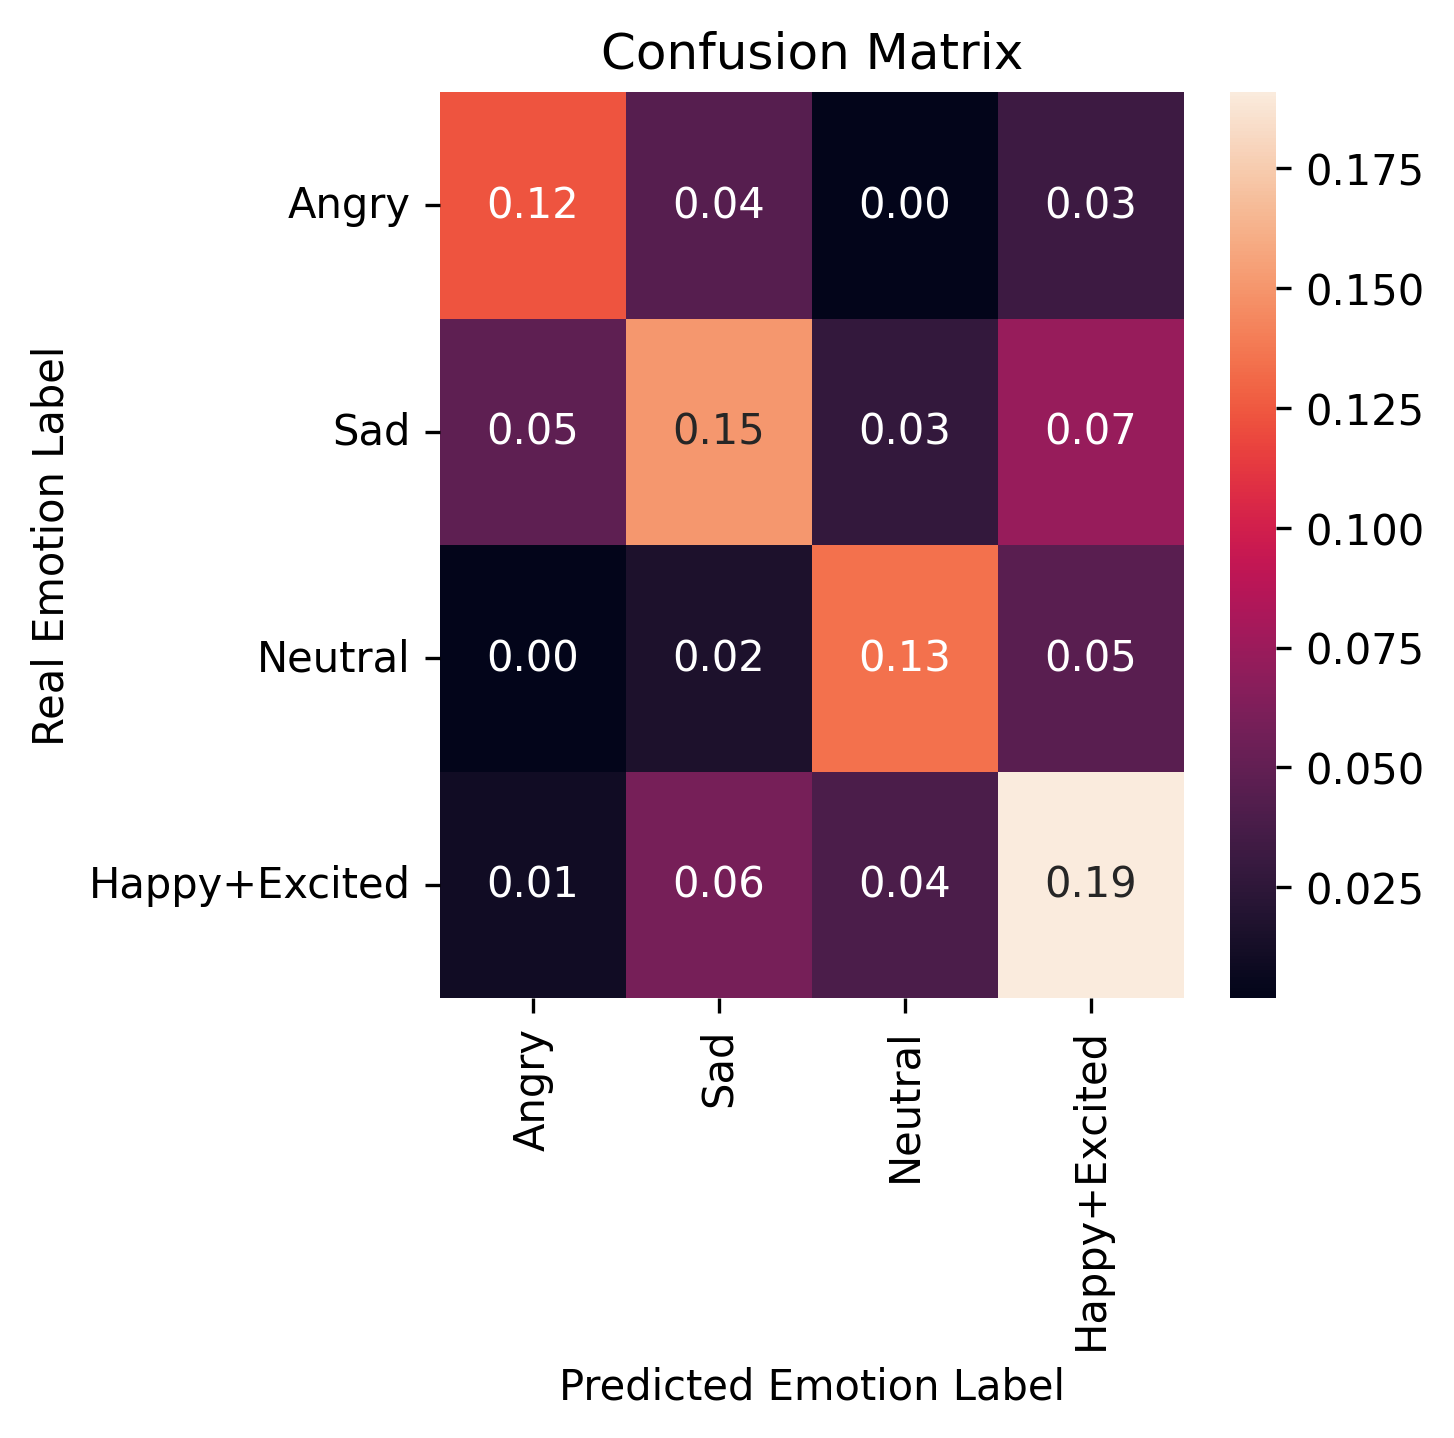

In [39]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

Data between 1.7 and 7 seconds of audio

Number of Audio Files: 3708


Emotion
                     count
Emotion Emotion_Id        
angry   0              723
happy   1             1105
neutral 3             1135
sad     2              745

Accuracy for fold 0: 56.2%
Accuracy for fold 1: 59.97%
Accuracy for fold 2: 56.06%
Accuracy for fold 3: 58.3%
Accuracy for fold 4: 59.24%

Metric             Value
-----------------  -----------
Accuracy           57.96+-1.58
F1 score macro     58.57+-1.43
Precision          59.22+-1.52
Recall             58.38+-1.43
Matthews corrcoef  0.43+-0.02


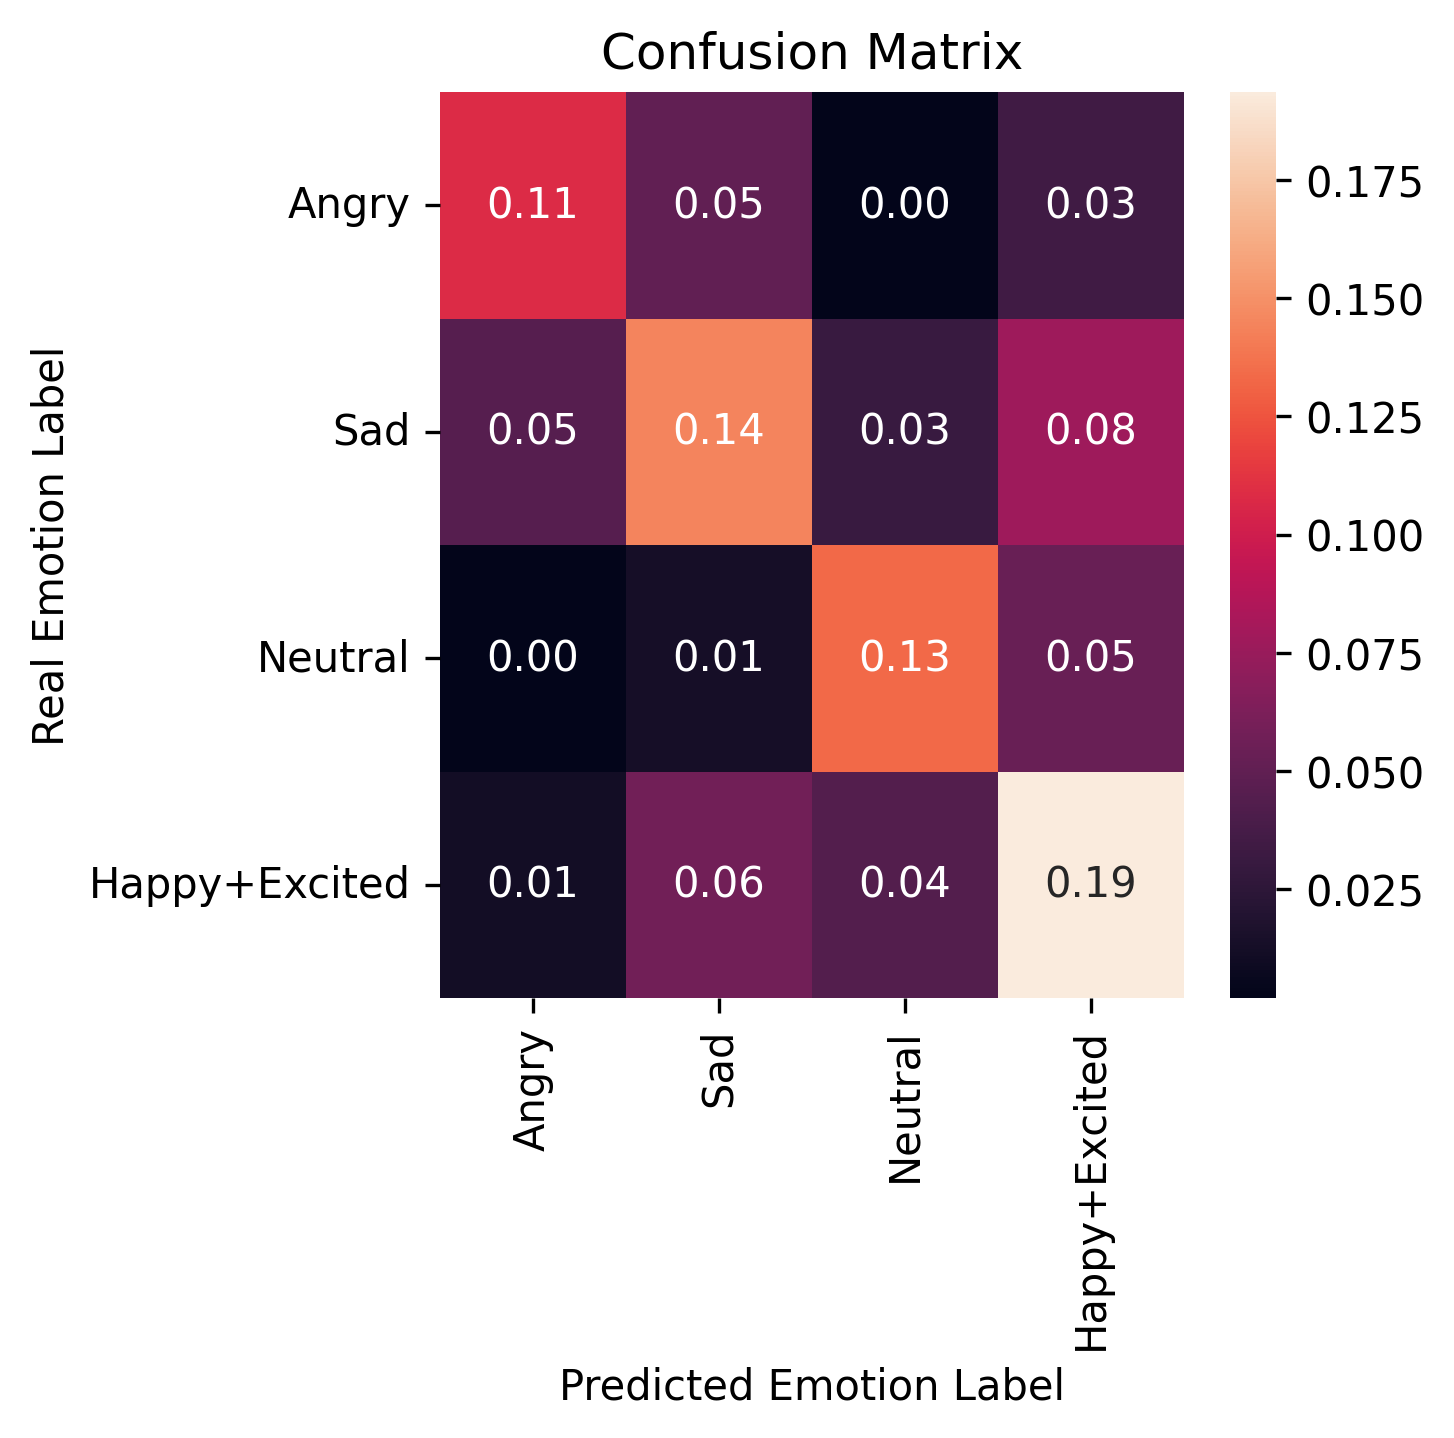

In [40]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 7) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

Data between 1.7 and 8 seconds of audio

Number of Audio Files: 3911


Emotion
                     count
Emotion Emotion_Id        
angry   0              754
happy   1             1186
neutral 3             1179
sad     2              792

Accuracy for fold 0: 55.56%
Accuracy for fold 1: 60.61%
Accuracy for fold 2: 56.65%
Accuracy for fold 3: 58.7%
Accuracy for fold 4: 57.67%

Metric             Value
-----------------  -----------
Accuracy           57.84+-1.74
F1 score macro     58.62+-1.84
Precision          59.39+-2.06
Recall             58.3+-1.68
Matthews corrcoef  0.43+-0.02


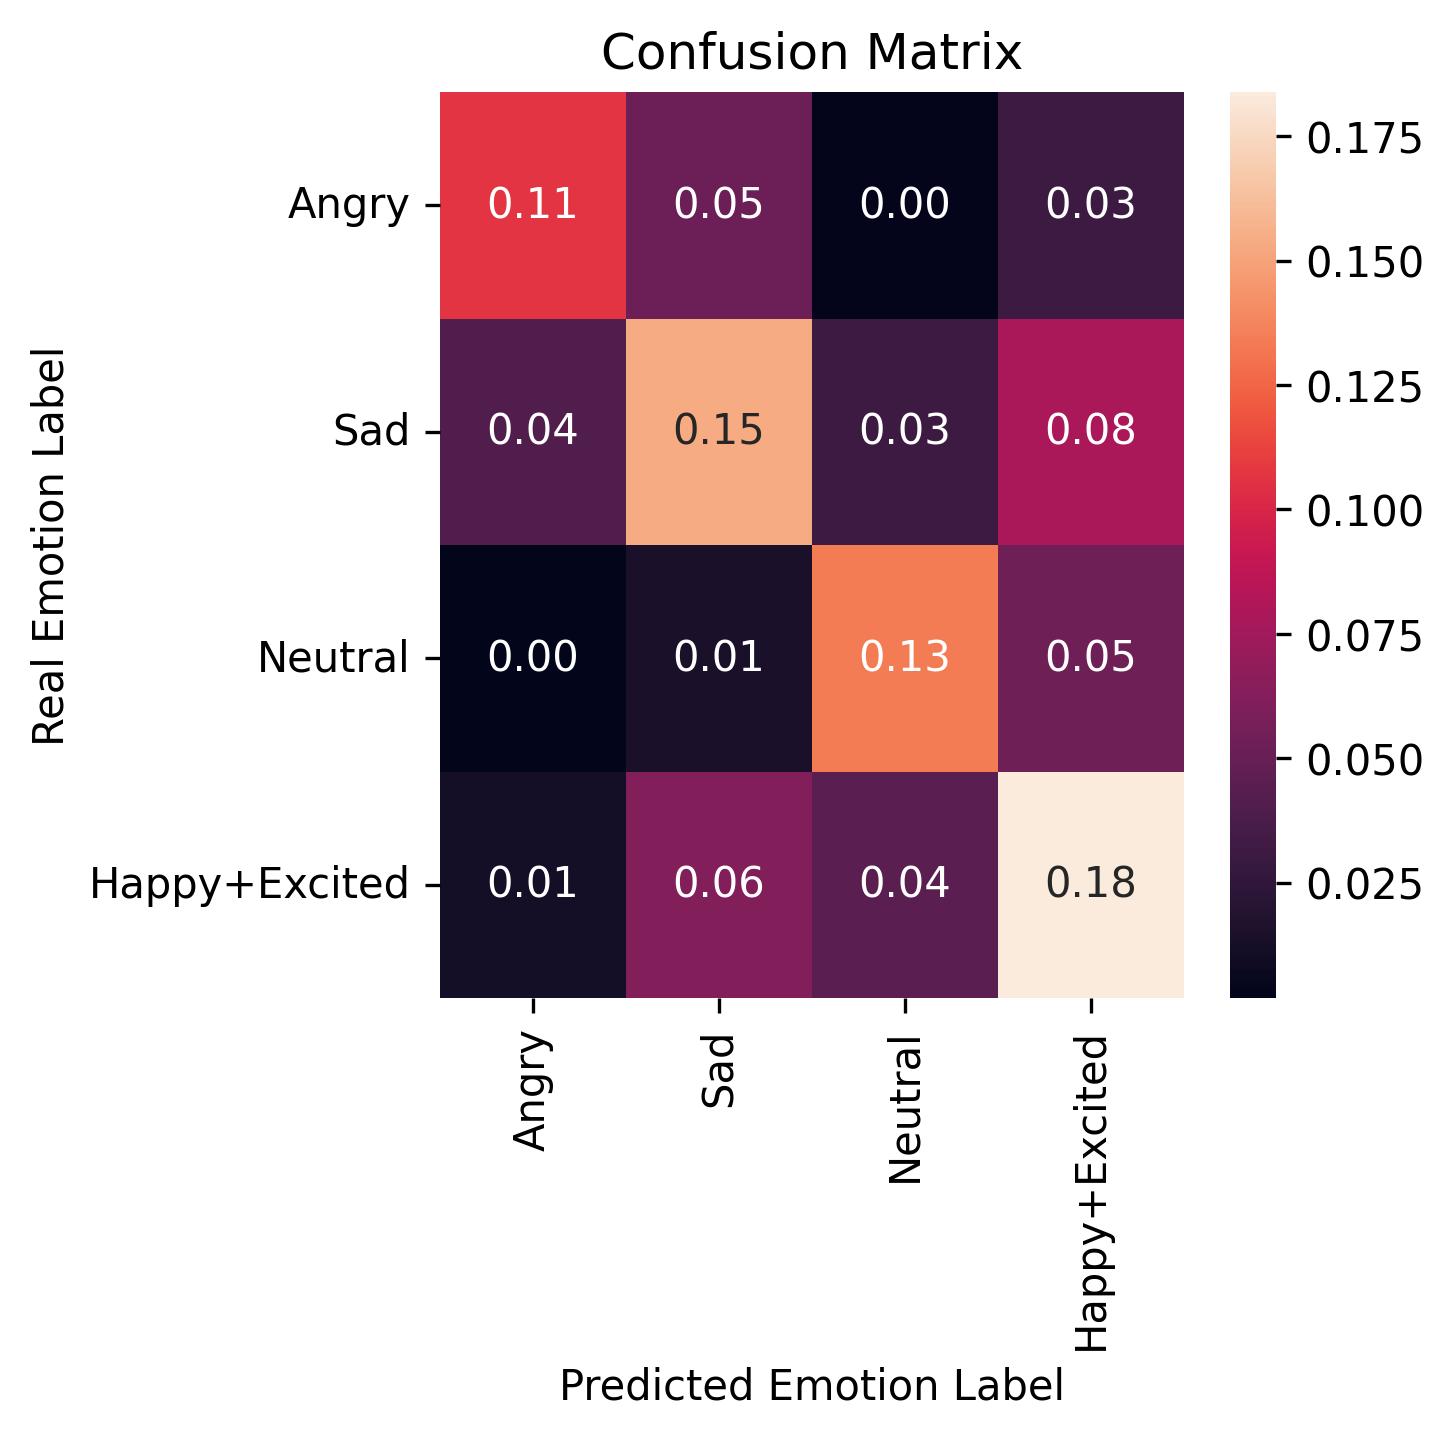

In [41]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 8) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

# Logistic Regression

In [42]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

model = LogisticRegression(n_jobs=-1, random_state=0)
model.fit(df.iloc[:,9:], df.iloc[:,5:6].values.ravel())
arousal_probabilities = model.predict_proba(df.iloc[:,9:])

final_df = df.copy(deep=True)
final_df["Low Arousal"] = [x[2] for x in arousal_probabilities]
final_df["Medium Arousal"] = [x[1] for x in arousal_probabilities]
final_df["High Arousal"] = [x[0] for x in arousal_probabilities]
final_df.groupby(['Emotion']).agg({'Low Arousal': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Arousal': ['describe']})
final_df.groupby(['Emotion']).agg({'High Arousal': ['describe']})

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   0             1636
neutral 1             1708
sad     2             1084

LogisticRegression(n_jobs=-1, random_state=0)

Low Arousal                                                        \
           describe                                                         
              count      mean       std           min       25%       50%   
Emotion                                                                     
angry        1103.0  0.047437  0.074044  9.588576e-12  0.007417  0.023298   
happy        1636.0  0.140382  0.164798  1.099662e-12  0.030136  0.079066   
neutral      1708.0  0.196037  0.189552  6.488243e-06  0.048499  0.129338   
sad          1084.0  0.430230  0.227006  1.039062e-03  0.239174  0.439171   

                             
                             
              75%       max  
Emotion                      
angry    0.058024  0.682653  
happy    0.185151  0.922103  
neutral  0.303838  0.908005  
sad      0.618100  0.944218

Medium Arousal                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.247219  0.112922  3.000155e-15  0.177229  0.265237   
happy           1636.0  0.311357  0.093047  3.817565e-15  0.267902  0.330569   
neutral         1708.0  0.337730  0.072845  8.134131e-06  0.295761  0.350507   
sad             1084.0  0.306667  0.083511  4.293931e-02  0.249844  0.318923   

                             
                             
              75%       max  
Emotion                      
angry    0.334274  0.492883  
happy    0.376928  0.497617  
neutral  0.388454  0.537115  
sad      0.372287  0.536754

High Arousal                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.705343  0.161871  0.102902  0.605023  0.706997   
happy         1636.0  0.548261  0.197197  0.018069  0.429170  0.559504   
neutral       1708.0  0.466233  0.196148  0.020699  0.318202  0.483657   
sad           1084.0  0.263103  0.170420  0.012842  0.124271  0.224671   

                             
                             
              75%       max  
Emotion                      
angry    0.811344  1.000000  
happy    0.680291  1.000000  
neutral  0.613284  0.999985  
sad      0.363300  0.881863

In [43]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

model = LogisticRegression(n_jobs=-1, random_state=0)
model.fit(df.iloc[:,9:], df.iloc[:,5:6].values.ravel())
valence_probabilities = model.predict_proba(df.iloc[:,9:])

final_df = df.copy(deep=True)
final_df["Low Valence"] = [x[2] for x in valence_probabilities]
final_df["Medium Valence"] = [x[1] for x in valence_probabilities]
final_df["High Valence"] = [x[0] for x in valence_probabilities]
final_df.groupby(['Emotion']).agg({'Low Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'High Valence': ['describe']})

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   2             1103
happy   0             1636
neutral 1             1708
sad     2             1084

LogisticRegression(n_jobs=-1, random_state=0)

Low Valence                                                    \
           describe                                                     
              count      mean       std       min       25%       50%   
Emotion                                                                 
angry        1103.0  0.399296  0.091466  0.102933  0.345403  0.396251   
happy        1636.0  0.385627  0.073482  0.118534  0.339887  0.385895   
neutral      1708.0  0.394864  0.069585  0.137427  0.353590  0.397007   
sad          1084.0  0.435786  0.050622  0.181412  0.402465  0.441088   

                             
                             
              75%       max  
Emotion                      
angry    0.446743  0.806246  
happy    0.429844  0.769718  
neutral  0.443611  0.617370  
sad      0.473417  0.575655

Medium Valence                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.261045  0.100289  1.173851e-22  0.229844  0.283641   
happy           1636.0  0.299930  0.070425  4.912642e-22  0.274947  0.308297   
neutral         1708.0  0.322128  0.048987  3.748085e-08  0.291172  0.320172   
sad             1084.0  0.316864  0.036065  1.912933e-01  0.294668  0.316757   

                             
                             
              75%       max  
Emotion                      
angry    0.325601  0.500106  
happy    0.338422  0.516437  
neutral  0.350593  0.534976  
sad      0.339929  0.451060

High Valence                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.339659  0.085002  0.117143  0.279824  0.326344   
happy         1636.0  0.314443  0.071042  0.166029  0.263462  0.304952   
neutral       1708.0  0.283007  0.062565  0.159508  0.238340  0.274105   
sad           1084.0  0.247350  0.051036  0.158925  0.210494  0.236829   

                             
                             
              75%       max  
Emotion                      
angry    0.377410  0.764732  
happy    0.350479  0.657705  
neutral  0.317580  0.531622  
sad      0.273102  0.526143

In [44]:
final_df.groupby(['Emotion']).agg({'Low Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'High Valence': ['describe']})

Low Valence                                                    \
           describe                                                     
              count      mean       std       min       25%       50%   
Emotion                                                                 
angry        1103.0  0.399296  0.091466  0.102933  0.345403  0.396251   
happy        1636.0  0.385627  0.073482  0.118534  0.339887  0.385895   
neutral      1708.0  0.394864  0.069585  0.137427  0.353590  0.397007   
sad          1084.0  0.435786  0.050622  0.181412  0.402465  0.441088   

                             
                             
              75%       max  
Emotion                      
angry    0.446743  0.806246  
happy    0.429844  0.769718  
neutral  0.443611  0.617370  
sad      0.473417  0.575655

Medium Valence                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.261045  0.100289  1.173851e-22  0.229844  0.283641   
happy           1636.0  0.299930  0.070425  4.912642e-22  0.274947  0.308297   
neutral         1708.0  0.322128  0.048987  3.748085e-08  0.291172  0.320172   
sad             1084.0  0.316864  0.036065  1.912933e-01  0.294668  0.316757   

                             
                             
              75%       max  
Emotion                      
angry    0.325601  0.500106  
happy    0.338422  0.516437  
neutral  0.350593  0.534976  
sad      0.339929  0.451060

High Valence                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.339659  0.085002  0.117143  0.279824  0.326344   
happy         1636.0  0.314443  0.071042  0.166029  0.263462  0.304952   
neutral       1708.0  0.283007  0.062565  0.159508  0.238340  0.274105   
sad           1084.0  0.247350  0.051036  0.158925  0.210494  0.236829   

                             
                             
              75%       max  
Emotion                      
angry    0.377410  0.764732  
happy    0.350479  0.657705  
neutral  0.317580  0.531622  
sad      0.273102  0.526143

In [45]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.groupby(['Emotion']).agg({'Activation': ['describe']})
df.groupby(['Emotion']).agg({'Valence': ['describe']})
df.groupby(['Emotion']).agg({'Dominance': ['describe']})

Activation                                                
          describe                                                
             count      mean       std  min  25%     50%  75%  max
Emotion                                                           
angry       1103.0  3.635539  0.670917  1.5  3.0  3.5000  4.0  5.0
happy       1636.0  3.411115  0.648457  1.5  3.0  3.5000  4.0  5.0
neutral     1708.0  2.725752  0.546526  1.0  2.5  2.6667  3.0  5.0
sad         1084.0  2.563499  0.622903  1.0  2.0  2.5000  3.0  4.5

Valence                                             
        describe                                             
           count      mean       std  min  25%  50%  75%  max
Emotion                                                      
angry     1103.0  1.905712  0.524000  1.0  1.5  2.0  2.0  4.0
happy     1636.0  3.947331  0.572246  1.5  3.5  4.0  4.5  5.5
neutral   1708.0  2.971361  0.510258  1.5  2.5  3.0  3.0  5.0
sad       1084.0  2.253075  0.580687  1.0  2.0  2.0  2.5  4.0

Dominance                                                
         describe                                                
            count      mean       std  min     25%  50%  75%  max
Emotion                                                          
angry      1103.0  3.949834  0.641306  1.0  3.5000  4.0  4.5  5.0
happy      1636.0  3.228453  0.763406  1.0  2.5000  3.0  4.0  5.0
neutral    1708.0  2.830553  0.606898  0.5  2.5000  3.0  3.0  4.5
sad        1084.0  2.827952  0.810631  1.0  2.3333  3.0  3.5  5.0

In [46]:
print(df.groupby(['Emotion']).agg({'Activation': ['describe']}).to_latex())
print(df.groupby(['Emotion']).agg({'Valence': ['describe']}).to_latex())
print(df.groupby(['Emotion']).agg({'Dominance': ['describe']}).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{Activation} \\
{} & \multicolumn{8}{l}{describe} \\
{} &      count &      mean &       std &  min &  25\% &     50\% &  75\% &  max \\
Emotion &            &           &           &      &      &         &      &      \\
\midrule
angry   &     1103.0 &  3.635539 &  0.670917 &  1.5 &  3.0 &  3.5000 &  4.0 &  5.0 \\
happy   &     1636.0 &  3.411115 &  0.648457 &  1.5 &  3.0 &  3.5000 &  4.0 &  5.0 \\
neutral &     1708.0 &  2.725752 &  0.546526 &  1.0 &  2.5 &  2.6667 &  3.0 &  5.0 \\
sad     &     1084.0 &  2.563499 &  0.622903 &  1.0 &  2.0 &  2.5000 &  3.0 &  4.5 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{Valence} \\
{} & \multicolumn{8}{l}{describe} \\
{} &    count &      mean &       std &  min &  25\% &  50\% &  75\% &  max \\
Emotion &          &           &           &      &      &      &      &      \\
\midrule
angry   &   1103.0 &  1.905712 &  0.524000 &  1.0 &  1.5 &  

C:\Users\Chico\AppData\Local\Temp\ipykernel_14984\847964222.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(['Emotion']).agg({'Activation': ['describe']}).to_latex())
C:\Users\Chico\AppData\Local\Temp\ipykernel_14984\847964222.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(['Emotion']).agg({'Valence': ['describe']}).to_latex())
C:\Users\Chico\AppData\Local\Temp\ipykernel_14984\847964222.py:3: FutureWarning: In future versions `Data

# Regression to Discrete

In [47]:
def regression_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    X = df.iloc[:, 5:]
    y = df.iloc[:, 4:5]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        valence_model = get_new_model()
        activation_model = get_new_model()
        dominance_model = get_new_model()
        classifier = RandomForest(n_estimators=512, n_jobs=-1, random_state=0)
        
        X_train, X_test = X.iloc[train, 3:].values, X.iloc[test, 3:].values
        X_train_class = X.iloc[train, 0:3]

        y_train_valence = X.iloc[train, 0:1]
        y_train_activation = X.iloc[train, 1:2]
        y_train_dominance = X.iloc[train, 2:3]

        y_train, y_test = y.iloc[train], y.iloc[test]

        folds_size.append(len(y_test))

        valence_model.fit(X_train, y_train_valence.values.ravel())
        activation_model.fit(X_train, y_train_activation.values.ravel())
        dominance_model.fit(X_train, y_train_dominance.values.ravel())

        # should I use a classifier trained before or here
        classifier.fit(X_train_class.values, y_train.values.ravel())

        class_input = np.stack(
            (valence_model.predict(X_test),
             activation_model.predict(X_test),
             dominance_model.predict(X_test)), axis=1)
        y_pred = classifier.predict(class_input)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    results.append([used_labels, get_metrics(
        all_y_labels, all_y_pred, folds_size, used_labels.split(", ")), len(df)])

    return results


Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084

Accuracy for fold 0: 41.55%
Accuracy for fold 1: 43.22%
Accuracy for fold 2: 41.14%
Accuracy for fold 3: 39.51%
Accuracy for fold 4: 40.96%

Metric             Value
-----------------  -----------
Accuracy           41.28+-1.19
F1 score macro     40.06+-1.43
Precision          59.12+-2.42
Recall             45.88+-0.94
Matthews corrcoef  0.29+-0.01


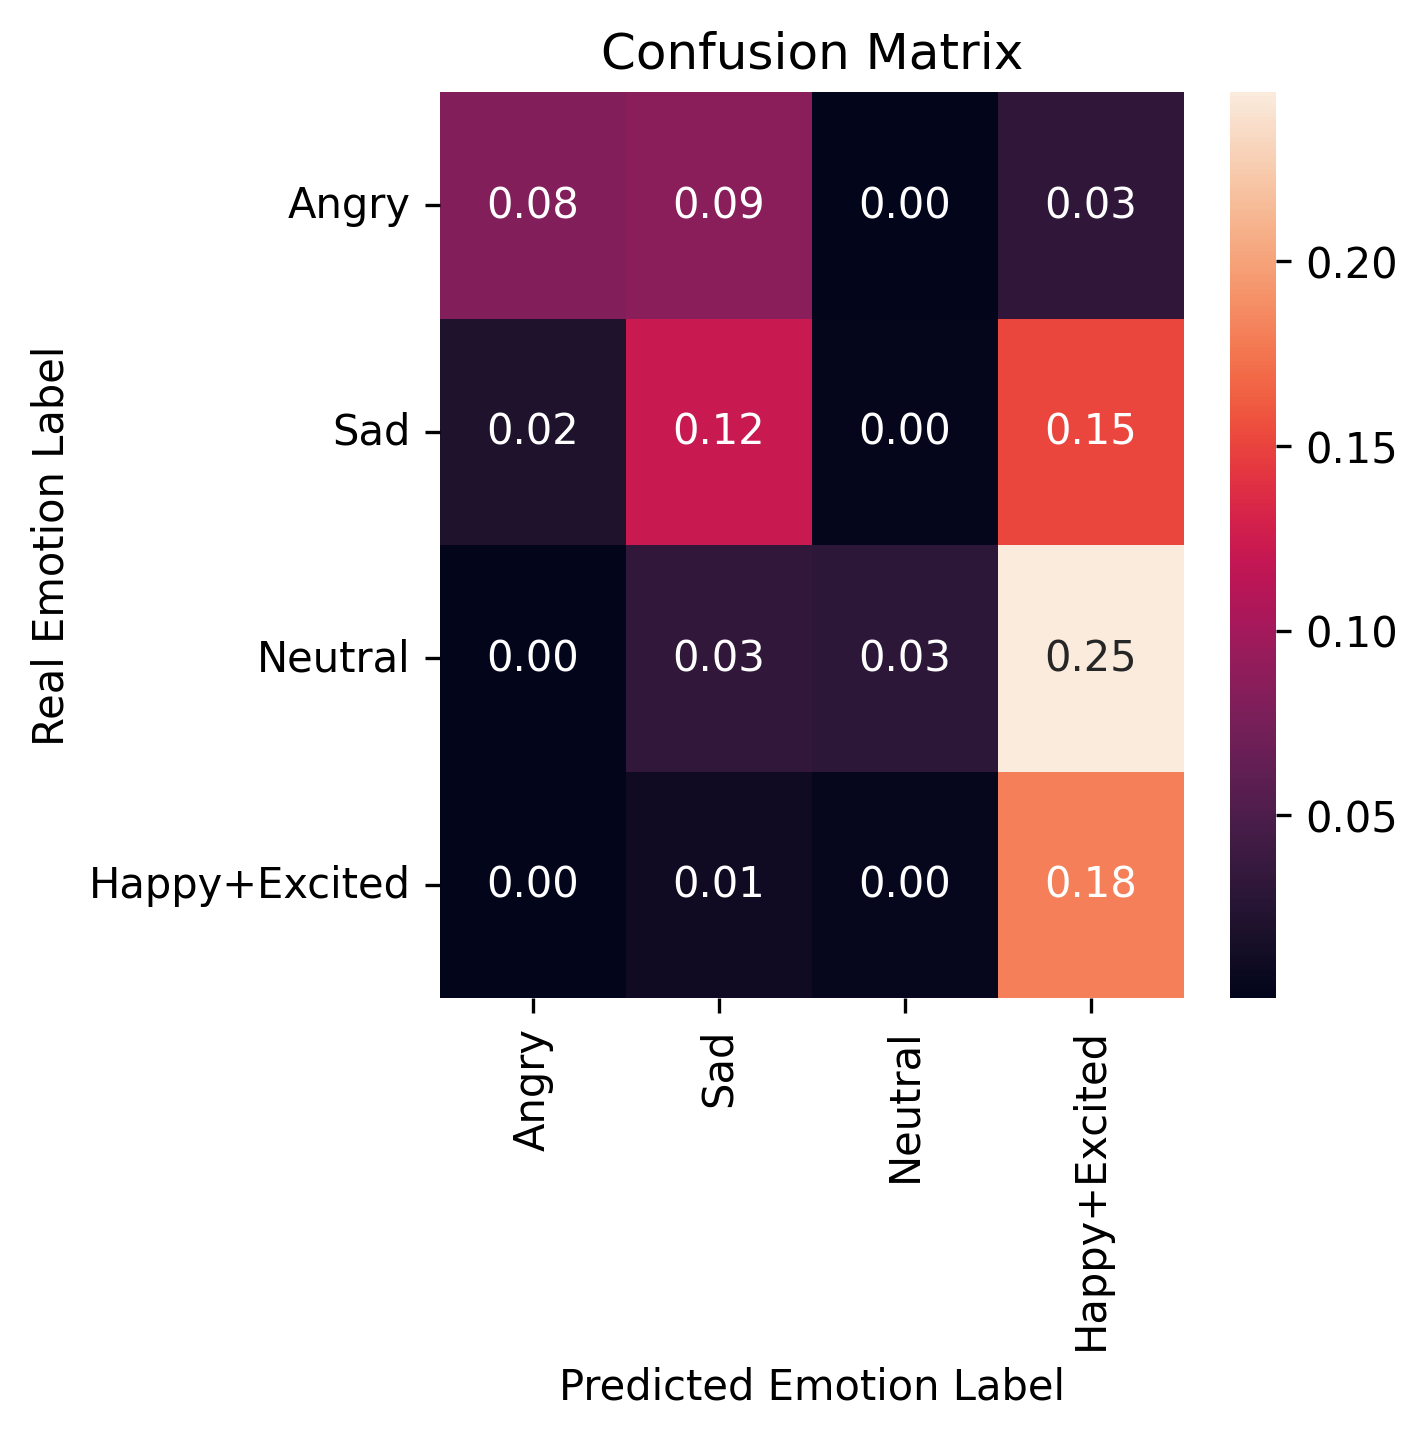

In [48]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = regression_cross_validation(get_new_model_regressor, "Angry, Sad, Neutral, Happy", results)